# Imports

In [1]:
# for loading and manipulating data
import pickle
import pandas as pd
import numpy as np

# for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context='poster')
plt.rcParams['figure.figsize'] = [20,10]
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# for checking significance of relationships
from scipy.stats import pearsonr

# for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.stattools import adfuller

# custom functions
import sys
sys.path.append(r"C:\Users\User\Documents\projects\LHL_final_project_influenza_forecasting\src")
from plot_target_relationship import *

# Datasets

In [5]:
# basic time series with total cases
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))
df_flu_subtypes = pickle.load(open(r"..\data\flu_cases\df_flu.pkl", "rb" ))

# full feature set - full time series, pre-COVID, post-COVID
df_features = pickle.load(open(r"..\data\df_flu_all_features.pkl", "rb" ))
df_features_pre_COVID = pickle.load(open(r"..\data\df_flu_pre_COVID_all_features.pkl", "rb" ))
df_features_COVID = pickle.load(open(r"..\data\df_flu_COVID_all_features.pkl", "rb" ))

# to get column names for individual feature sets
df_health_indicators = pickle.load(open(r"..\data\health_indicators\df_health_indicators.pkl", "rb" ))
df_air_travel = pickle.load(open(r"..\data\mobility\df_air_travel.pkl", "rb" ))
df_urban_transit = pickle.load(open(r"..\data\mobility\df_urban_transit.pkl", "rb" ))
df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

# Time Series Analysis

In [78]:
df_flu_subtypes.head()

Surveillance Week  A(H1N1)pdm09  A(H3N2)  A(Unsubtyped)  Influenza B  Year  \
0                35           1.0      2.0            3.0          3.0  2015   
1                36           2.0     11.0            5.0          0.0  2015   
2                37           0.0     10.0            4.0          1.0  2015   
3                38           0.0     16.0           13.0          0.0  2015   
4                39           6.0     34.0           13.0          6.0  2015   

   Total Cases Epiweek Week Ending  
0          9.0  201535  2015-09-05  
1         18.0  201536  2015-09-12  
2         15.0  201537  2015-09-19  
3         29.0  201538  2015-09-26  
4         59.0  201539  2015-10-03

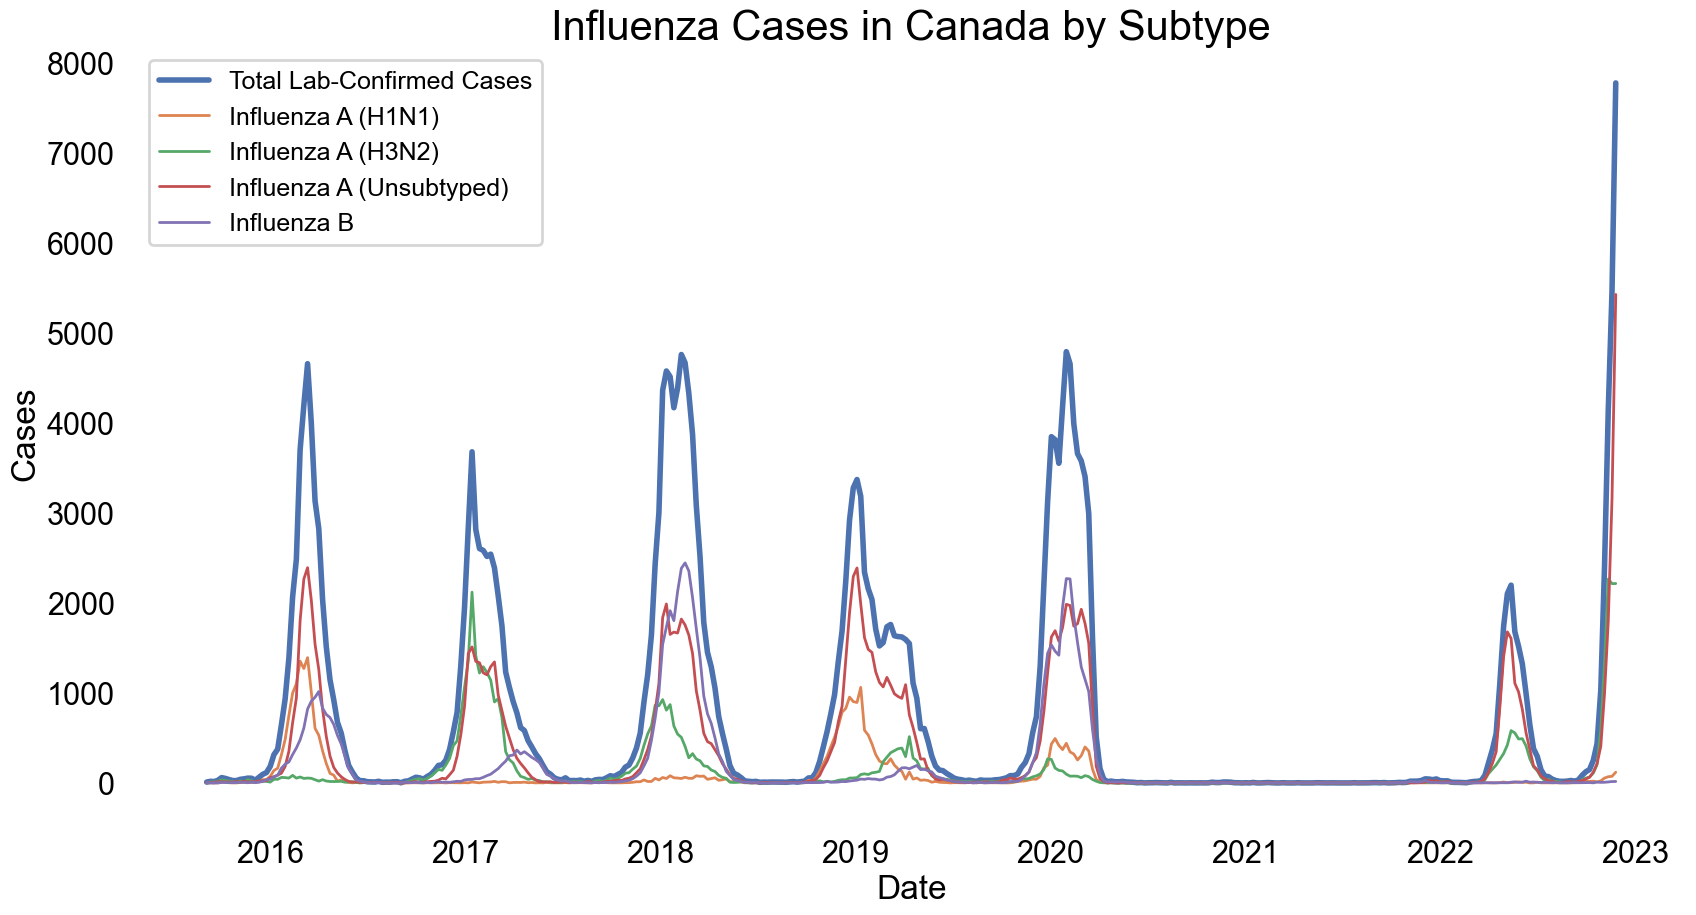

In [79]:
df_flu_subtypes = df_flu_subtypes.set_index('Week Ending')

fig, ax = plt.subplots()

plt.plot(df_flu_subtypes['Total Cases'], label='Total Lab-Confirmed Cases', linewidth=4)
plt.plot(df_flu_subtypes['A(H1N1)pdm09'], label='Influenza A (H1N1)', linewidth=2)
plt.plot(df_flu_subtypes['A(H3N2)'], label='Influenza A (H3N2)', linewidth=2)
plt.plot(df_flu_subtypes['A(Unsubtyped)'], label='Influenza A (Unsubtyped)', linewidth=2)
plt.plot(df_flu_subtypes['Influenza B'], label='Influenza B', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend(loc='upper left', prop={'size': 18})
plt.title('Influenza Cases in Canada by Subtype', fontsize= 30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [5]:
df_flu_pre_COVID = df_features_pre_COVID[['Week Ending','y1']].set_index('Week Ending').dropna()
df_flu_COVID = df_features_COVID[['Week Ending','y1']].set_index('Week Ending').dropna()
df_flu = df_features[['Week Ending','y1']].set_index('Week Ending').dropna()

In [6]:
# baseline / level = average value

a = round(df_flu_pre_COVID['y1'].mean())
b = round(df_flu_COVID['y1'].mean())
c = round(df_flu['y1'].mean())

print(f'Baseline flu level from September 2015 to March 2020 was approximately {a} laboratory-confirmed cases per week.')
print(f'Baseline flu level from March 2020 to to present was approximately {b} laboratory-confirmed cases per week.')
print(f'Baseline flu level from September 2015 to to present was approximately {c} laboratory-confirmed cases per week.')

Baseline flu level from September 2015 to March 2020 was approximately 1010 laboratory-confirmed cases per week.
Baseline flu level from March 2020 to to present was approximately 328 laboratory-confirmed cases per week.
Baseline flu level from September 2015 to to present was approximately 752 laboratory-confirmed cases per week.


In [7]:
# baseline / level = average value

a = round(df_flu_pre_COVID['y1'].std())
b = round(df_flu_COVID['y1'].std())
c = round(df_flu['y1'].std())

print(f'Standard Deviation of Flu Cases from September 2015 to March 2020 was approximately {a} laboratory-confirmed cases per week.')
print(f'Standard Deviation of Flu Cases from March 2020 to to present was approximately {b} laboratory-confirmed cases per week.')
print(f'Standard Deviation of Flu Cases from September 2015 to to present was approximately {c} laboratory-confirmed cases per week.')

Standard Deviation of Flu Cases from September 2015 to March 2020 was approximately 1359 laboratory-confirmed cases per week.
Standard Deviation of Flu Cases from March 2020 to to present was approximately 1011 laboratory-confirmed cases per week.
Standard Deviation of Flu Cases from September 2015 to to present was approximately 1281 laboratory-confirmed cases per week.


In [8]:
df_flu_pre_COVID.describe()

y1
count   235.000000
mean   1009.944681
std    1358.688662
min       2.000000
25%      37.500000
50%     238.000000
75%    1629.500000
max    4789.000000

In [9]:
df_flu_COVID.describe()

y1
count   143.000000
mean    328.398601
std    1011.026164
min       0.000000
25%       1.000000
50%       6.000000
75%      42.500000
max    7773.000000

In [10]:
df_flu.describe()

y1
count   378.000000
mean    752.111111
std    1280.766037
min       0.000000
25%      10.000000
50%      57.000000
75%     971.000000
max    7773.000000

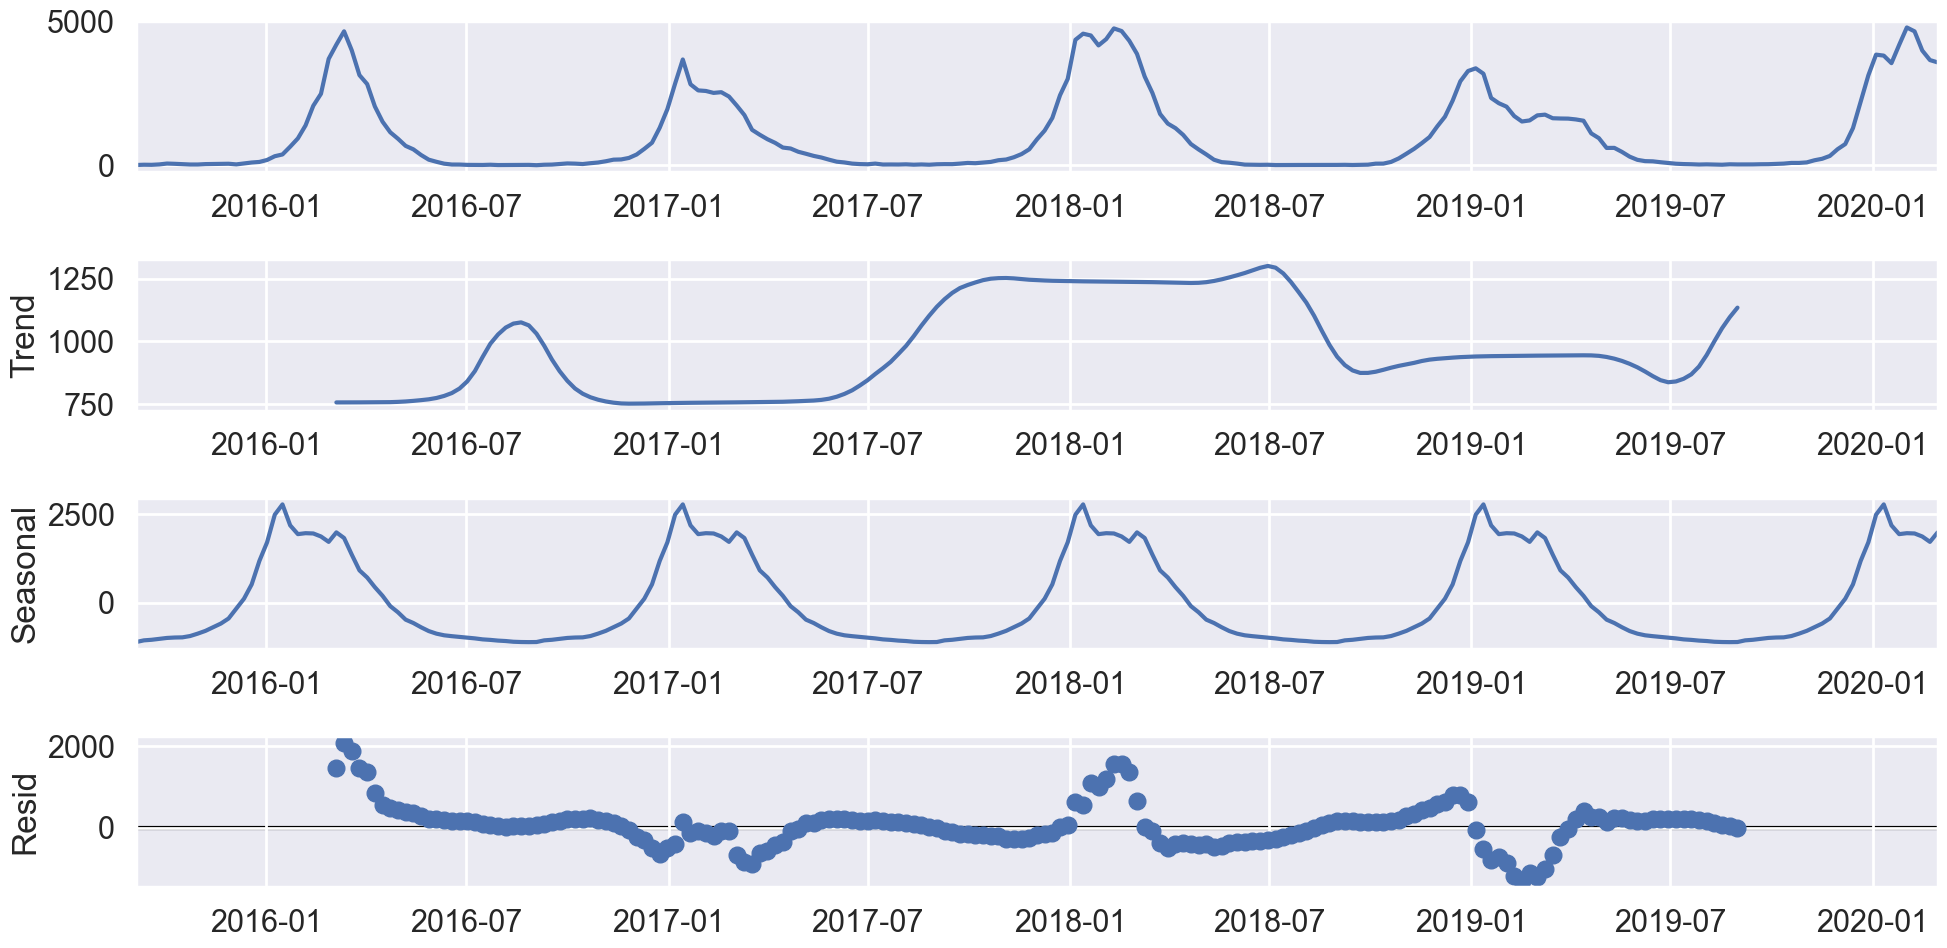

In [11]:
# Decomposition
result = seasonal_decompose(df_flu_pre_COVID)
result.plot();

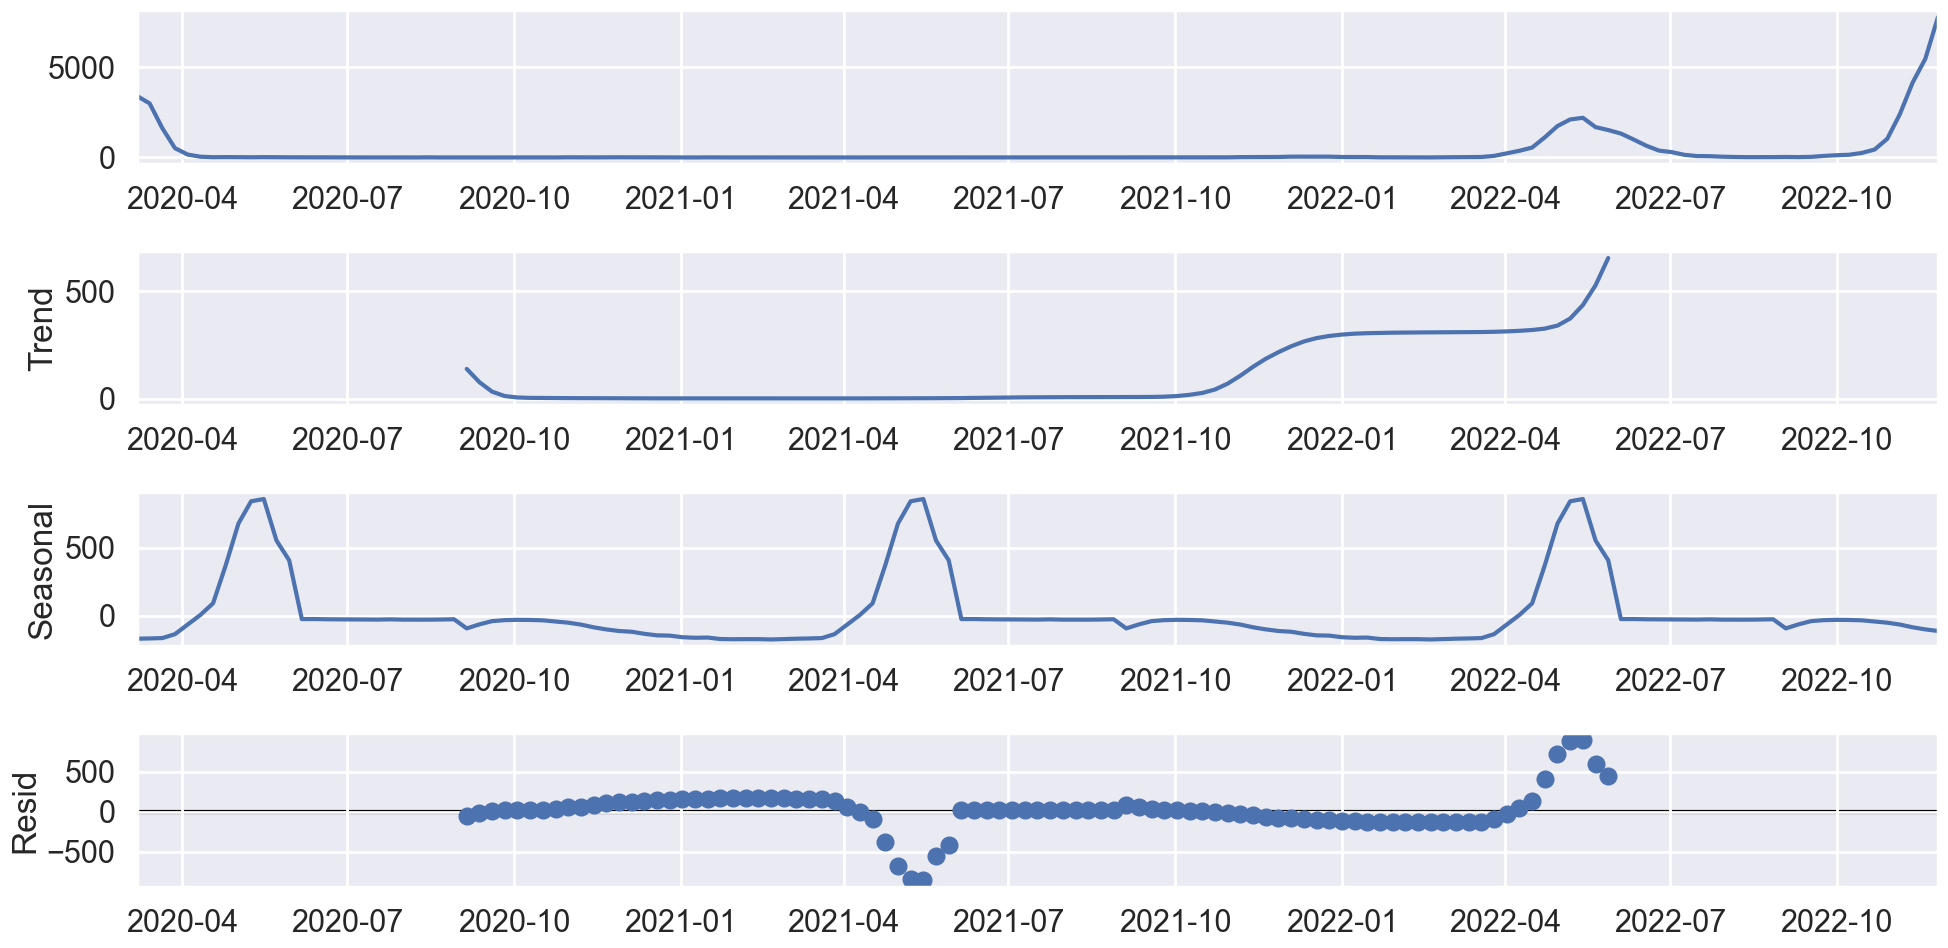

In [12]:
result = seasonal_decompose(df_flu_COVID)
result.plot();

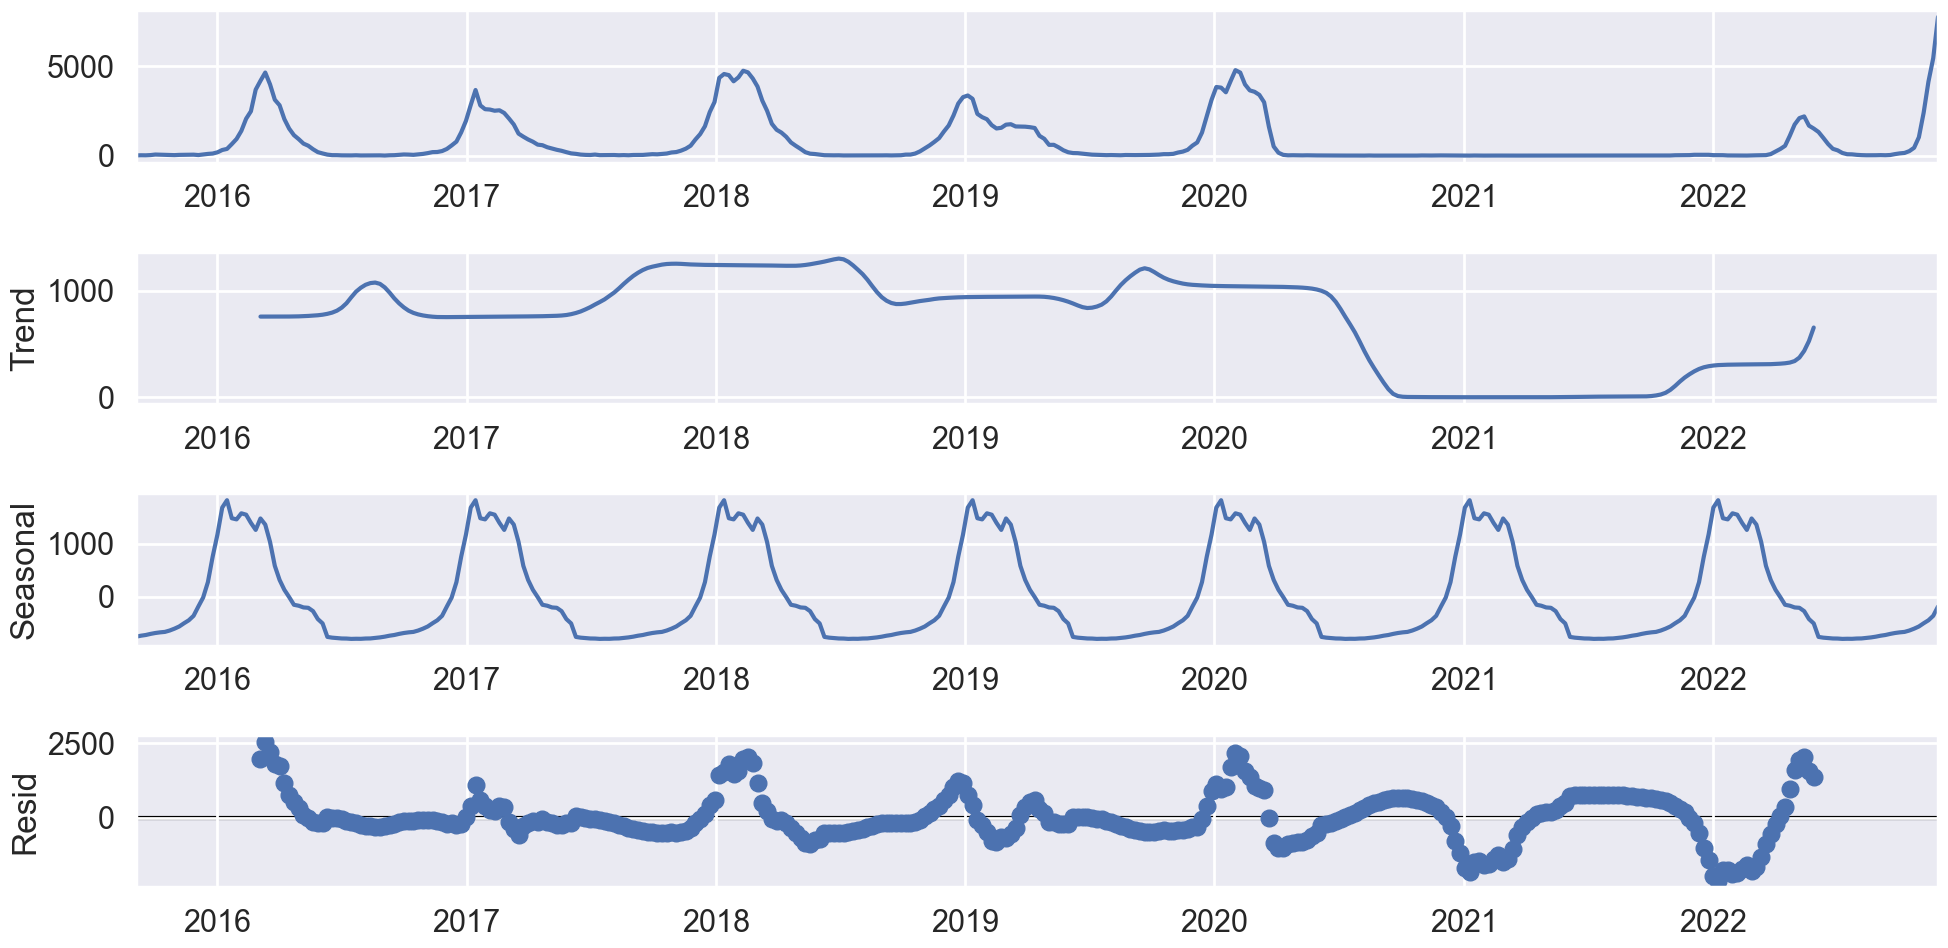

In [13]:
result = seasonal_decompose(df_flu)
result.plot();

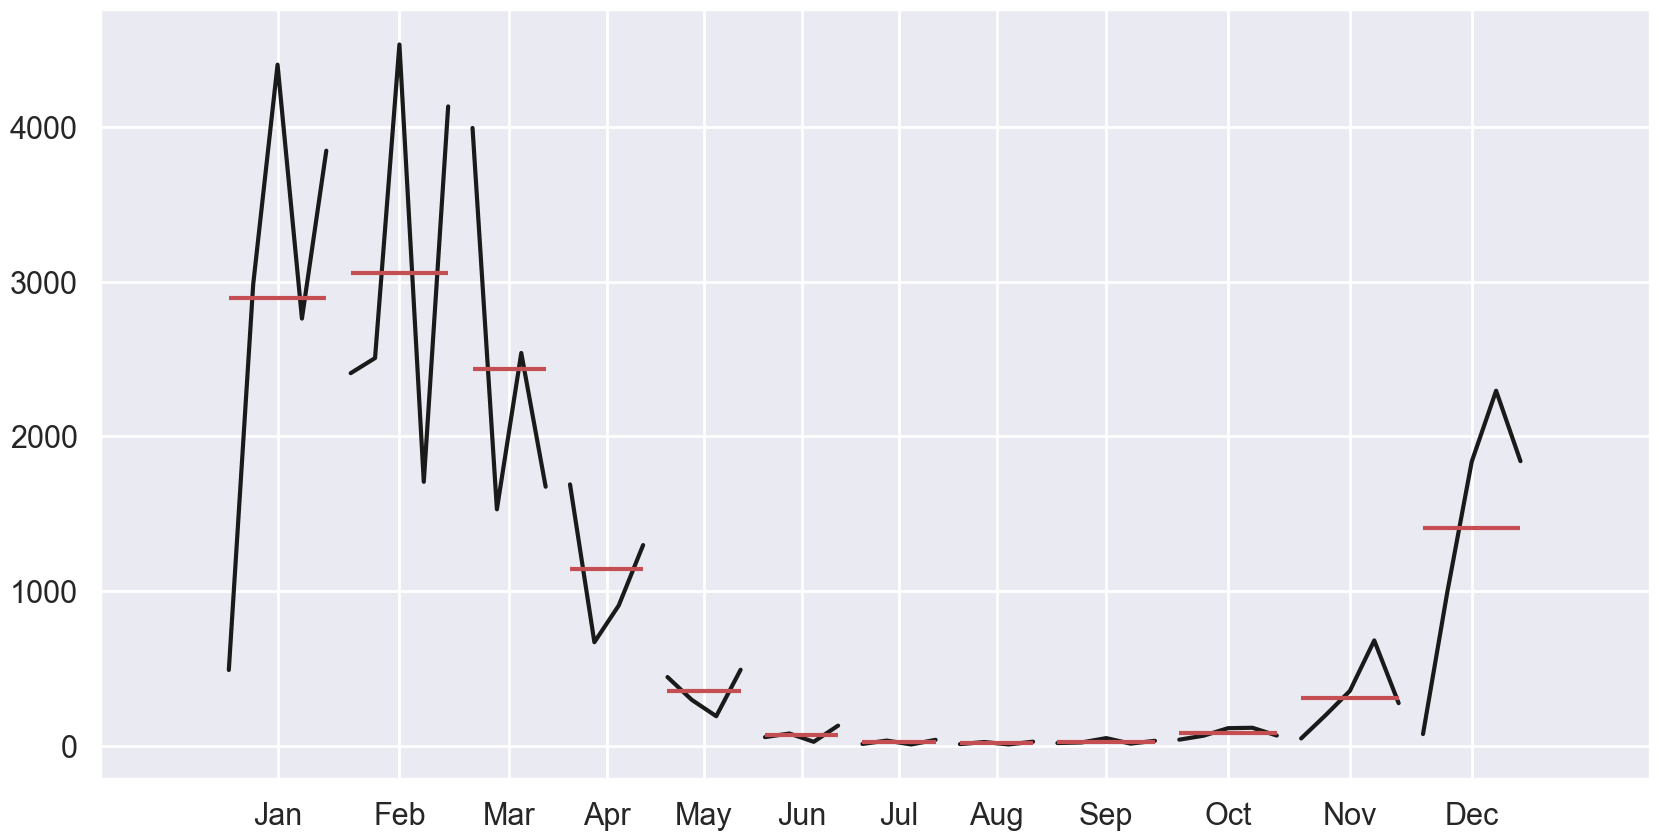

In [14]:
df_flu_pre_COVID_month = df_flu_pre_COVID.resample('M').mean()
month_plot(df_flu_pre_COVID_month)
plt.show()

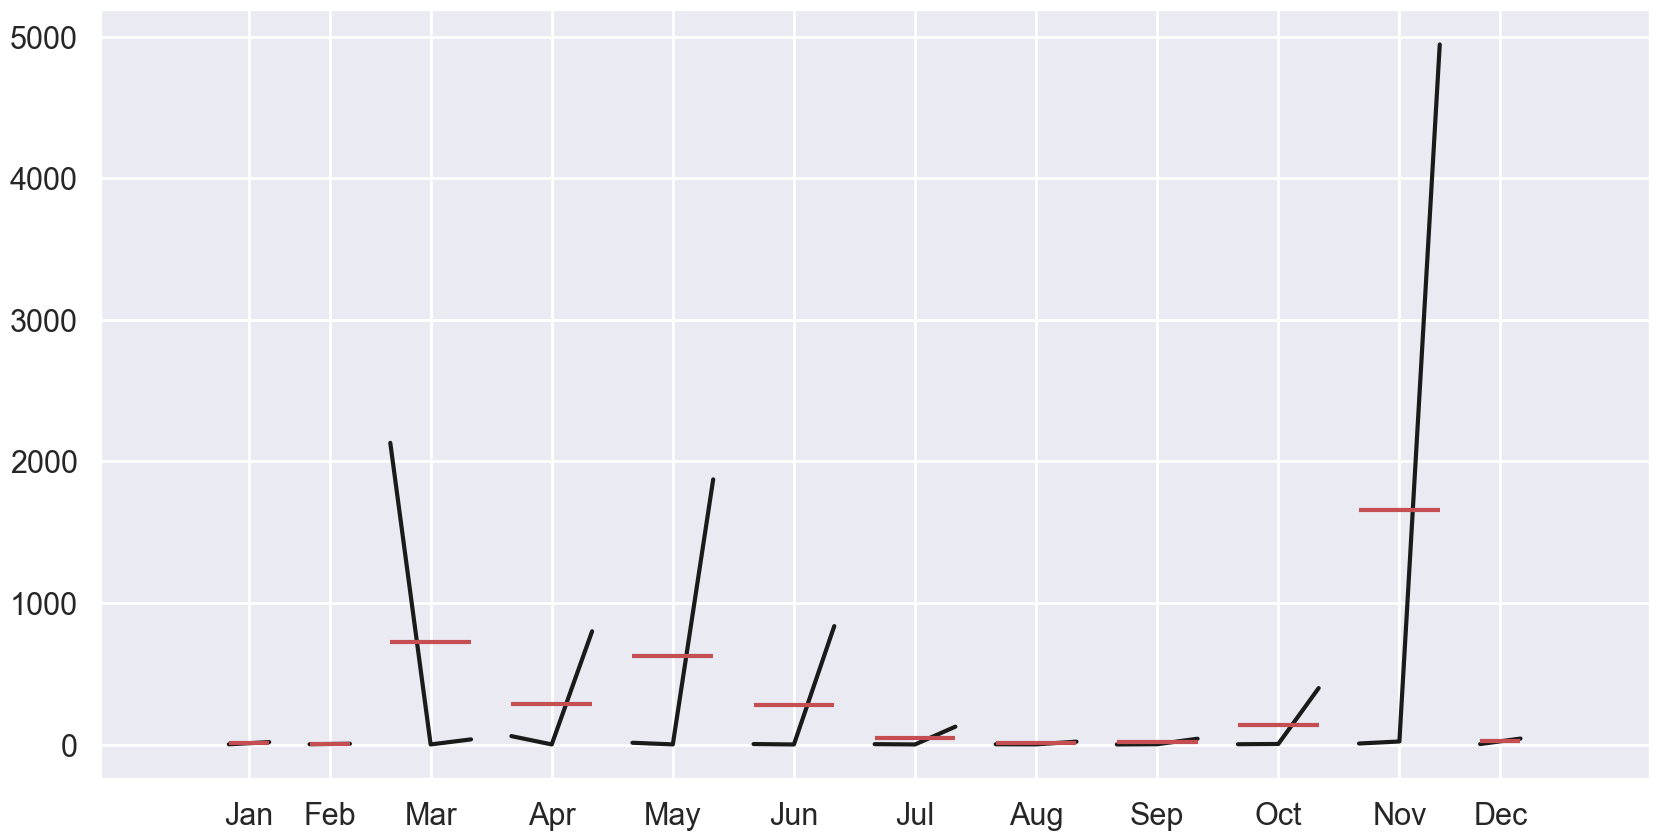

In [15]:
df_flu_COVID_month = df_flu_COVID.resample('M').mean()
month_plot(df_flu_COVID_month)
plt.show()

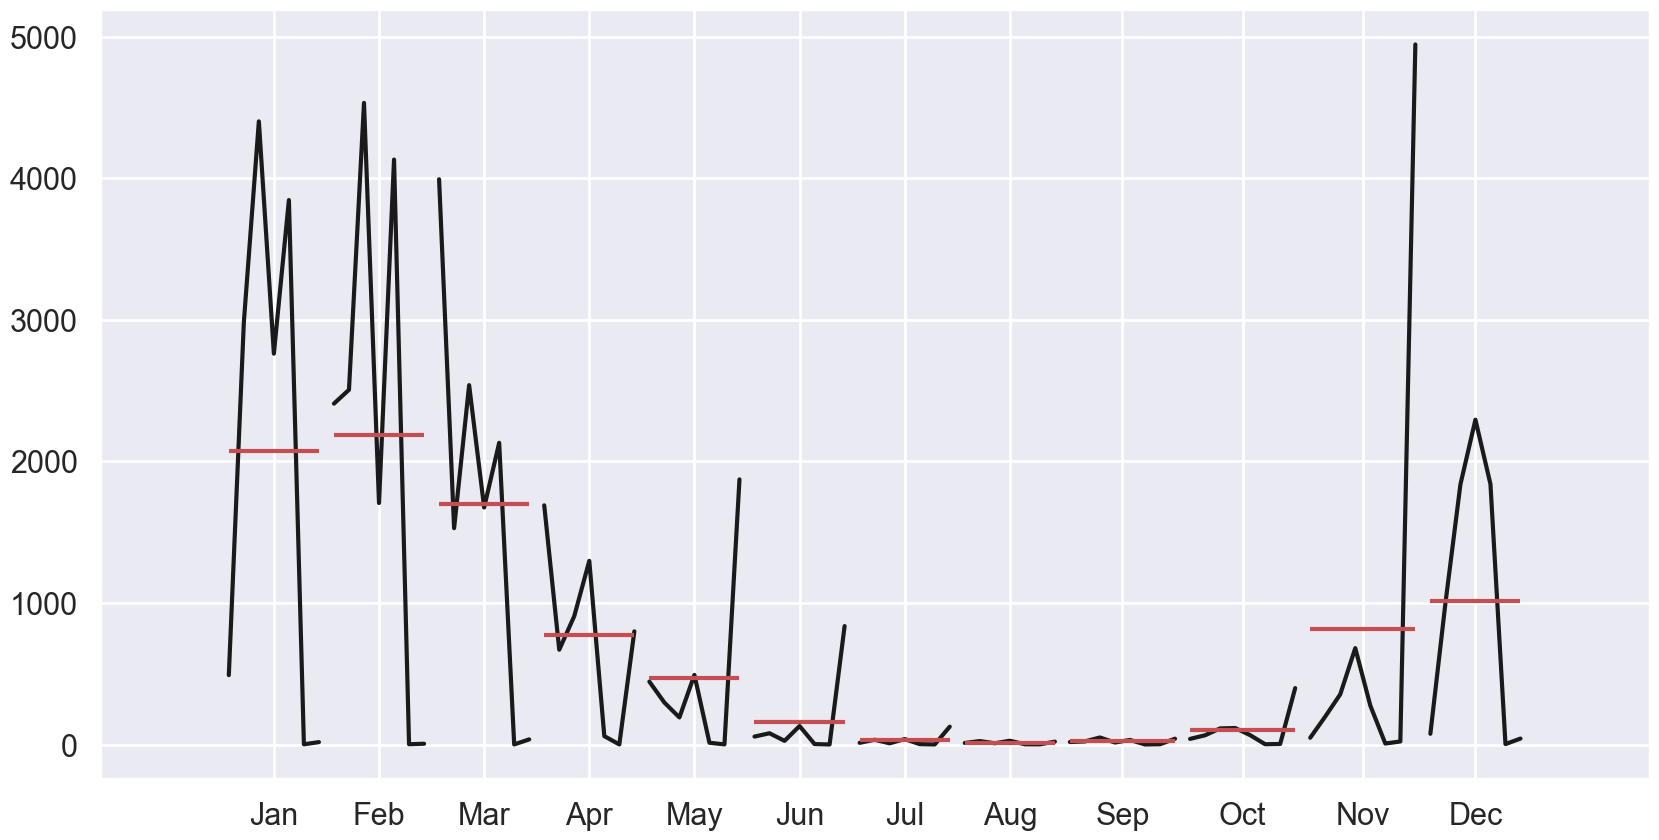

In [16]:
df_flu_month = df_flu.resample('M').mean()
month_plot(df_flu_month)
plt.show()

In [8]:
df_features = pickle.load(open(r"..\data\df_flu_all_features.pkl", "rb" ))
df_features_pre_COVID = pickle.load(open(r"..\data\df_flu_pre_COVID_all_features.pkl", "rb" ))
df_features_COVID = pickle.load(open(r"..\data\df_flu_COVID_all_features.pkl", "rb" ))

In [9]:
df_month = df_features[['month','y1']].dropna()
df_month_pre_COVID = df_features_pre_COVID[['month','y1']].dropna()
df_month_COVID = df_features_COVID[['month','y1']].dropna()

In [10]:
# add month name
month_dict = {
    1:'January',
    2:'February',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'August',
    9:'September',
    10:'October',
    11:'November',
    12:'December'}
df_month["month_name"] = df_month["month"].map(month_dict)
df_month_pre_COVID["month_name"] = df_month_pre_COVID["month"].map(month_dict)
df_month_COVID["month_name"] = df_month_COVID["month"].map(month_dict)

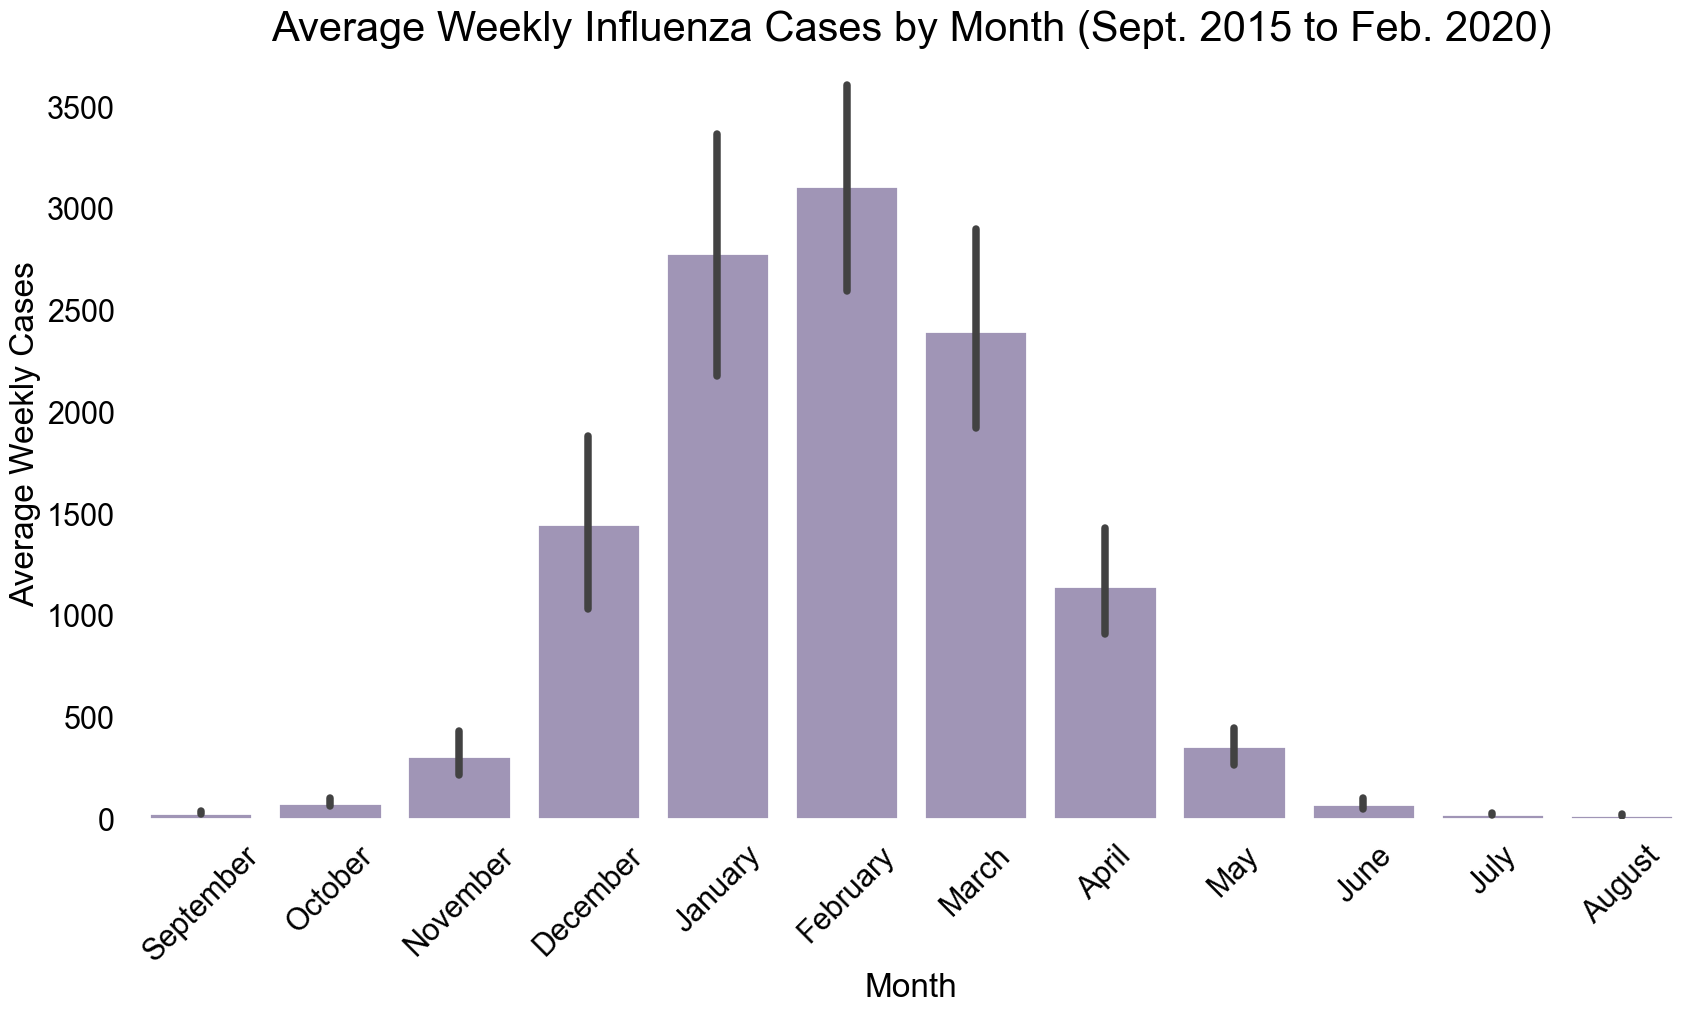

In [11]:
fig, ax = plt.subplots()
sns.barplot(data=df_month_pre_COVID, x='month_name', y='y1', color='mediumpurple', saturation=0.3)
ax.set_ylabel('Average Weekly Cases')
ax.set_xlabel('Month')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Average Weekly Influenza Cases by Month (Sept. 2015 to Feb. 2020)', fontsize= 30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [13]:
order_dict = {
    3:6,
    4:7,
    5:8,
    6:9,
    7:10,
    8:11,
    9:0,
    10:1,
    11:2,
    12:3,
    1:4,
    2:5}
df_month_COVID["order"] = df_month_COVID["month"].map(order_dict)

In [15]:
df_month_COVID = df_month_COVID.sort_values(by='order')

In [16]:
df_month_COVID

month    y1 month_name  order
313      9   3.0  September      0
314      9   1.0  September      0
315      9   4.0  September      0
264      9   0.0  September      0
263      9   1.0  September      0
..     ...   ...        ...    ...
311      8   1.0     August     11
310      8   0.0     August     11
309      8   0.0     August     11
361      8  26.0     August     11
258      8   6.0     August     11

[143 rows x 4 columns]

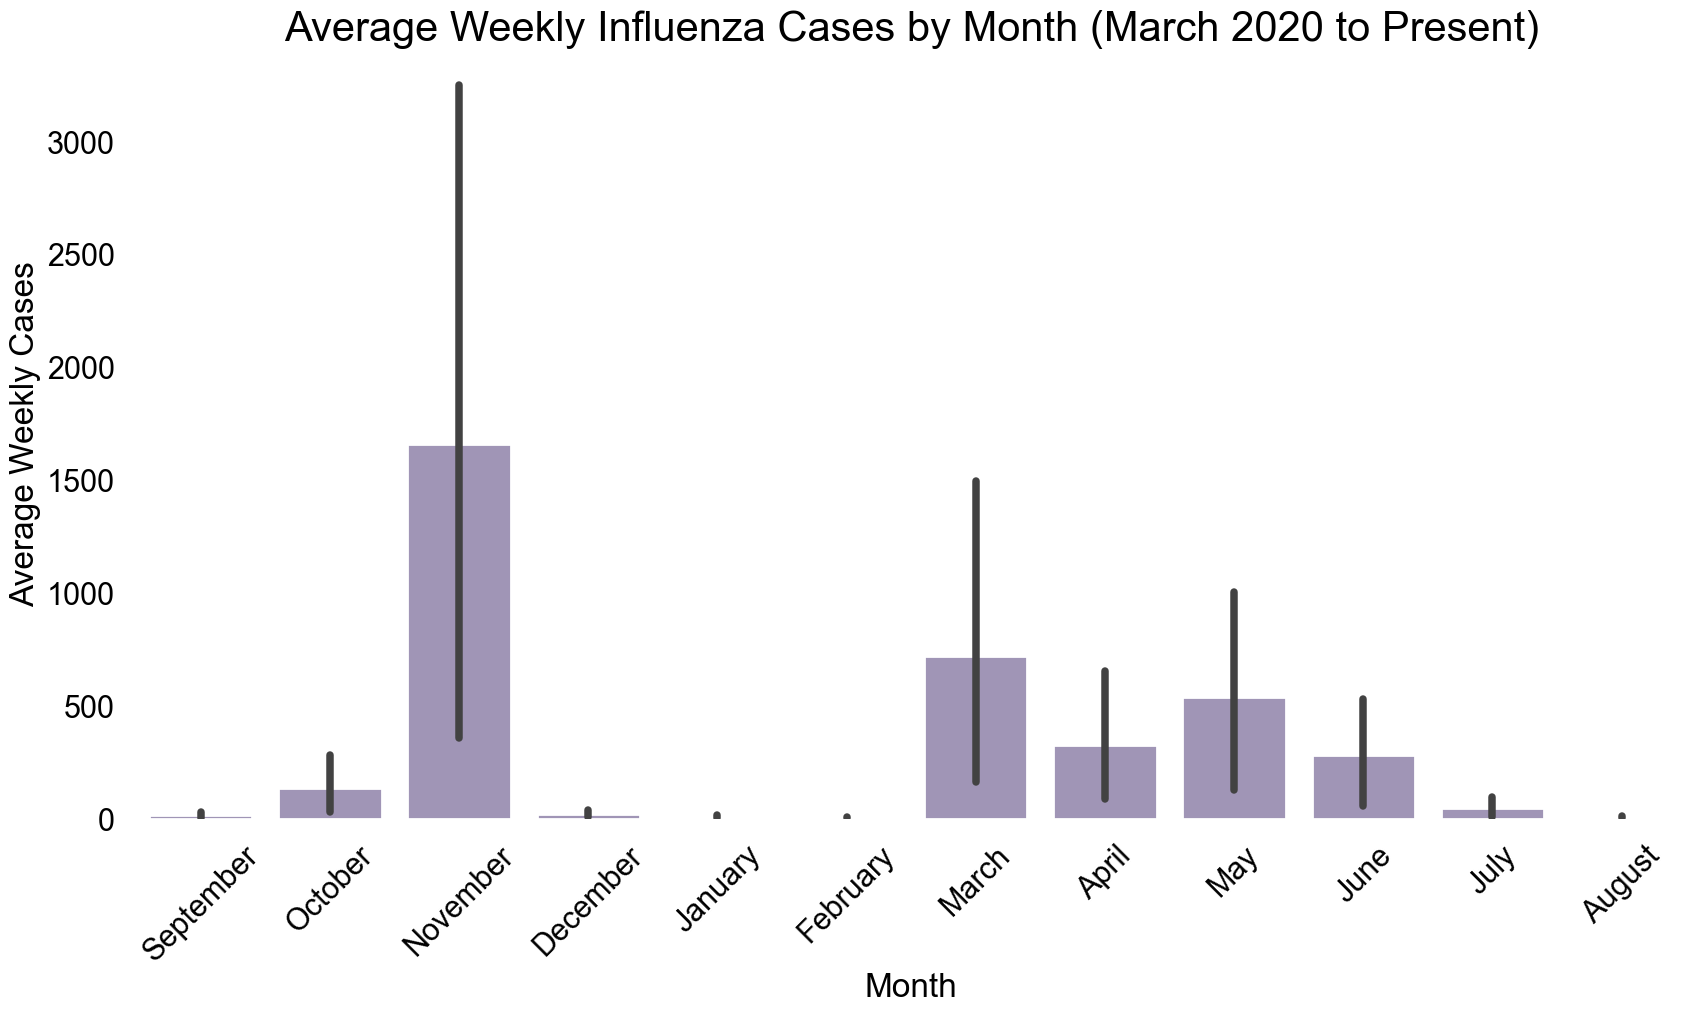

In [17]:
fig, ax = plt.subplots()
sns.barplot(data=df_month_COVID, x='month_name', y='y1', color='mediumpurple', saturation=0.3)
ax.set_ylabel('Average Weekly Cases')
ax.set_xlabel('Month')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Average Weekly Influenza Cases by Month (March 2020 to Present)', fontsize= 30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

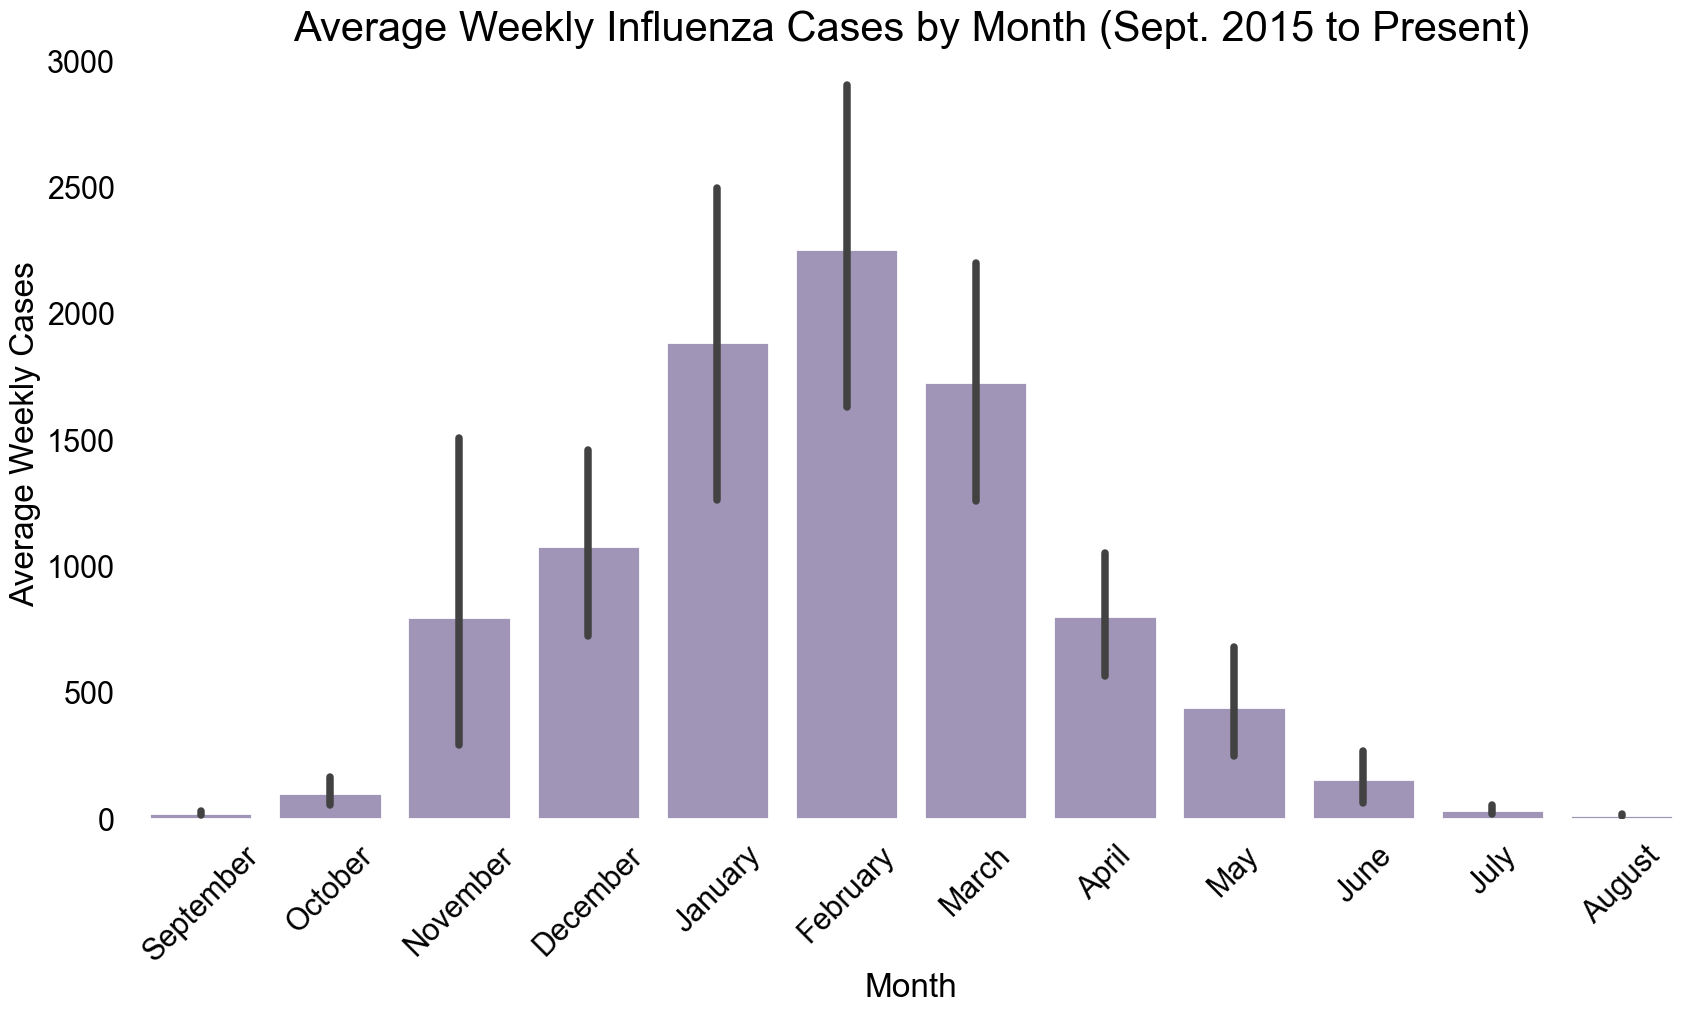

In [74]:
fig, ax = plt.subplots()
sns.barplot(data=df_month, x='month_name', y='y1', color='mediumpurple', saturation=0.3)
ax.set_ylabel('Average Weekly Cases')
ax.set_xlabel('Month')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Average Weekly Influenza Cases by Month (Sept. 2015 to Present)', fontsize= 30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

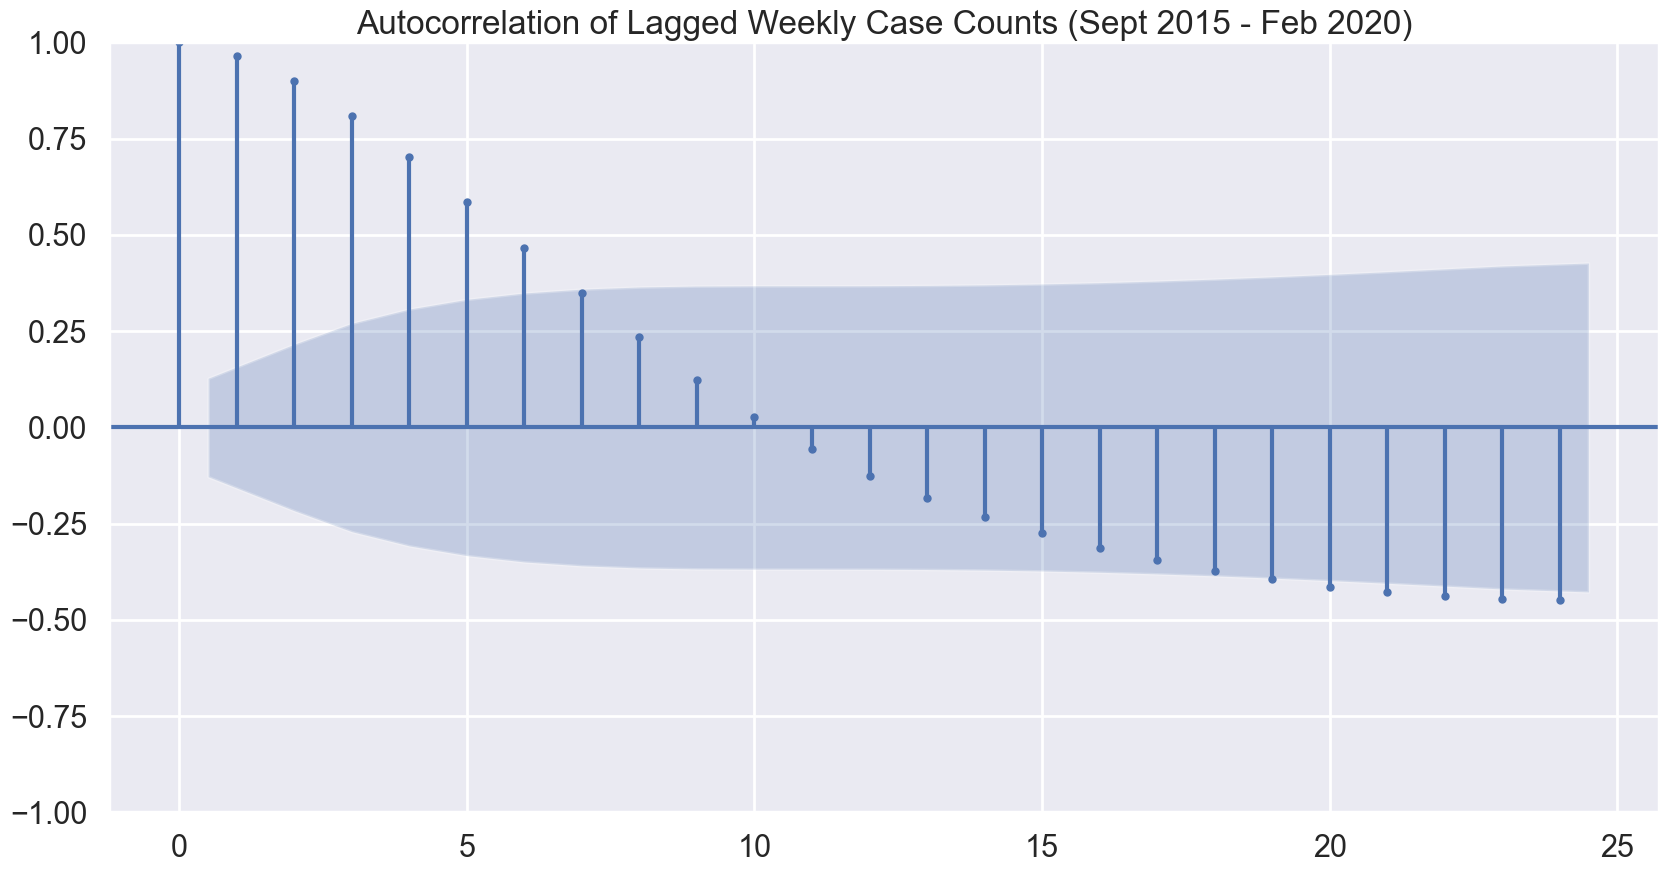

In [23]:
plot_acf(df_flu_pre_COVID, title = 'Autocorrelation of Lagged Weekly Case Counts (Sept 2015 - Feb 2020)');

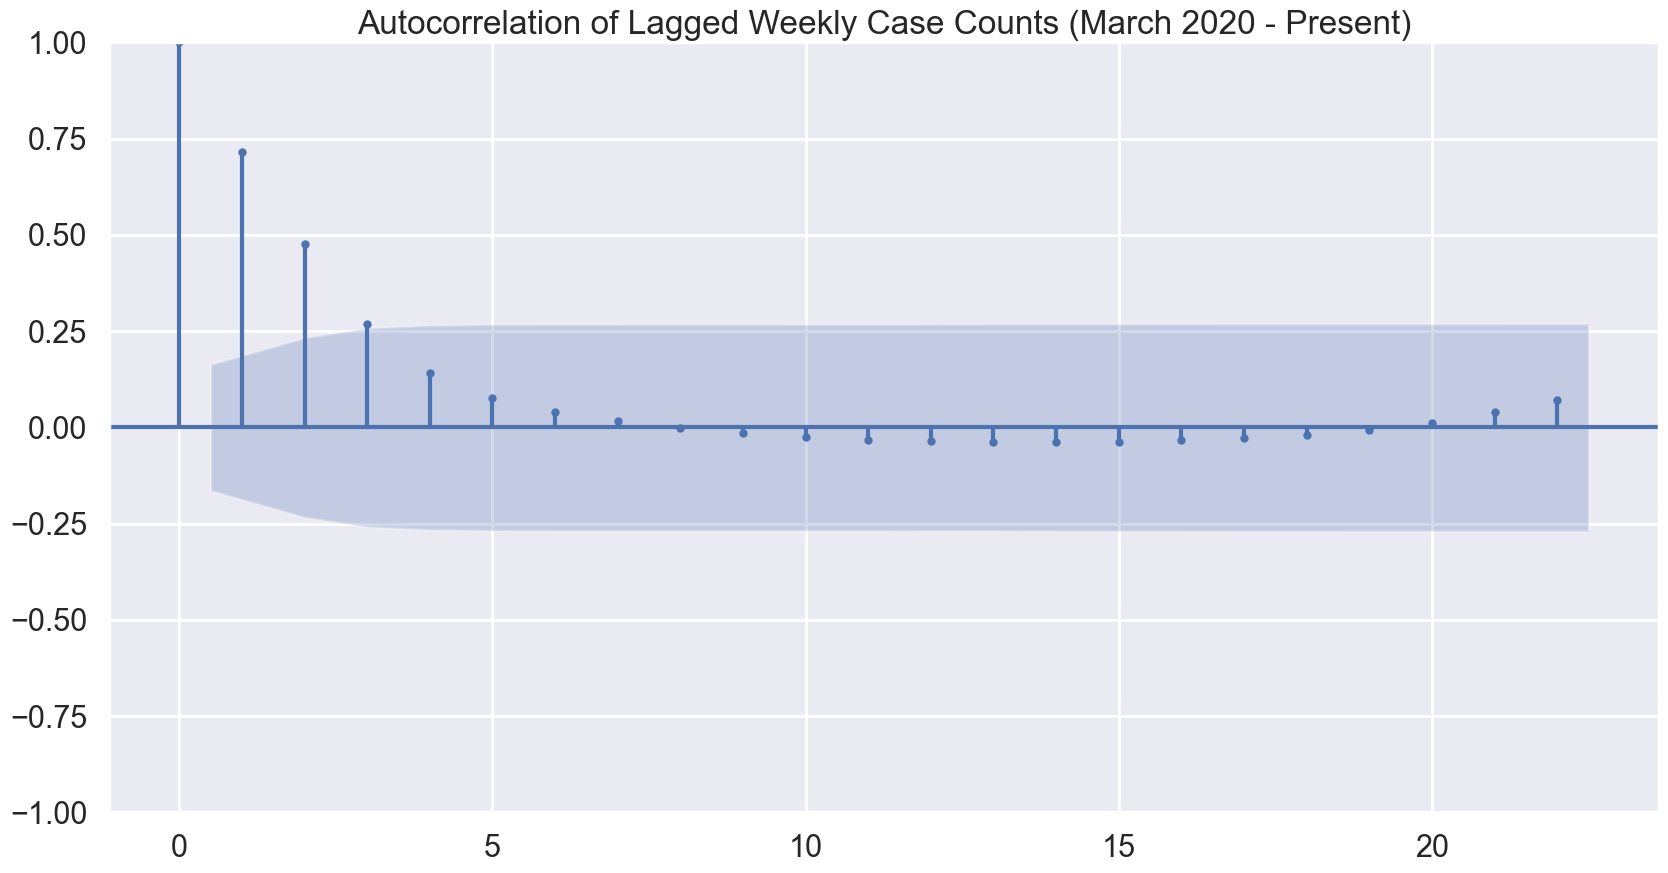

In [24]:
plot_acf(df_flu_COVID, title = 'Autocorrelation of Lagged Weekly Case Counts (March 2020 - Present)');

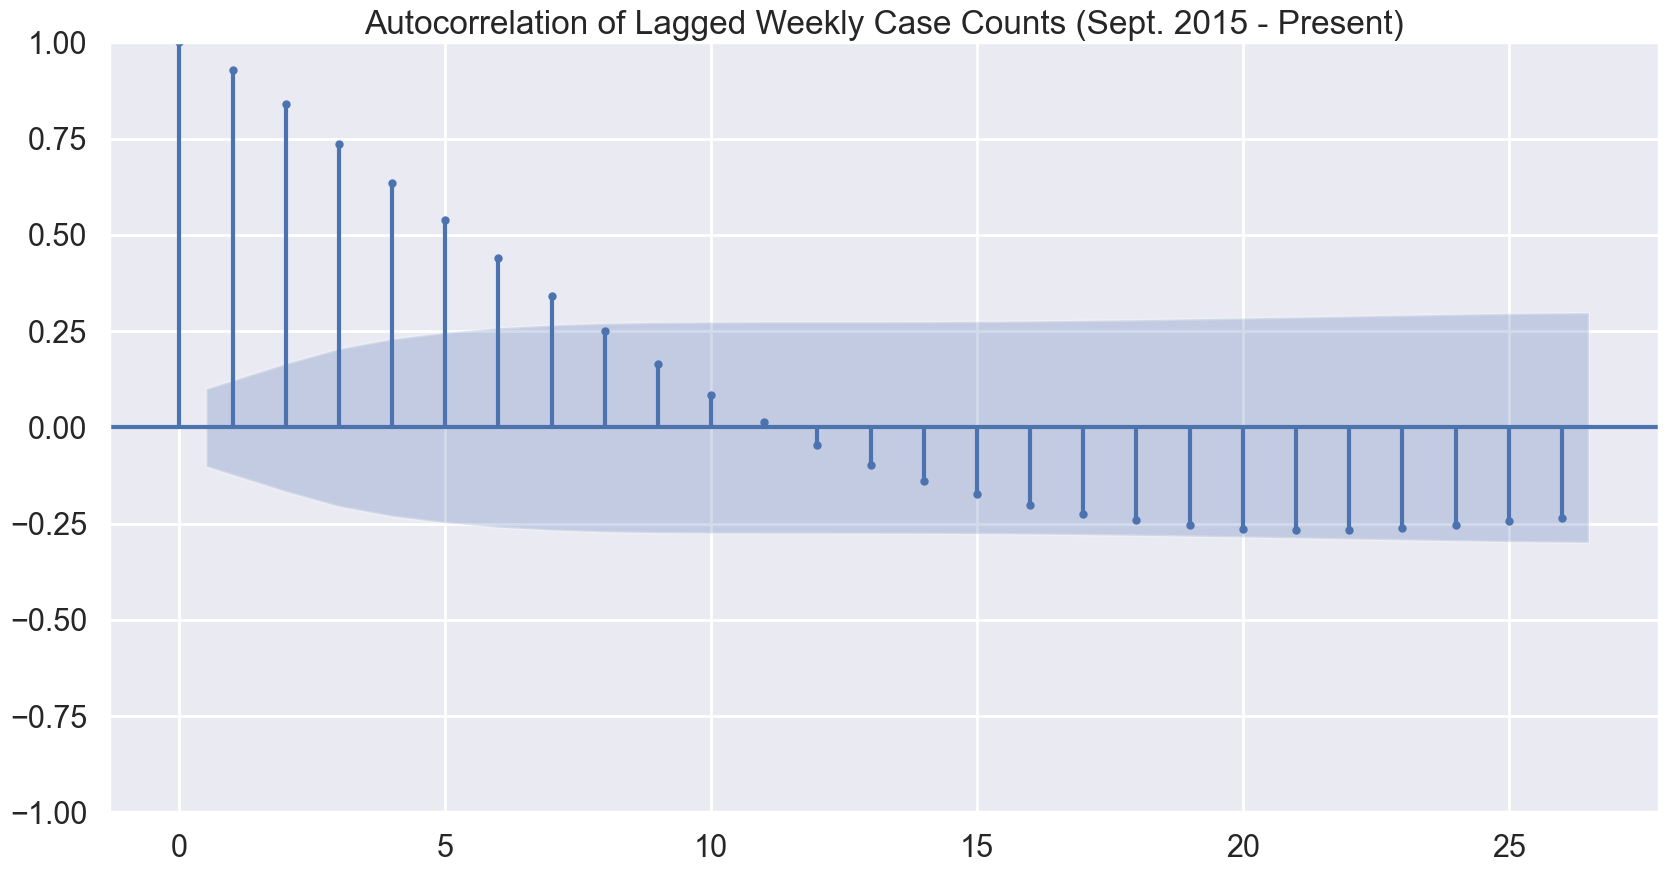

In [25]:
# Autocorrelation

plot_acf(df_flu, title = 'Autocorrelation of Lagged Weekly Case Counts (Sept. 2015 - Present)');

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


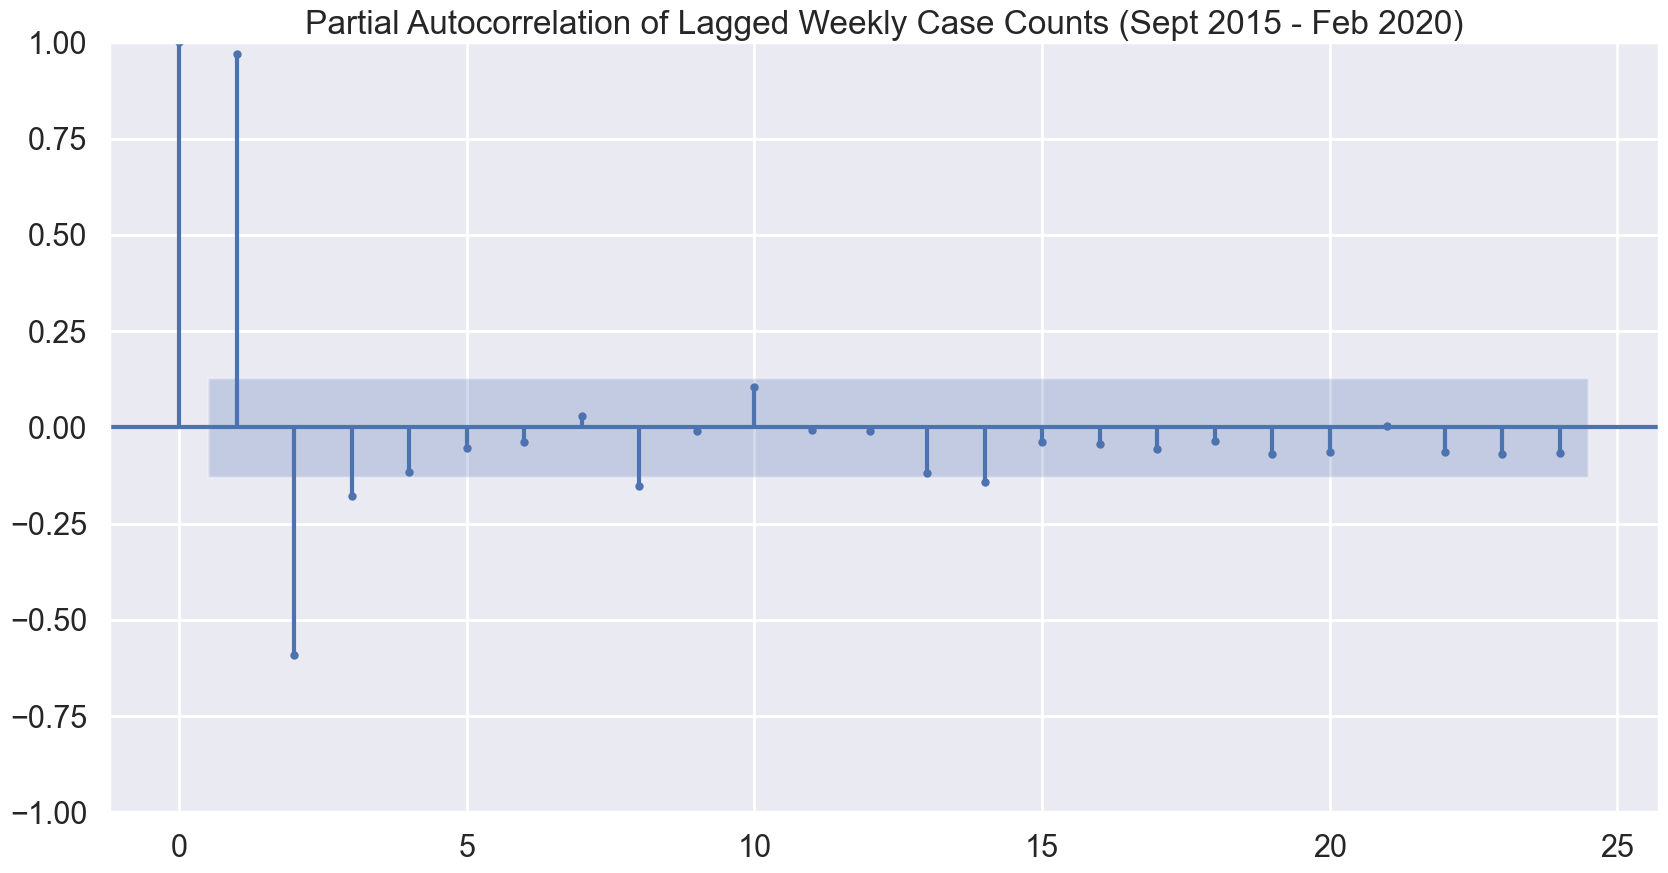

In [26]:
# Partial Autocorrelation

plot_pacf(df_flu_pre_COVID, title = 'Partial Autocorrelation of Lagged Weekly Case Counts (Sept 2015 - Feb 2020)');

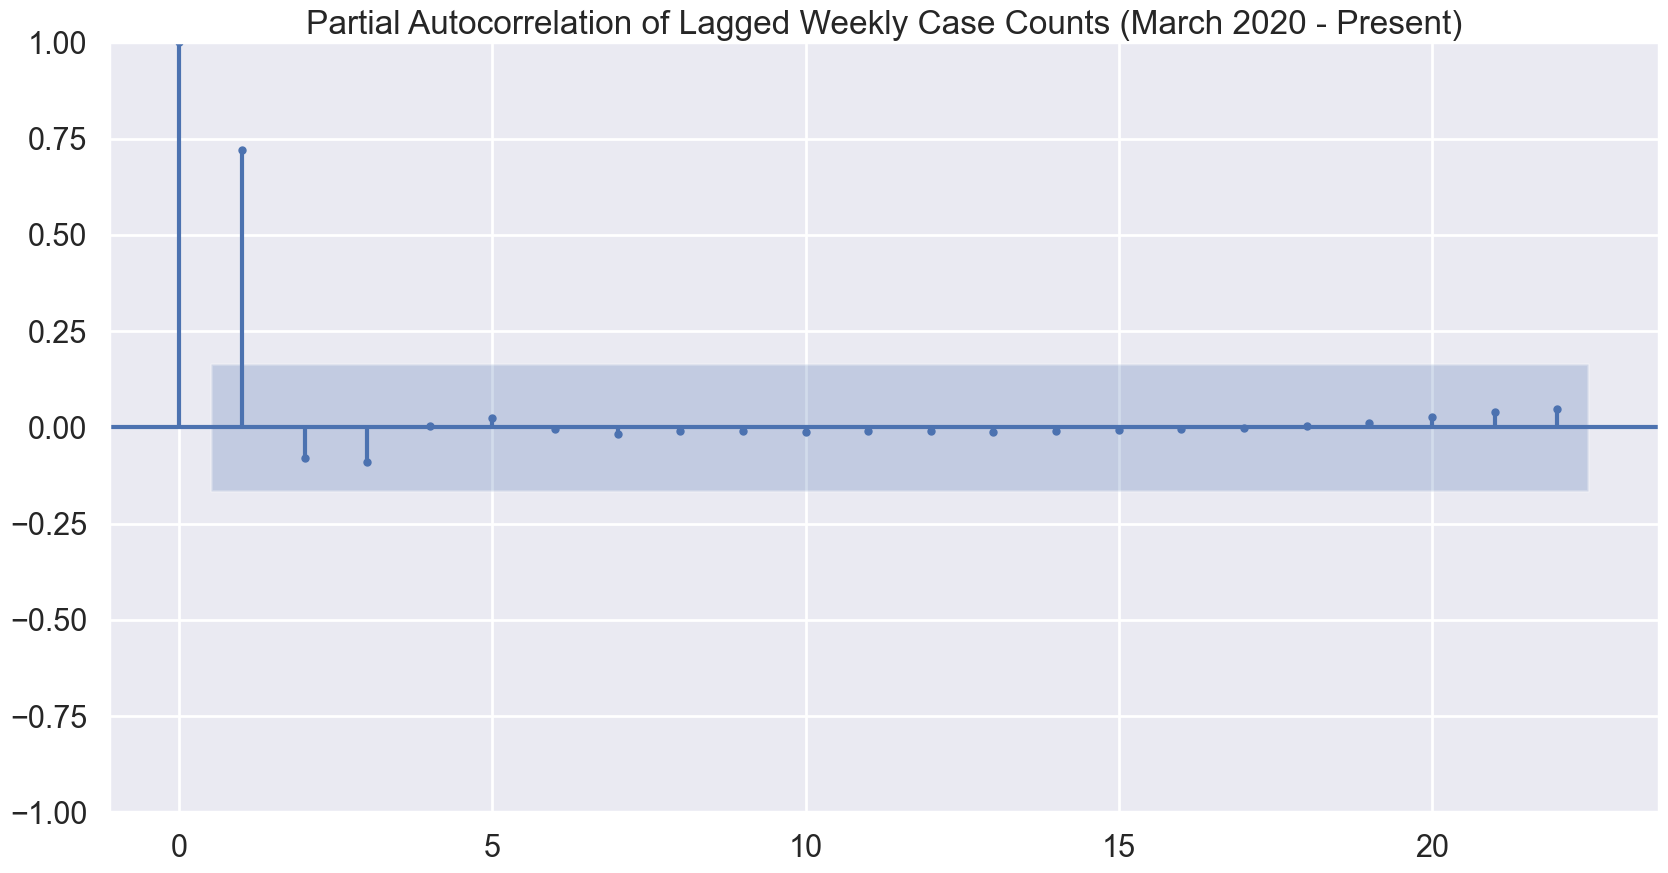

In [27]:
# Partial Autocorrelation

plot_pacf(df_flu_COVID, title = 'Partial Autocorrelation of Lagged Weekly Case Counts (March 2020 - Present)');

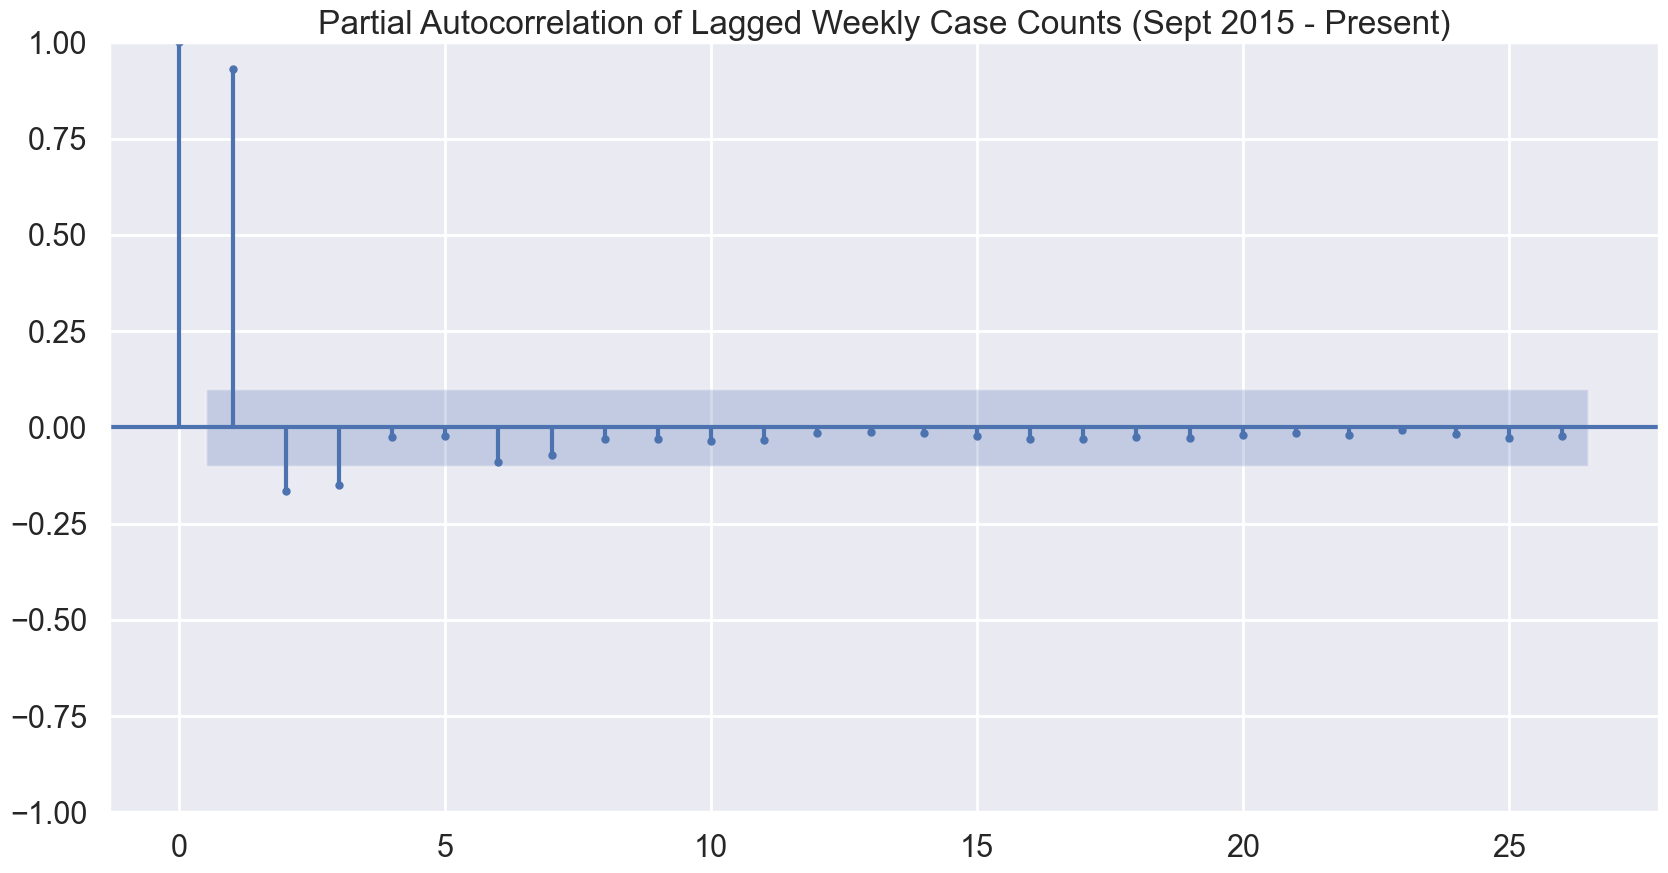

In [28]:
# Partial Autocorrelation

plot_pacf(df_flu, title = 'Partial Autocorrelation of Lagged Weekly Case Counts (Sept 2015 - Present)');

In [29]:
rolling = df_flu['y1'].rolling(2)
df_flu.rename(columns={'y1':'Total Cases'}, inplace=True)
df_flu['2-week moving average'] = rolling.mean()
df_flu['2-week moving std'] = rolling.std()
df_flu.head(10)

Total Cases  2-week moving average  2-week moving std
Week Ending                                                       
2015-09-05           9.0                    NaN                NaN
2015-09-12          18.0                   13.5           6.363961
2015-09-19          15.0                   16.5           2.121320
2015-09-26          29.0                   22.0           9.899495
2015-10-03          59.0                   44.0          21.213203
2015-10-10          50.0                   54.5           6.363961
2015-10-17          37.0                   43.5           9.192388
2015-10-24          26.0                   31.5           7.778175
2015-10-31          26.0                   26.0           0.000000
2015-11-07          40.0                   33.0           9.899495

Text(0.5, 1.0, 'Two Week Moving Average and Standard Deviation')

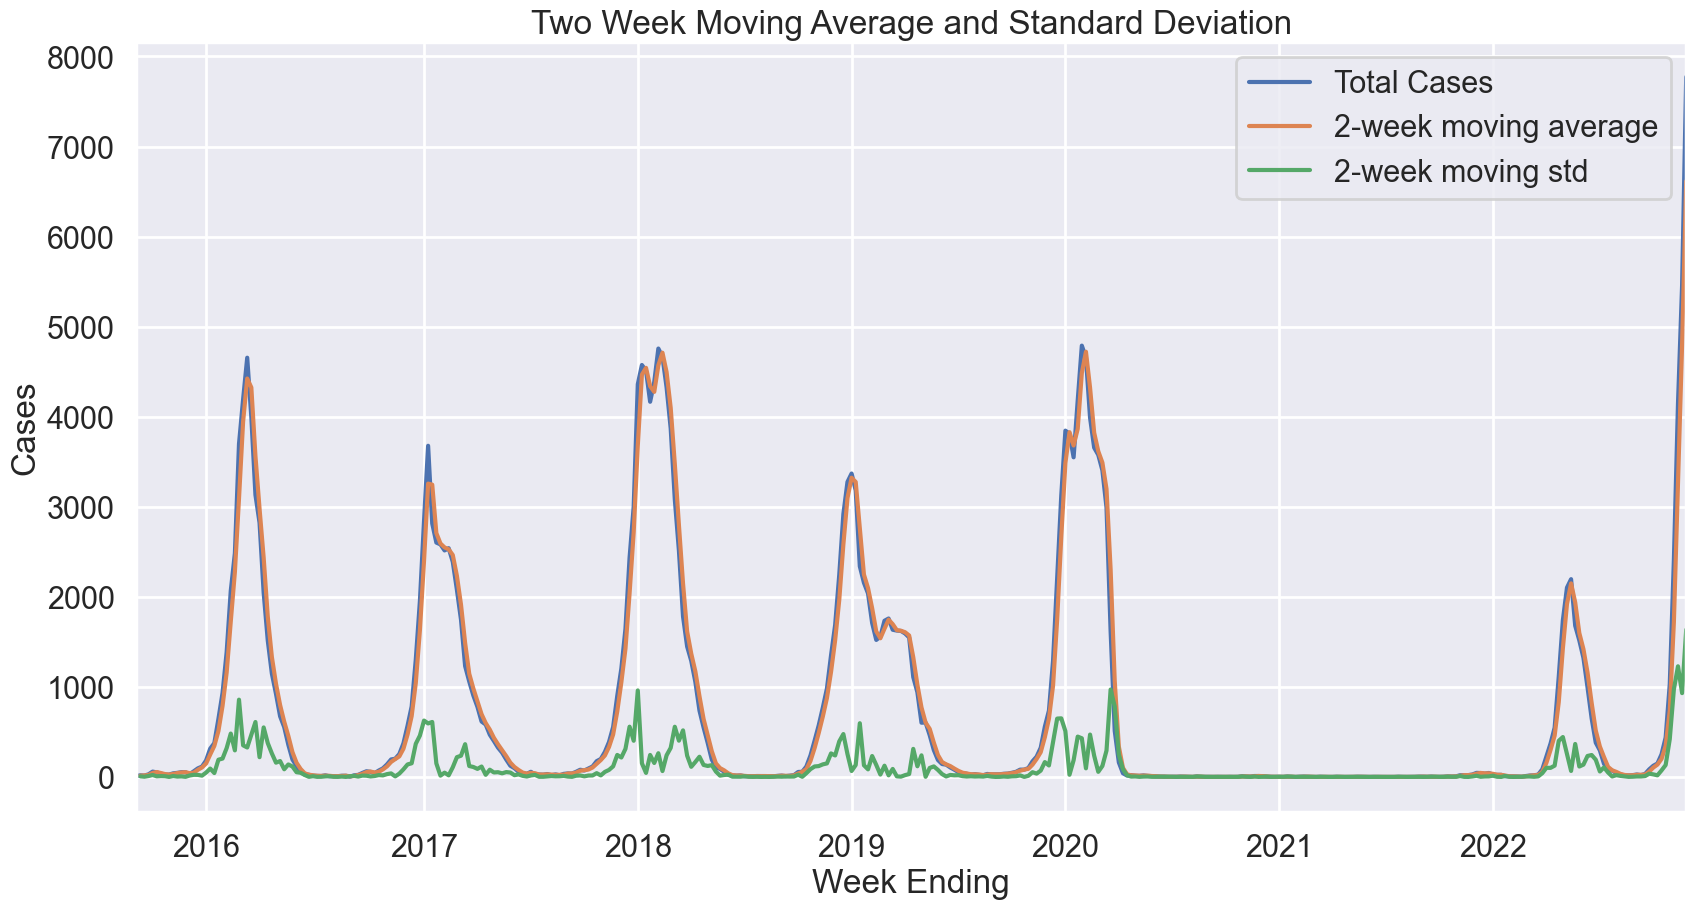

In [30]:
df_flu.plot()
plt.ylabel('Cases')
plt.title('Two Week Moving Average and Standard Deviation')

Text(0.5, 1.0, 'Four Week Moving Average and Standard Deviation')

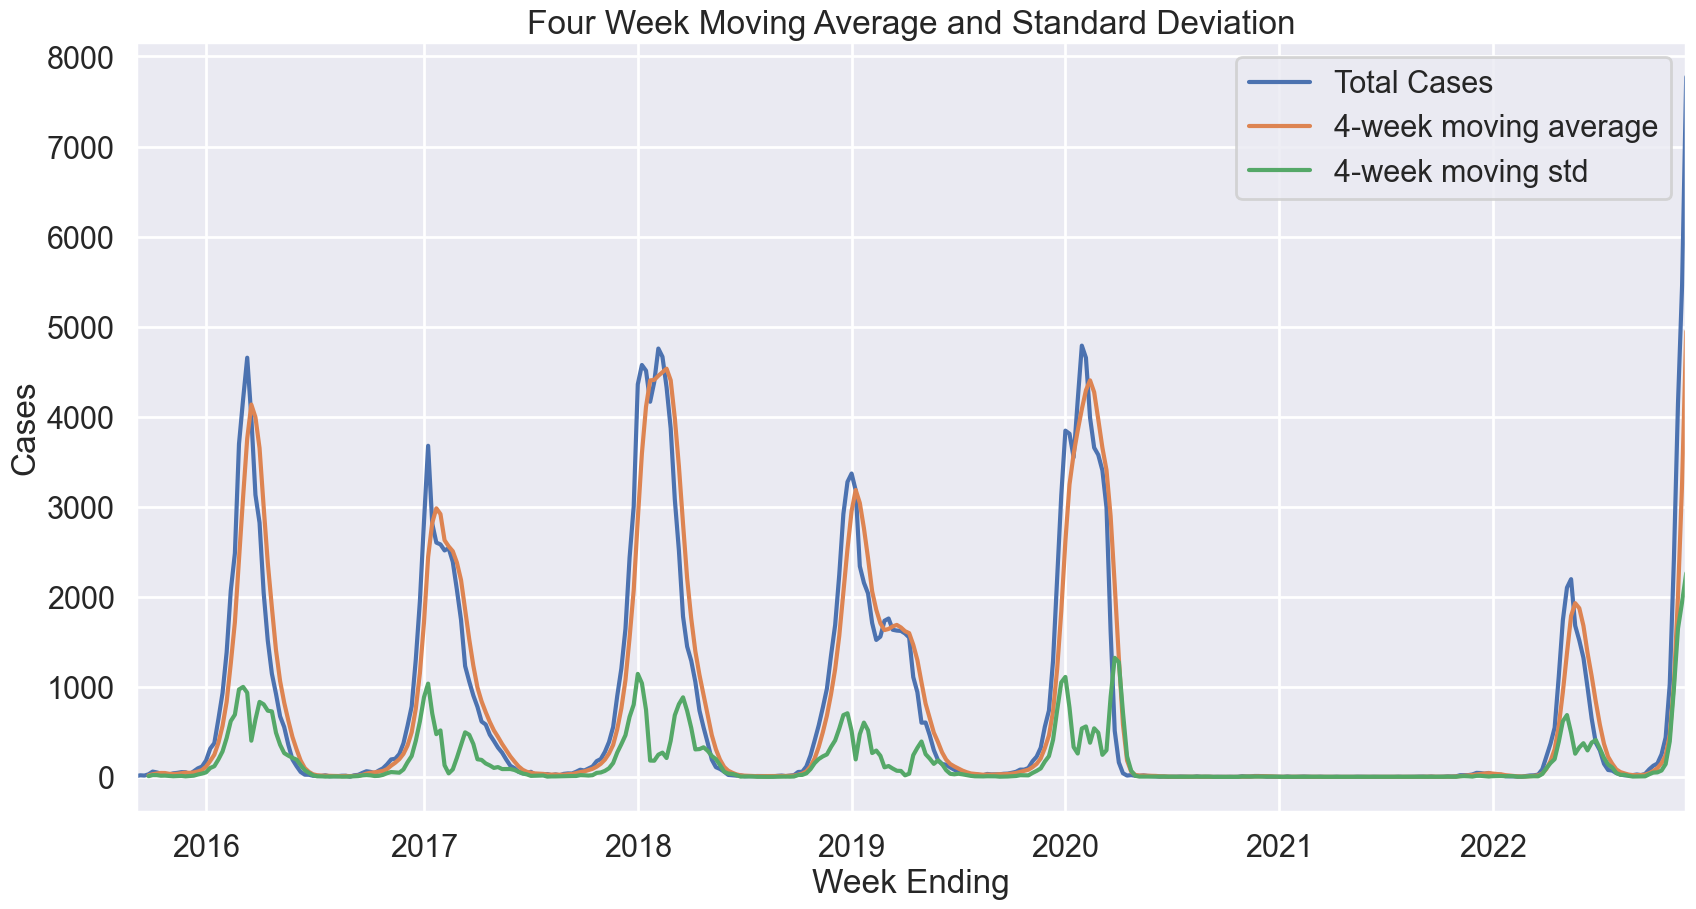

In [31]:
rolling = df_flu['Total Cases'].rolling(4)
df_flu['4-week moving average'] = rolling.mean()
df_flu['4-week moving std'] = rolling.std()
ax = df_flu.iloc[:,[0,3,4]].plot()

plt.ylabel('Cases')
plt.title('Four Week Moving Average and Standard Deviation')

Text(0.5, 1.0, 'Six Week Moving Average and Standard Deviation')

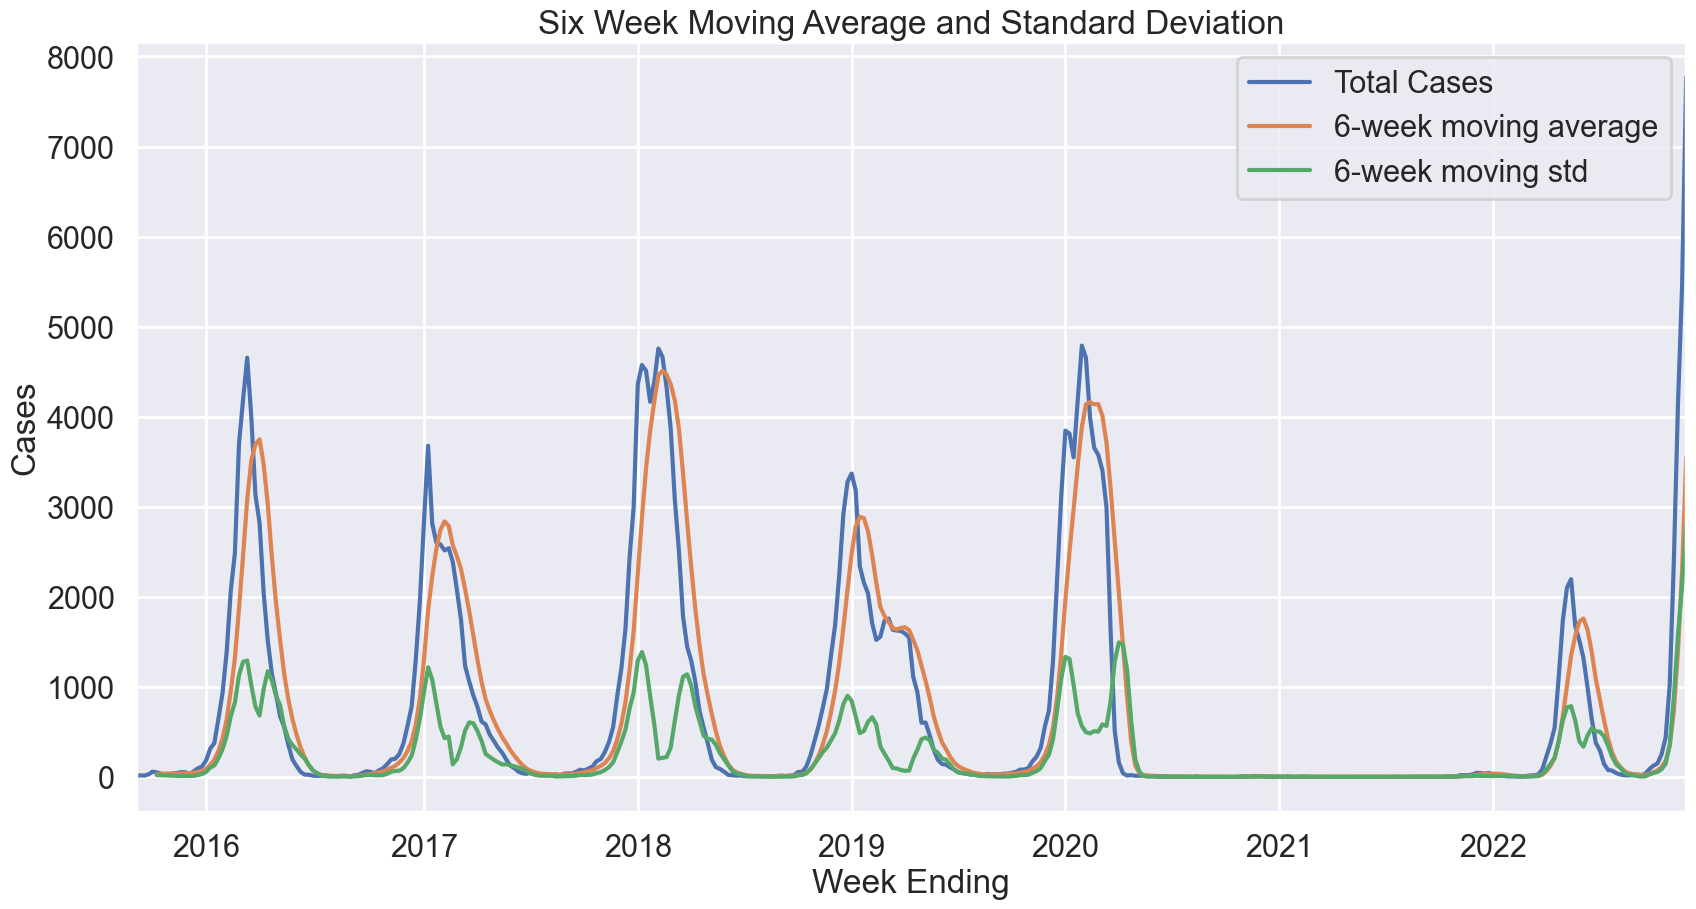

In [32]:
rolling = df_flu['Total Cases'].rolling(6)
df_flu['6-week moving average'] = rolling.mean()
df_flu['6-week moving std'] = rolling.std()
ax = df_flu.iloc[:,[0,5,6]].plot()

plt.ylabel('Cases')
plt.title('Six Week Moving Average and Standard Deviation')

Text(0.5, 1.0, 'Eight Week Moving Average and Standard Deviation')

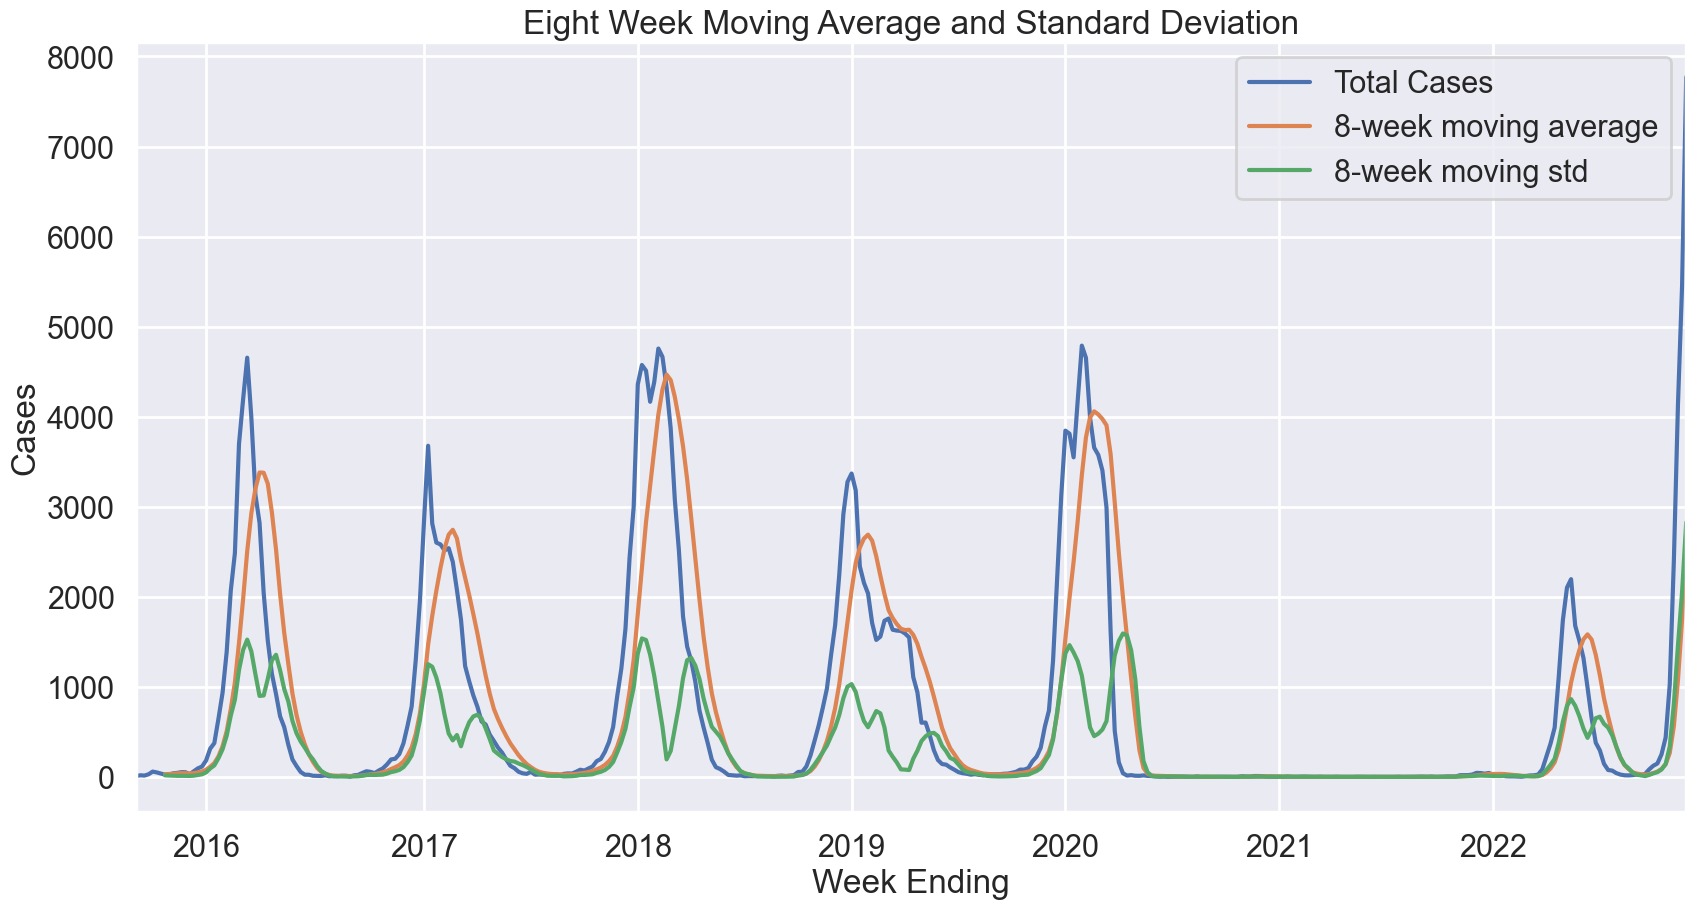

In [33]:
rolling = df_flu['Total Cases'].rolling(8)
df_flu['8-week moving average'] = rolling.mean()
df_flu['8-week moving std'] = rolling.std()
ax = df_flu.iloc[:,[0,7,8]].plot()

plt.ylabel('Cases')
plt.title('Eight Week Moving Average and Standard Deviation')

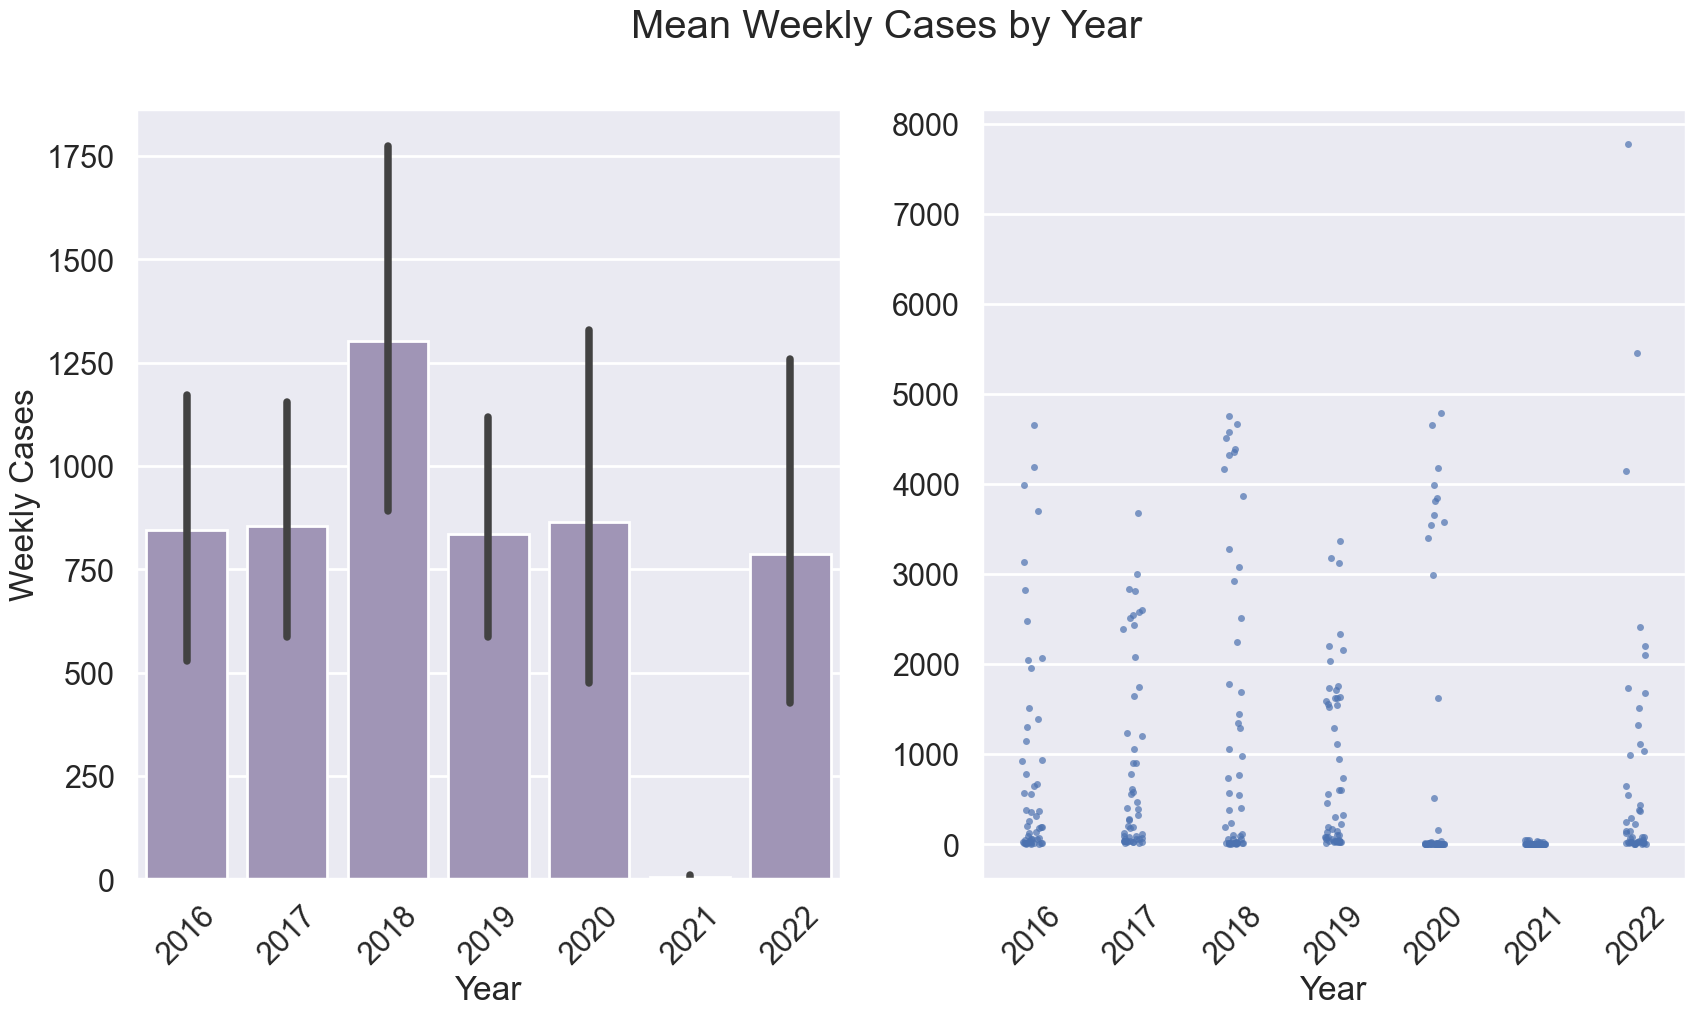

In [34]:
df_features = df_features[df_features['year'] != 2015]
plot_target_relationship(data=df_features[['year','y1']], feature='year', feature_title='Year', target_title='Weekly Cases', color='mediumpurple')

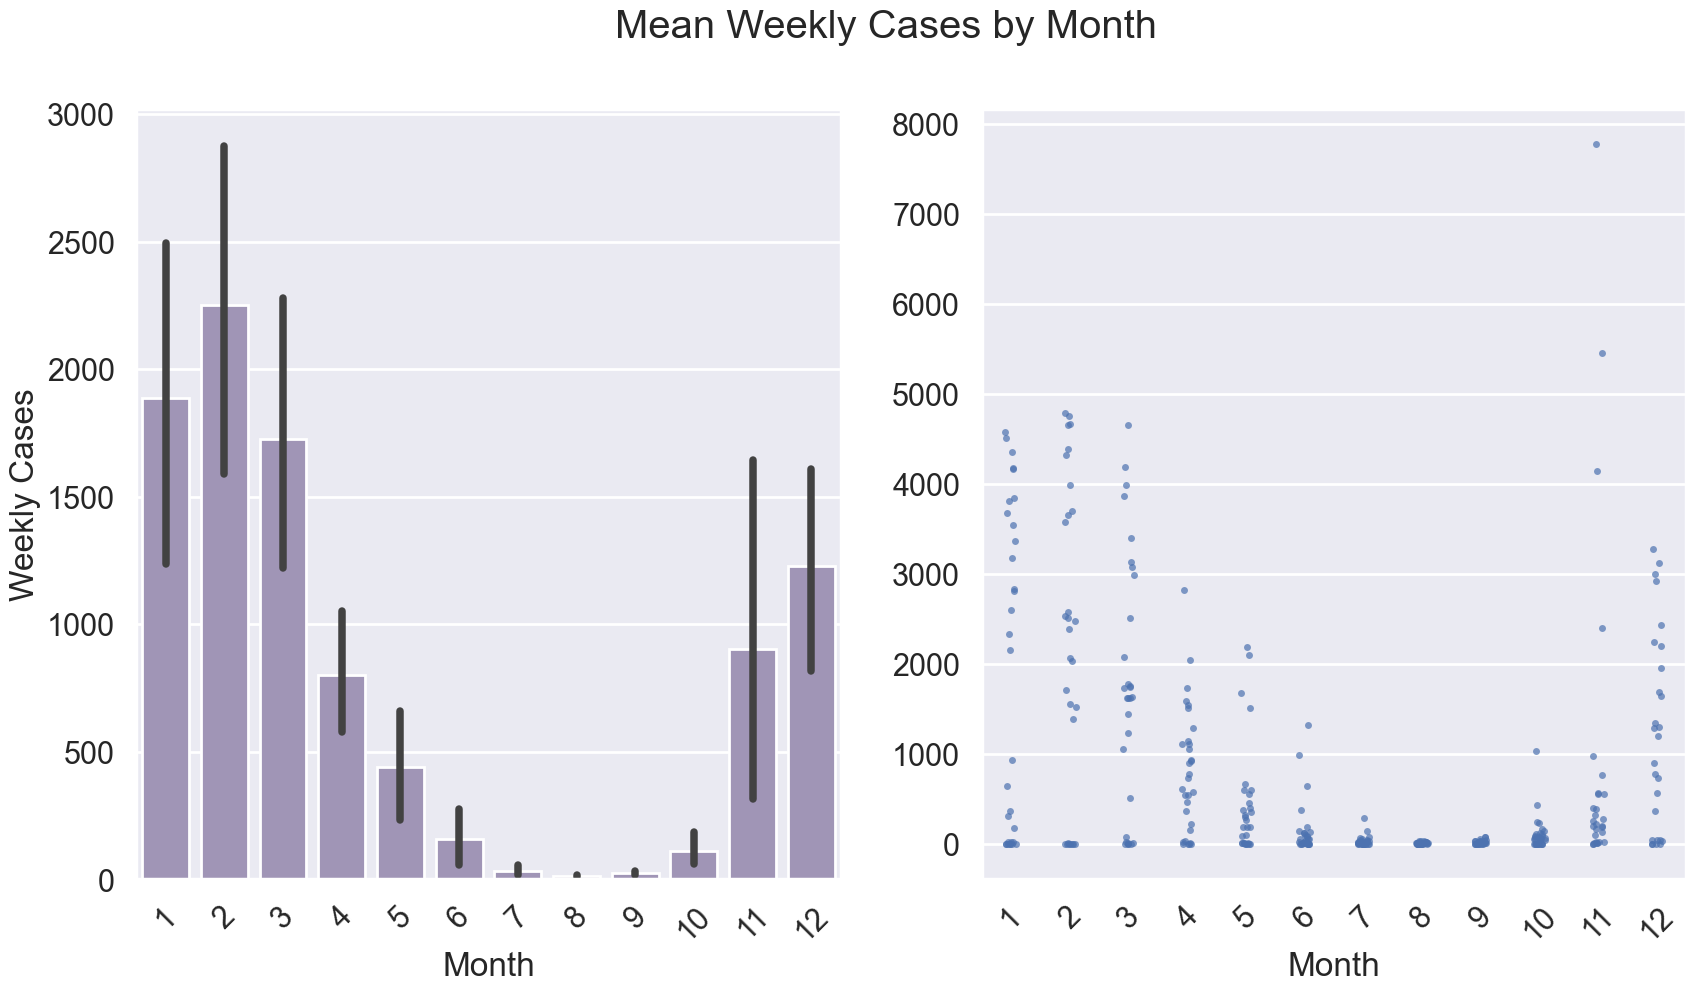

In [35]:
plot_target_relationship(data=df_features[['month','y1']], feature='month', feature_title='Month', target_title='Weekly Cases', color='mediumpurple')

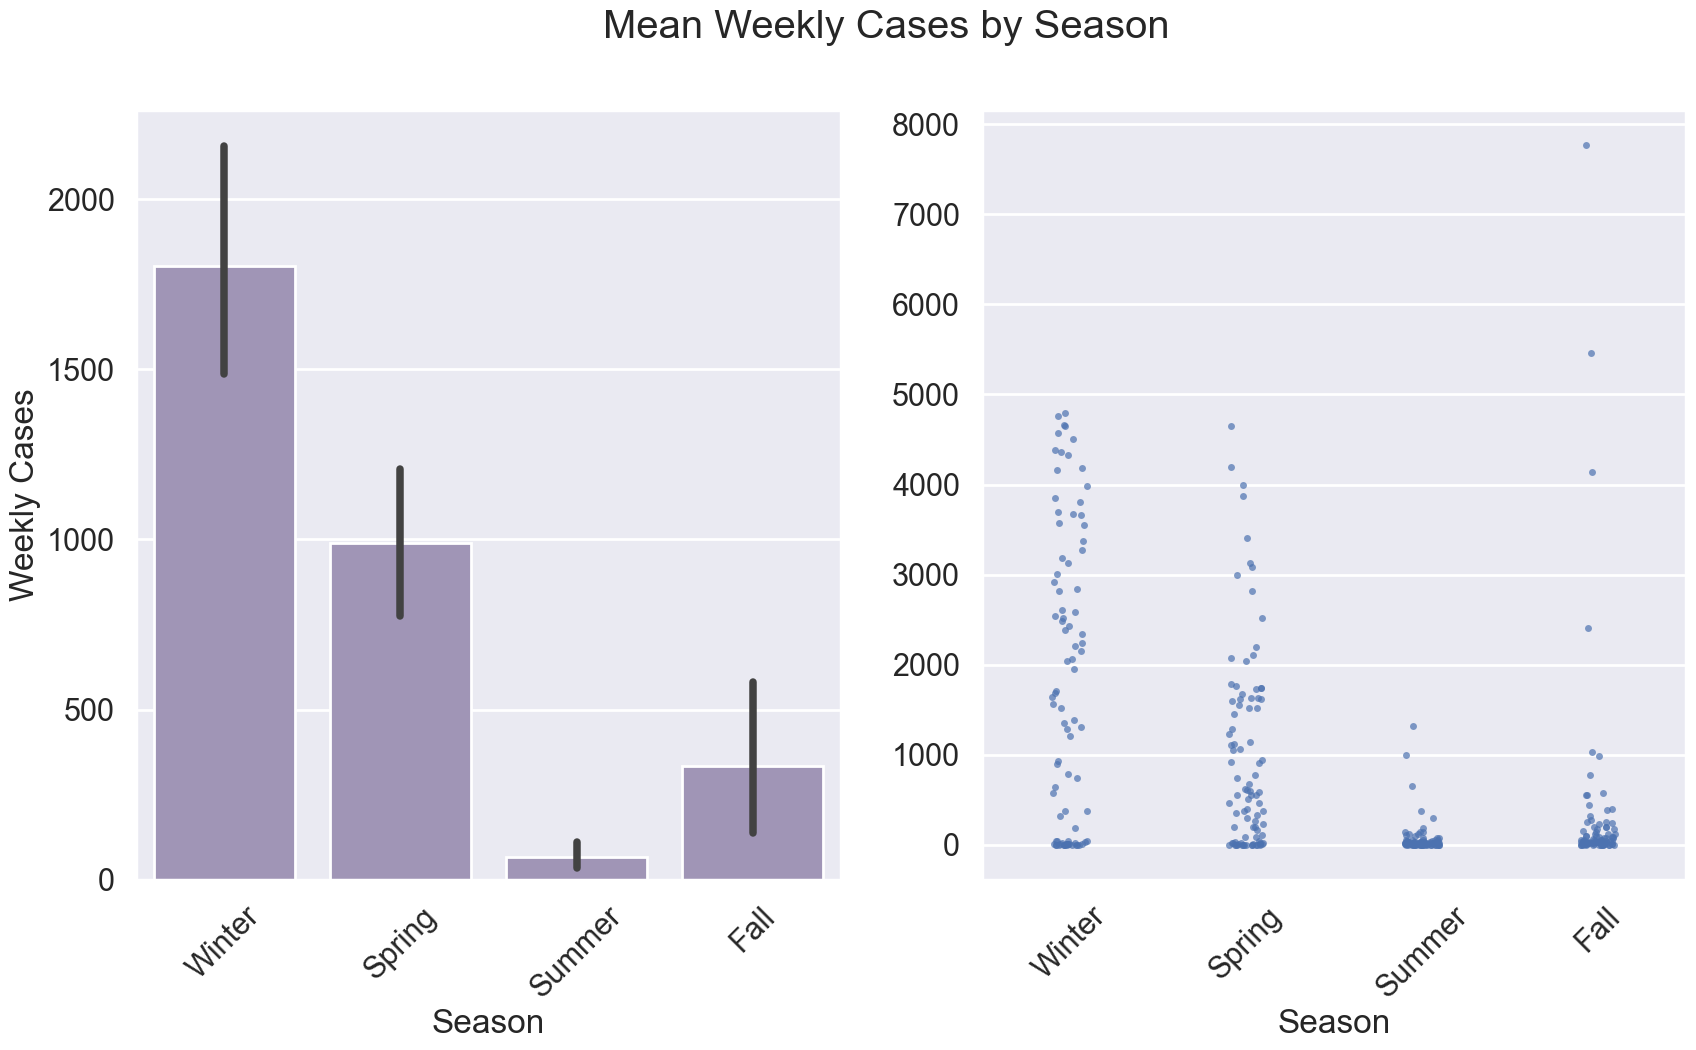

In [36]:
plot_target_relationship(data=df_features[['season','y1']], feature='season', feature_title='Season', target_title='Weekly Cases', color='mediumpurple')

# Health Indicators (Annually, 2015-2021)

In [37]:
sns.set_context(context='talk')
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = [30,15]

In [38]:
# full feature set - full time series, pre-COVID, post-COVID
df_features = pickle.load(open(r"..\data\df_flu_all_features.pkl", "rb" ))
df_features_pre_COVID = pickle.load(open(r"..\data\df_flu_pre_COVID_all_features.pkl", "rb" ))
df_features_COVID = pickle.load(open(r"..\data\df_flu_COVID_all_features.pkl", "rb" ))

<AxesSubplot: >

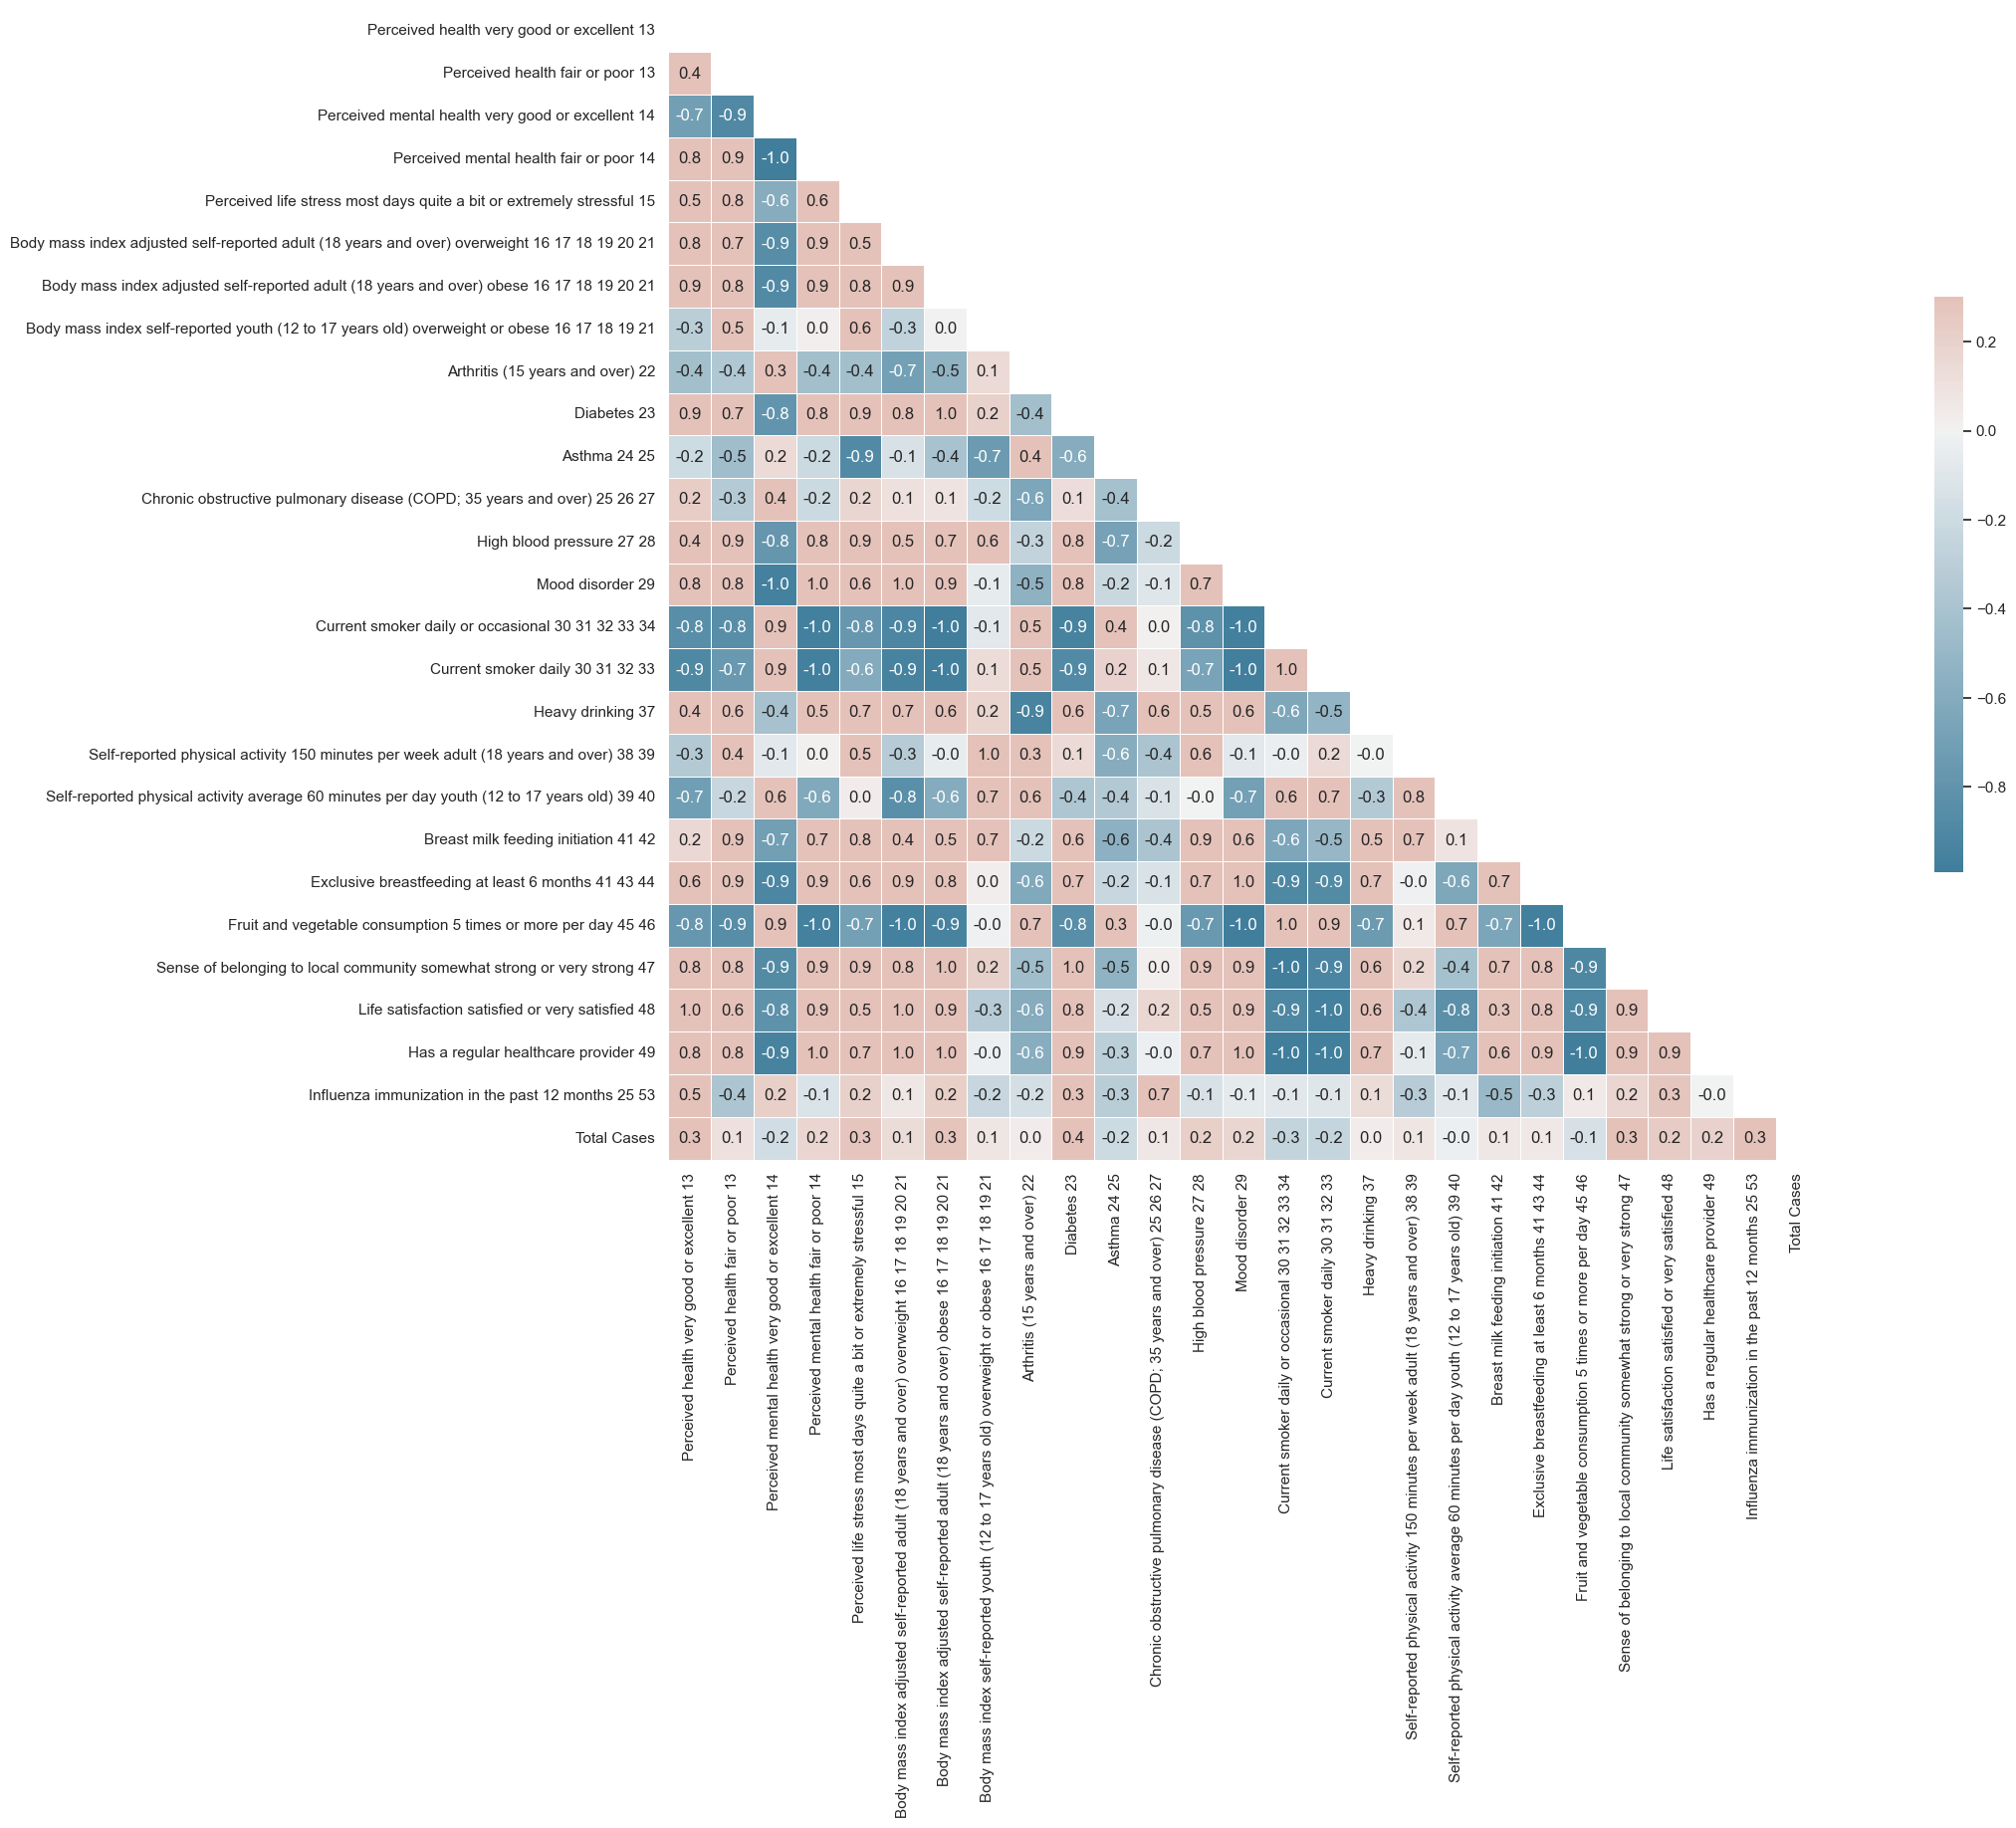

In [39]:
# examine relationship between health indicators and total flu cases PRE-COVID
indicator_list = df_health_indicators.columns[1:].to_list()
indicator_list.append('y1')
df = df_features_pre_COVID[indicator_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace = True)

corr = df.corr()

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f")

<AxesSubplot: >

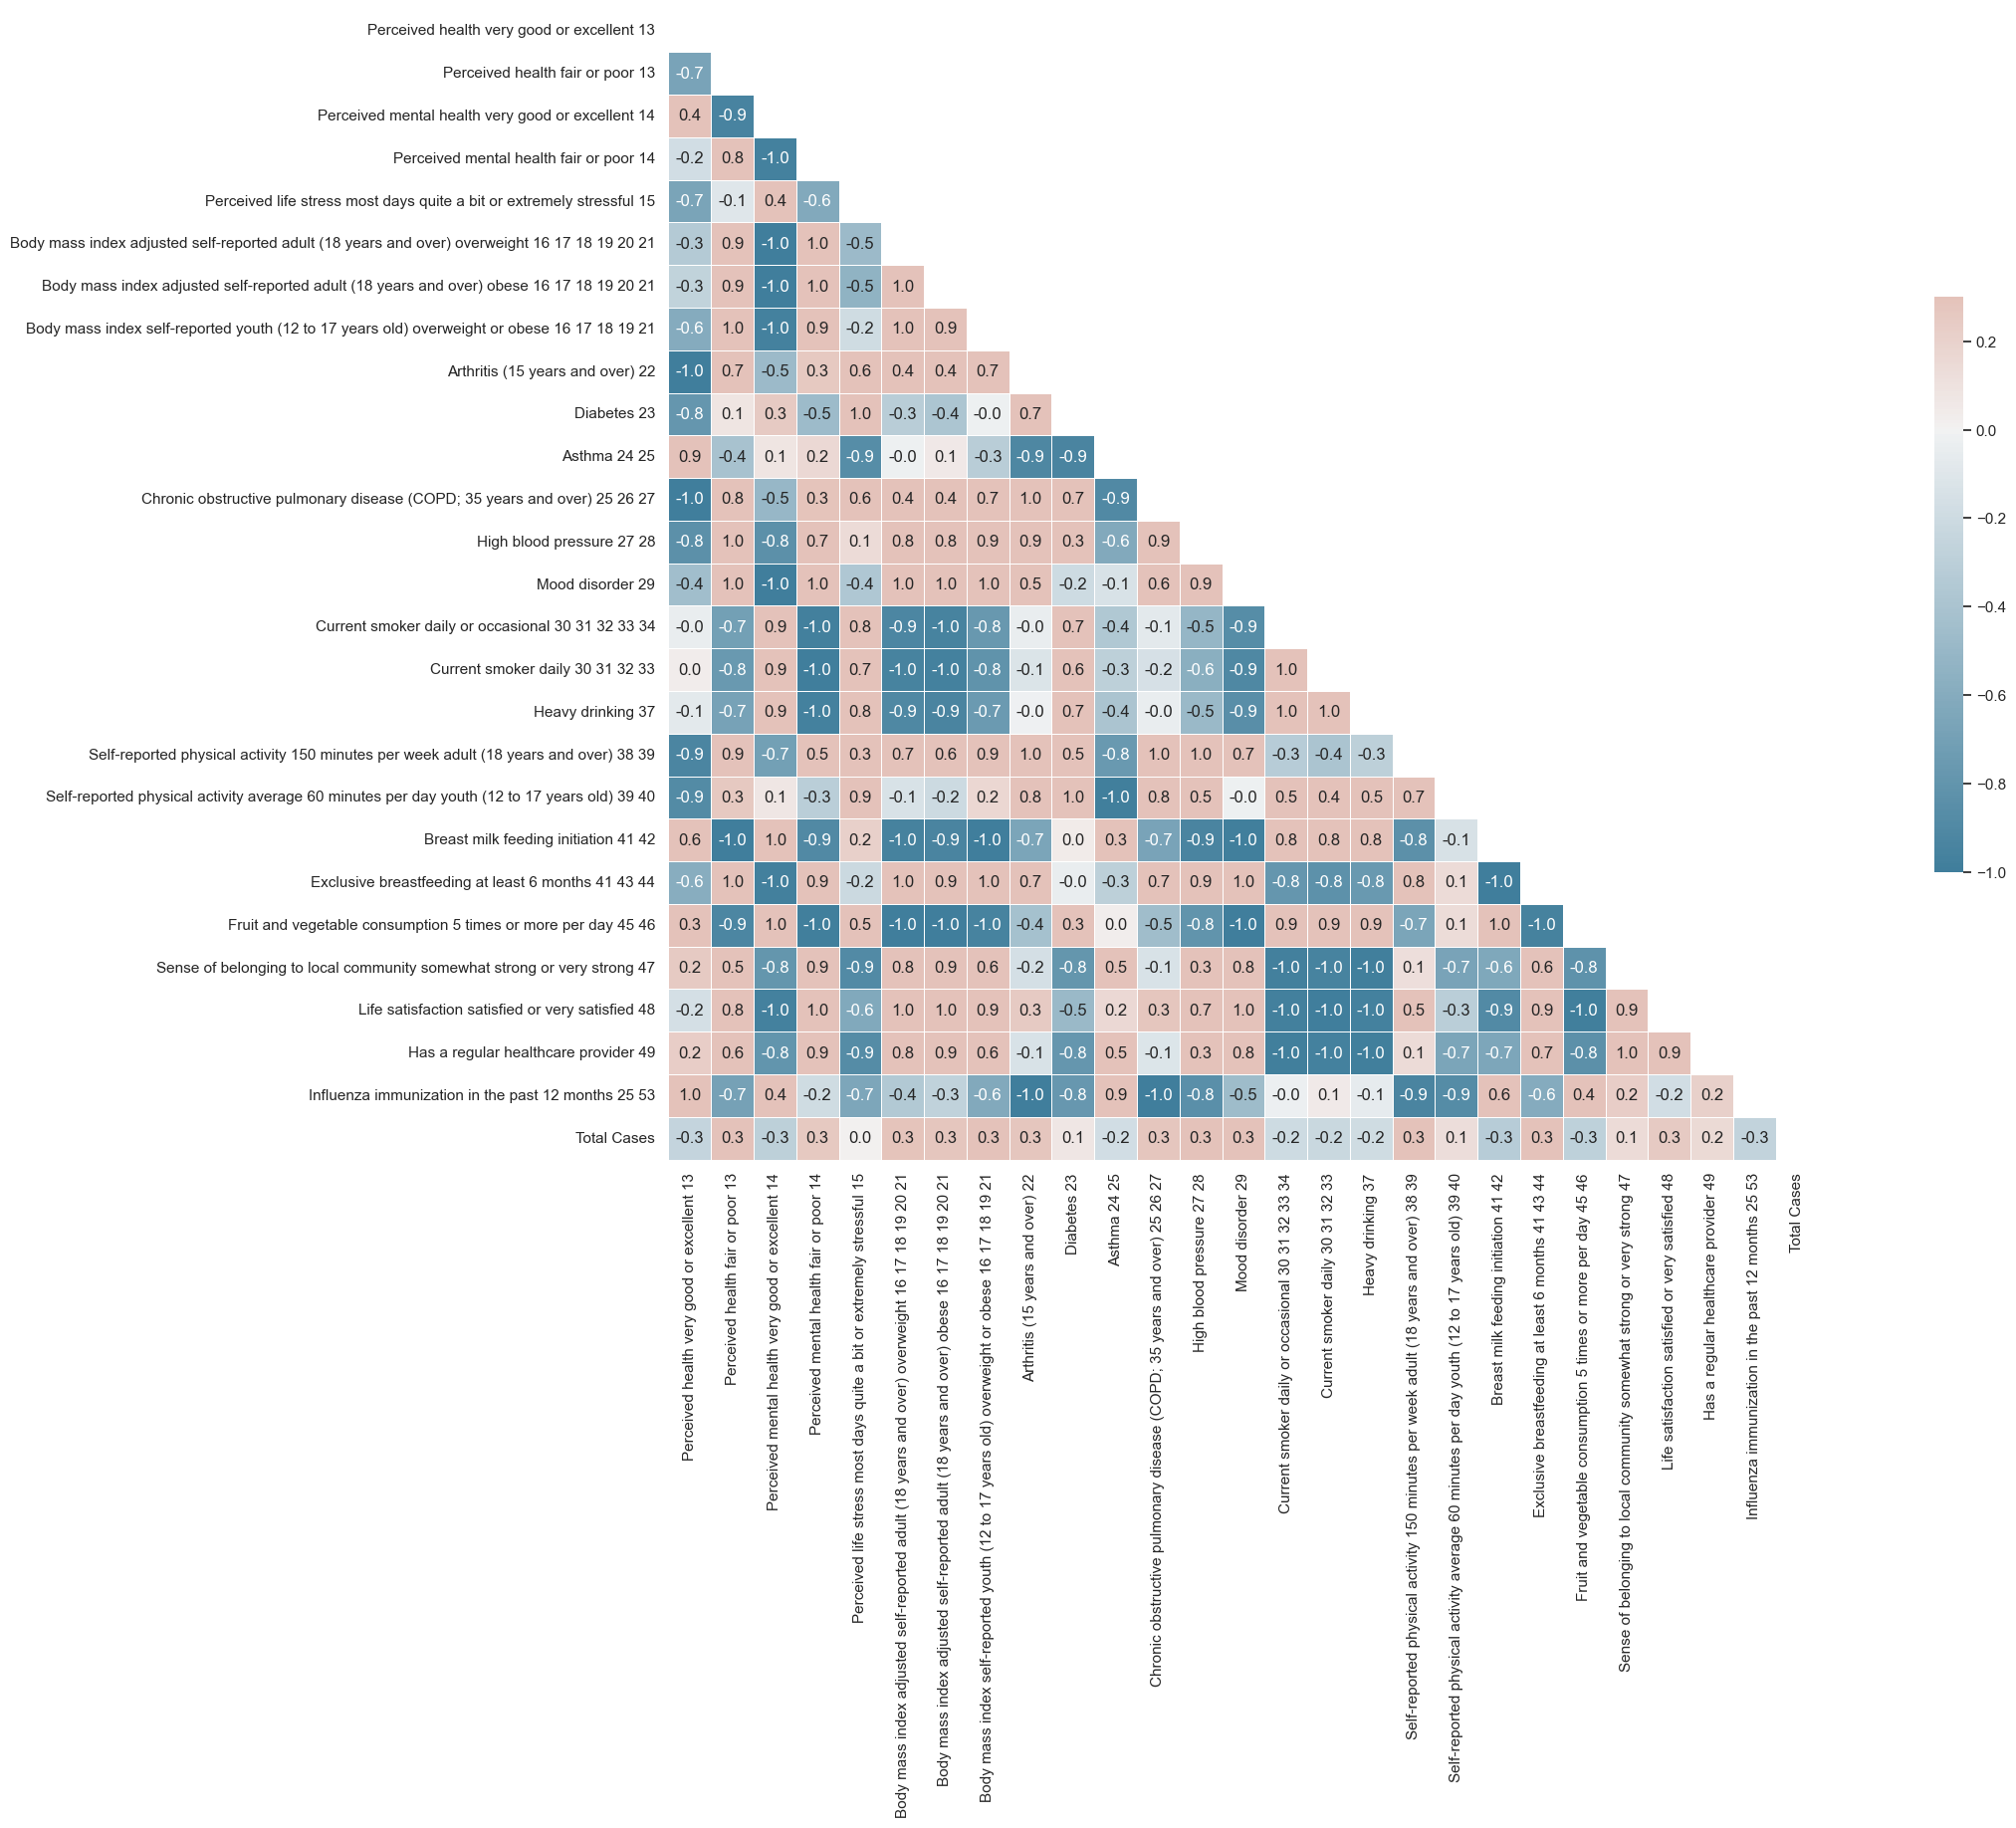

In [40]:
# examine relationship between health indicators and total flu cases SINCE COVID
indicator_list = df_health_indicators.columns[1:].to_list()
indicator_list.append('y1')
df = df_features_COVID[indicator_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace = True)

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f")

<AxesSubplot: >

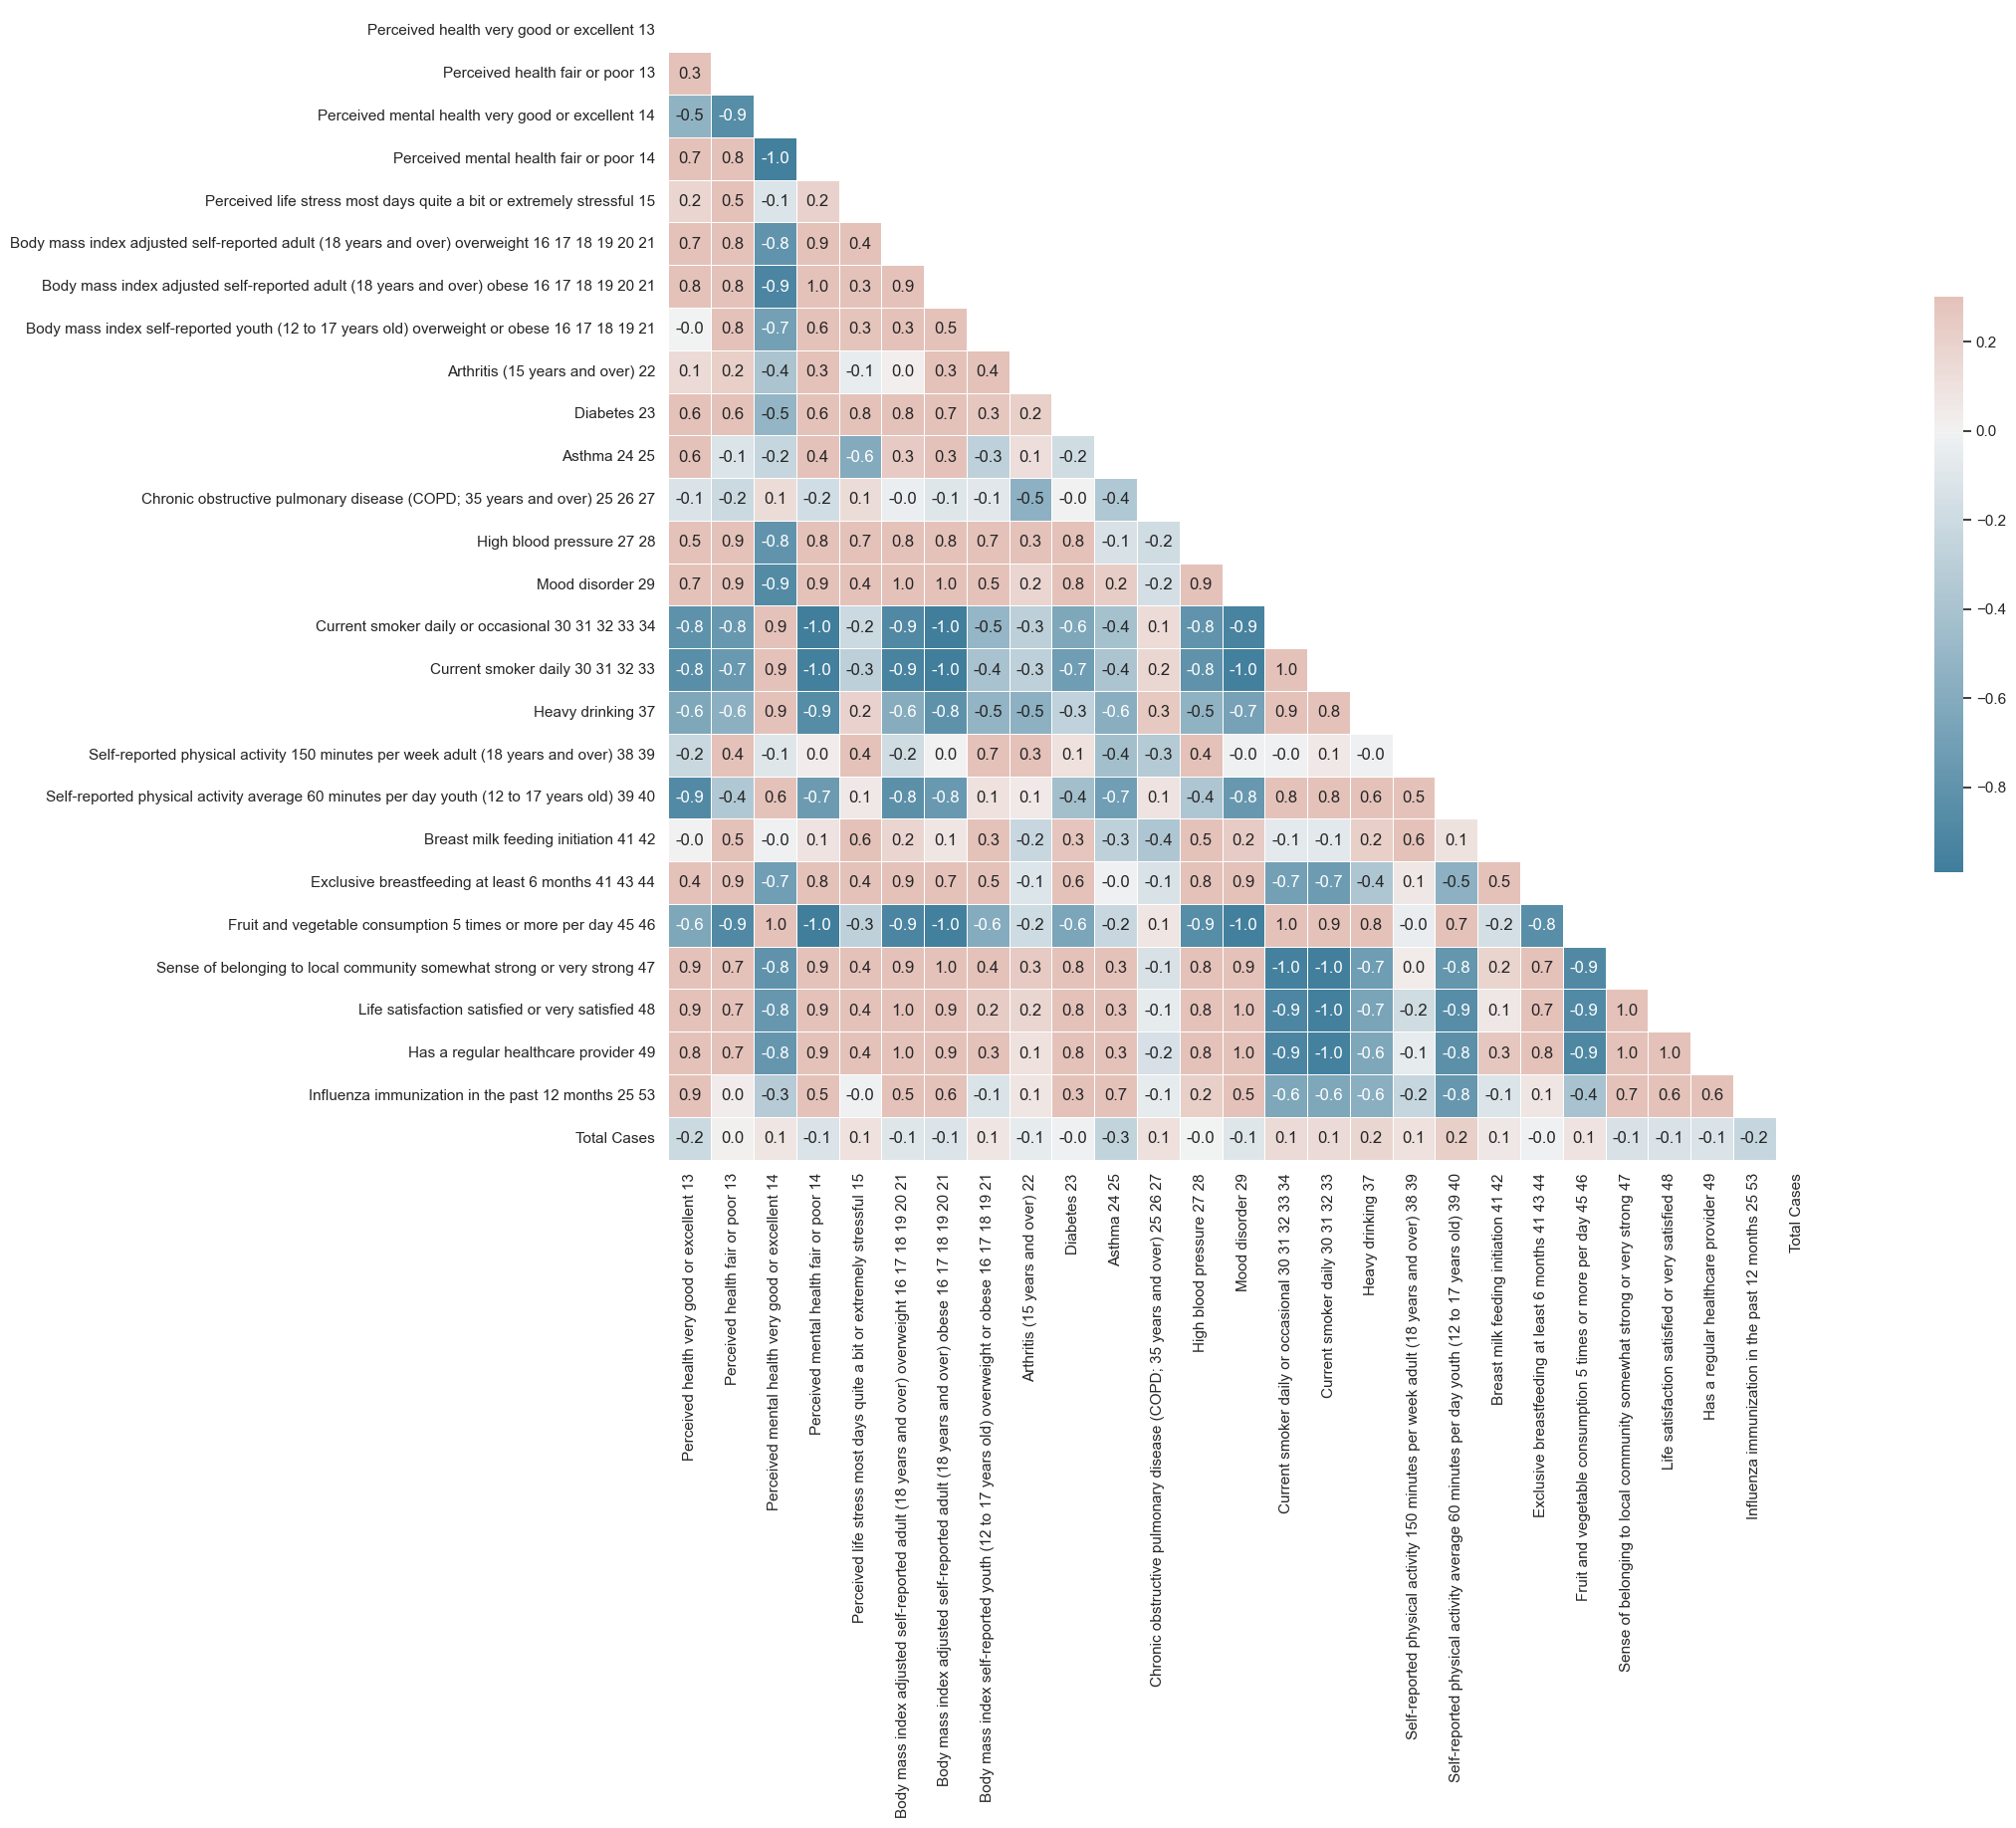

In [41]:
# examine relationship between health indicators and total flu cases over entire time series
indicator_list = df_health_indicators.columns[1:].to_list()
indicator_list.append('y1')
df = df_features[indicator_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace = True)

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f")

# International / Domestic Travel (Monthly, 2017-2022)

In [83]:
sns.set_theme(style="white", context='poster')
plt.rcParams['figure.figsize'] = [30,10]

In [84]:
travel_list = df_air_travel.columns[2:].to_list()
travel_list.extend(['y1','Week Ending'])
df = df_features[travel_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace=True)

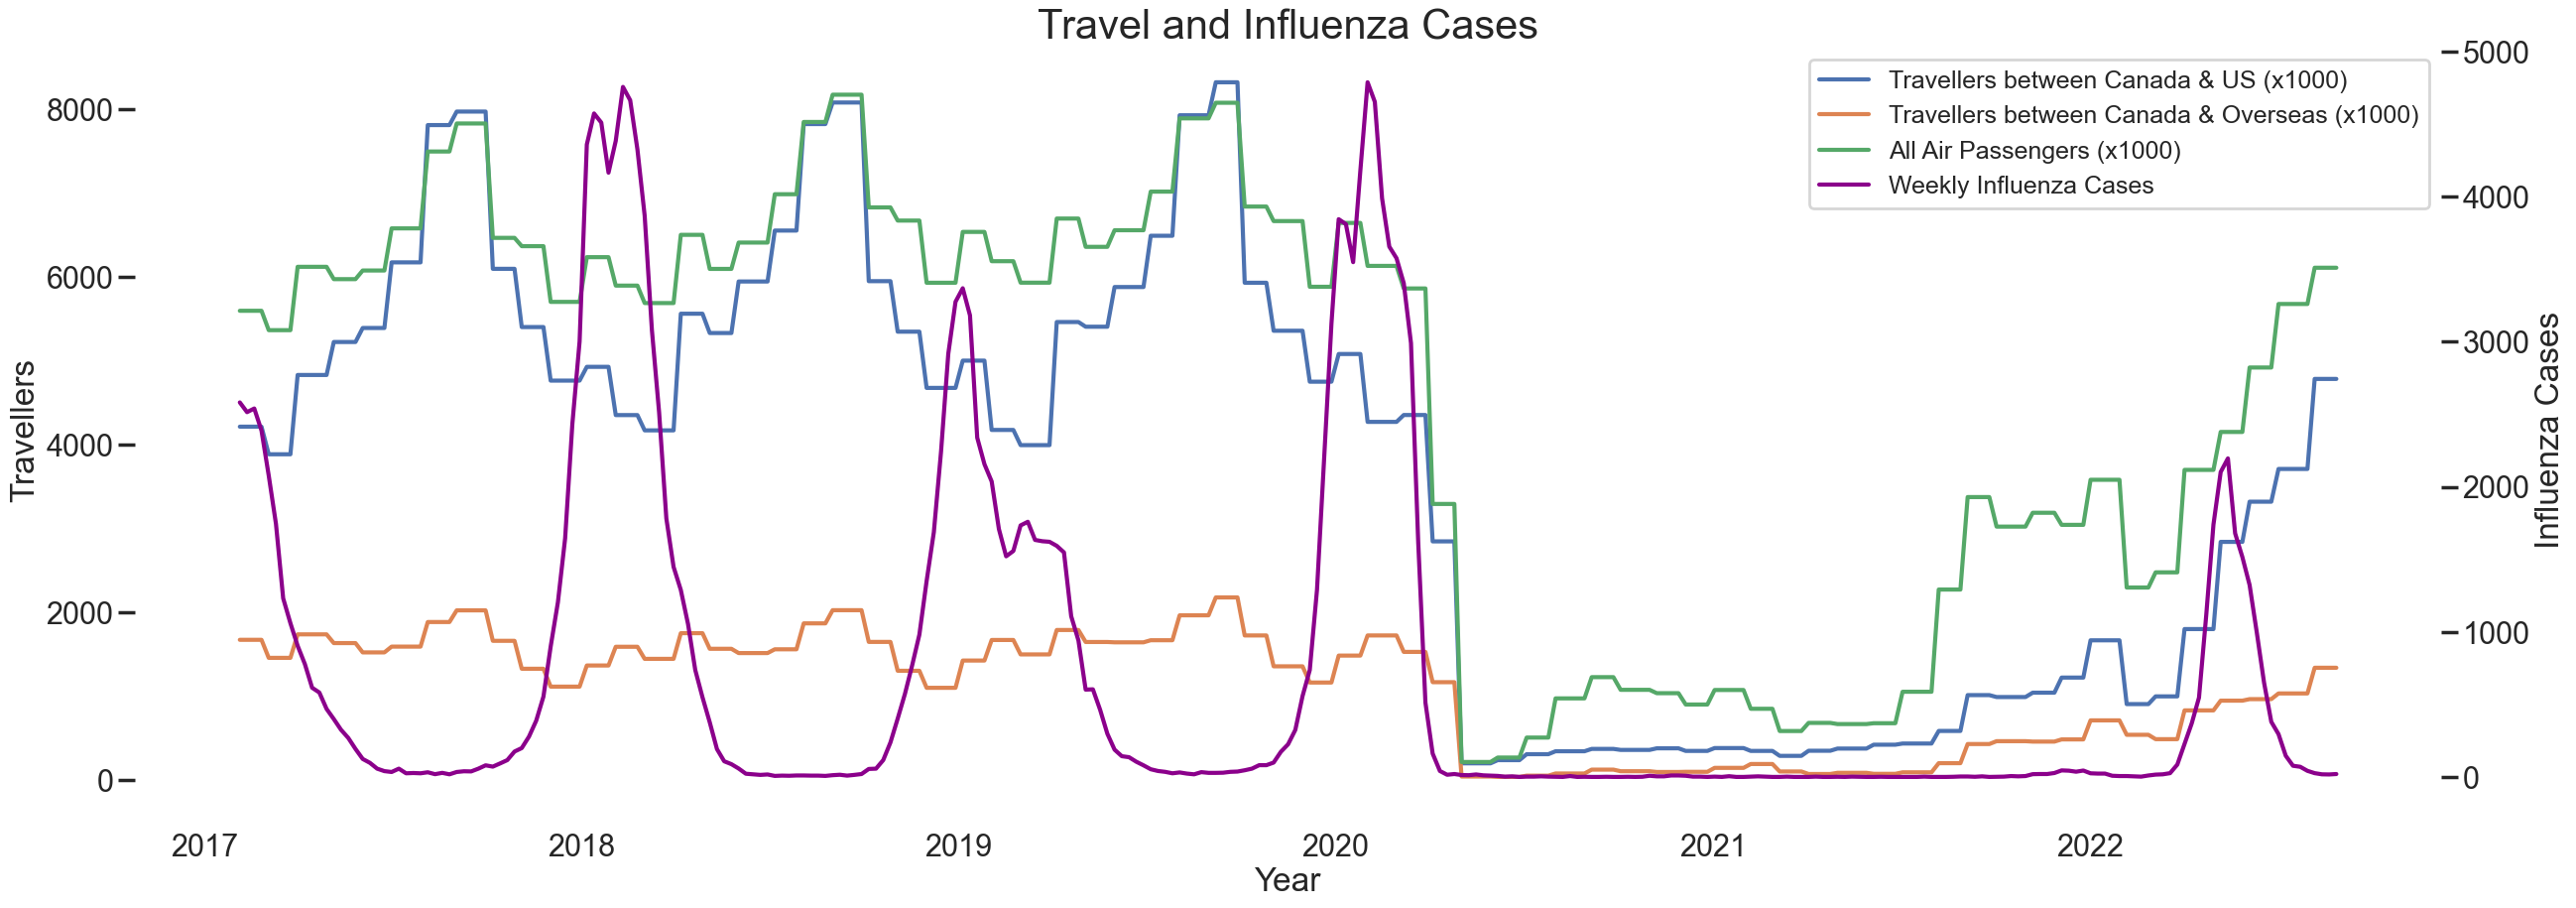

In [86]:
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

fig, ax = plt.subplots()

lns1 = ax.plot(df['Week Ending'], df['Travellers between Canada & US (x1000)'], label='Travellers between Canada & US (x1000)')
lns2 = ax.plot(df['Week Ending'], df['Travellers between Canada & Overseas (x1000)'], label='Travellers between Canada & Overseas (x1000)')
lns3 = ax.plot(df['Week Ending'], df['All Air Passengers (x1000)'], label='All Air Passengers (x1000)')
ax2 = ax.twinx()
lns4 = ax2.plot(df['Week Ending'], df['Total Cases'], label='Weekly Influenza Cases', color='darkmagenta')

# added these four lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper right', prop={'size': 18})

ax.set_xlabel("Year")
ax.set_ylabel("Travellers")
ax2.set_ylabel("Influenza Cases")
plt.title('Travel and Influenza Cases', fontsize= 30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.show()



C:\Users\User\AppData\Local\Temp\ipykernel_35776\2866816153.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


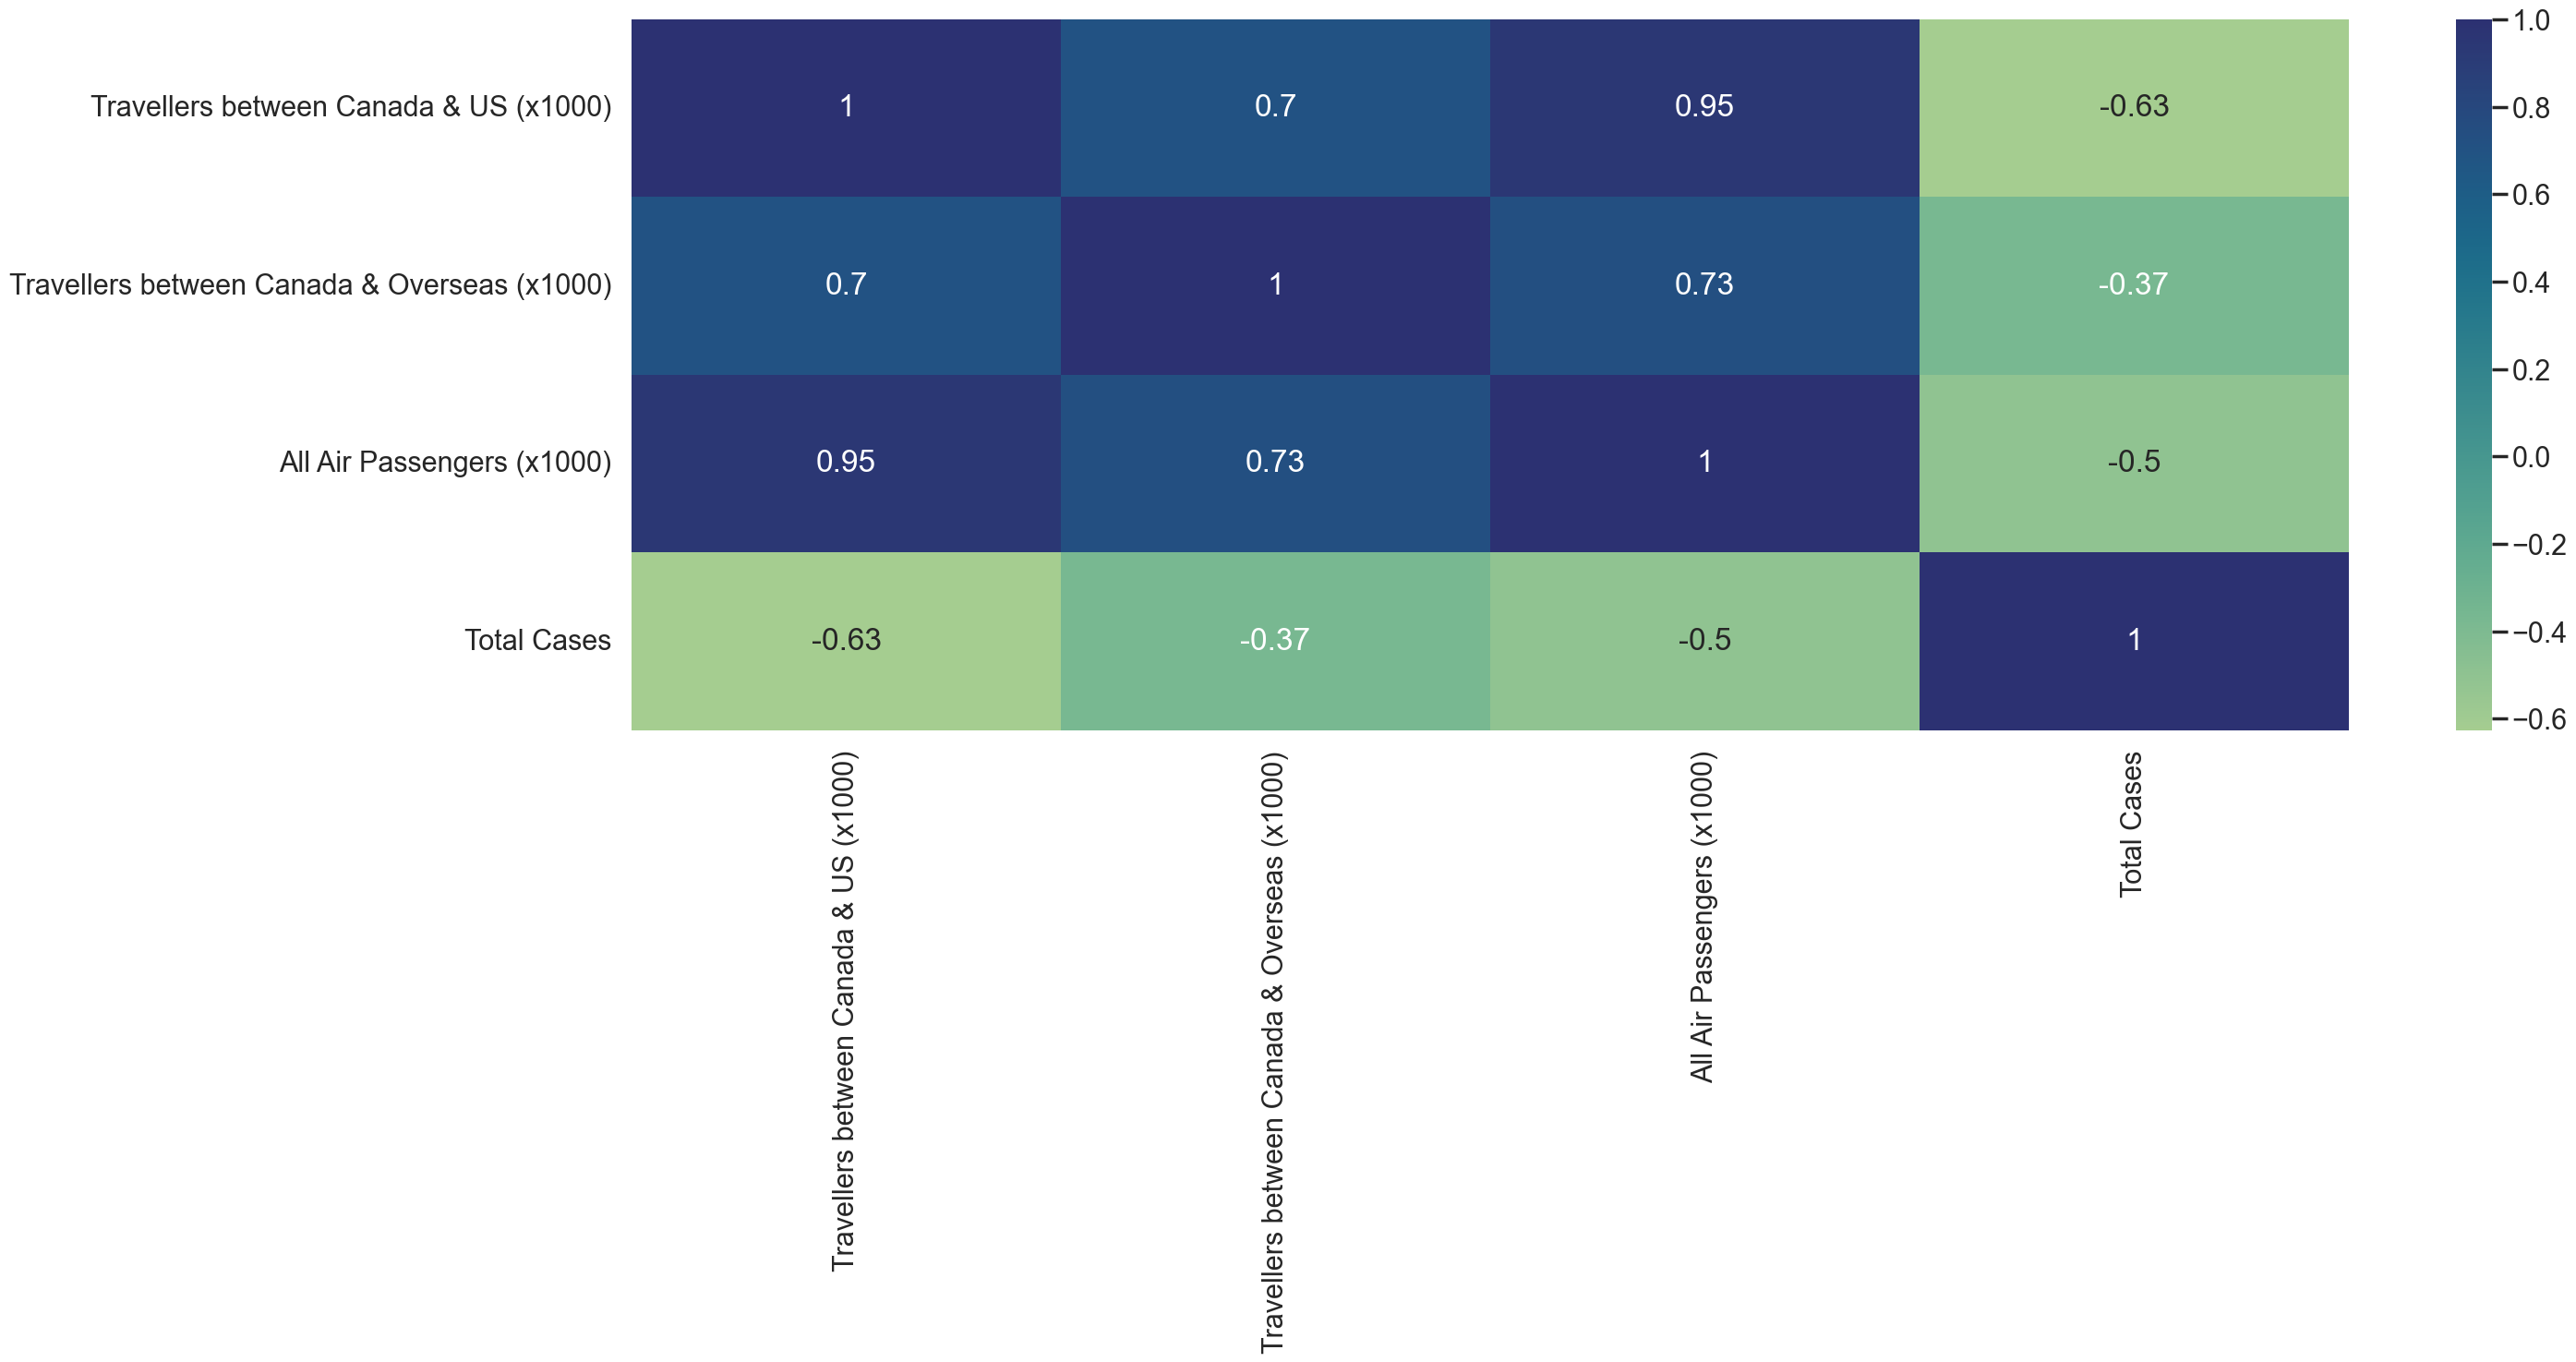

In [45]:
travel_list = df_air_travel.columns[2:].to_list()
travel_list.extend(['y1','Week Ending'])
df = df_features_pre_COVID[travel_list].dropna()
df.set_index('Week Ending')
df.rename(columns={'y1':'Total Cases'}, inplace=True)

cmap = sns.color_palette("crest", as_cmap=True)

# examine relationship between travel and total flu cases - PRE-COVID
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap=cmap)
plt.show()

In [46]:
for col in df.columns[0:3]:
    pearson_coef, p_value = pearsonr(df['Total Cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for Travellers between Canada & US (x1000)  is -0.6269918386918034  with a P-value of P = 5.701267678128901e-19
The Pearson Correlation Coefficient for Travellers between Canada & Overseas (x1000)  is -0.37114885167897665  with a P-value of P = 1.253957001866935e-06
The Pearson Correlation Coefficient for All Air Passengers (x1000)  is -0.5002227531728747  with a P-value of P = 1.415029866785387e-11


C:\Users\User\AppData\Local\Temp\ipykernel_35776\3379381129.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


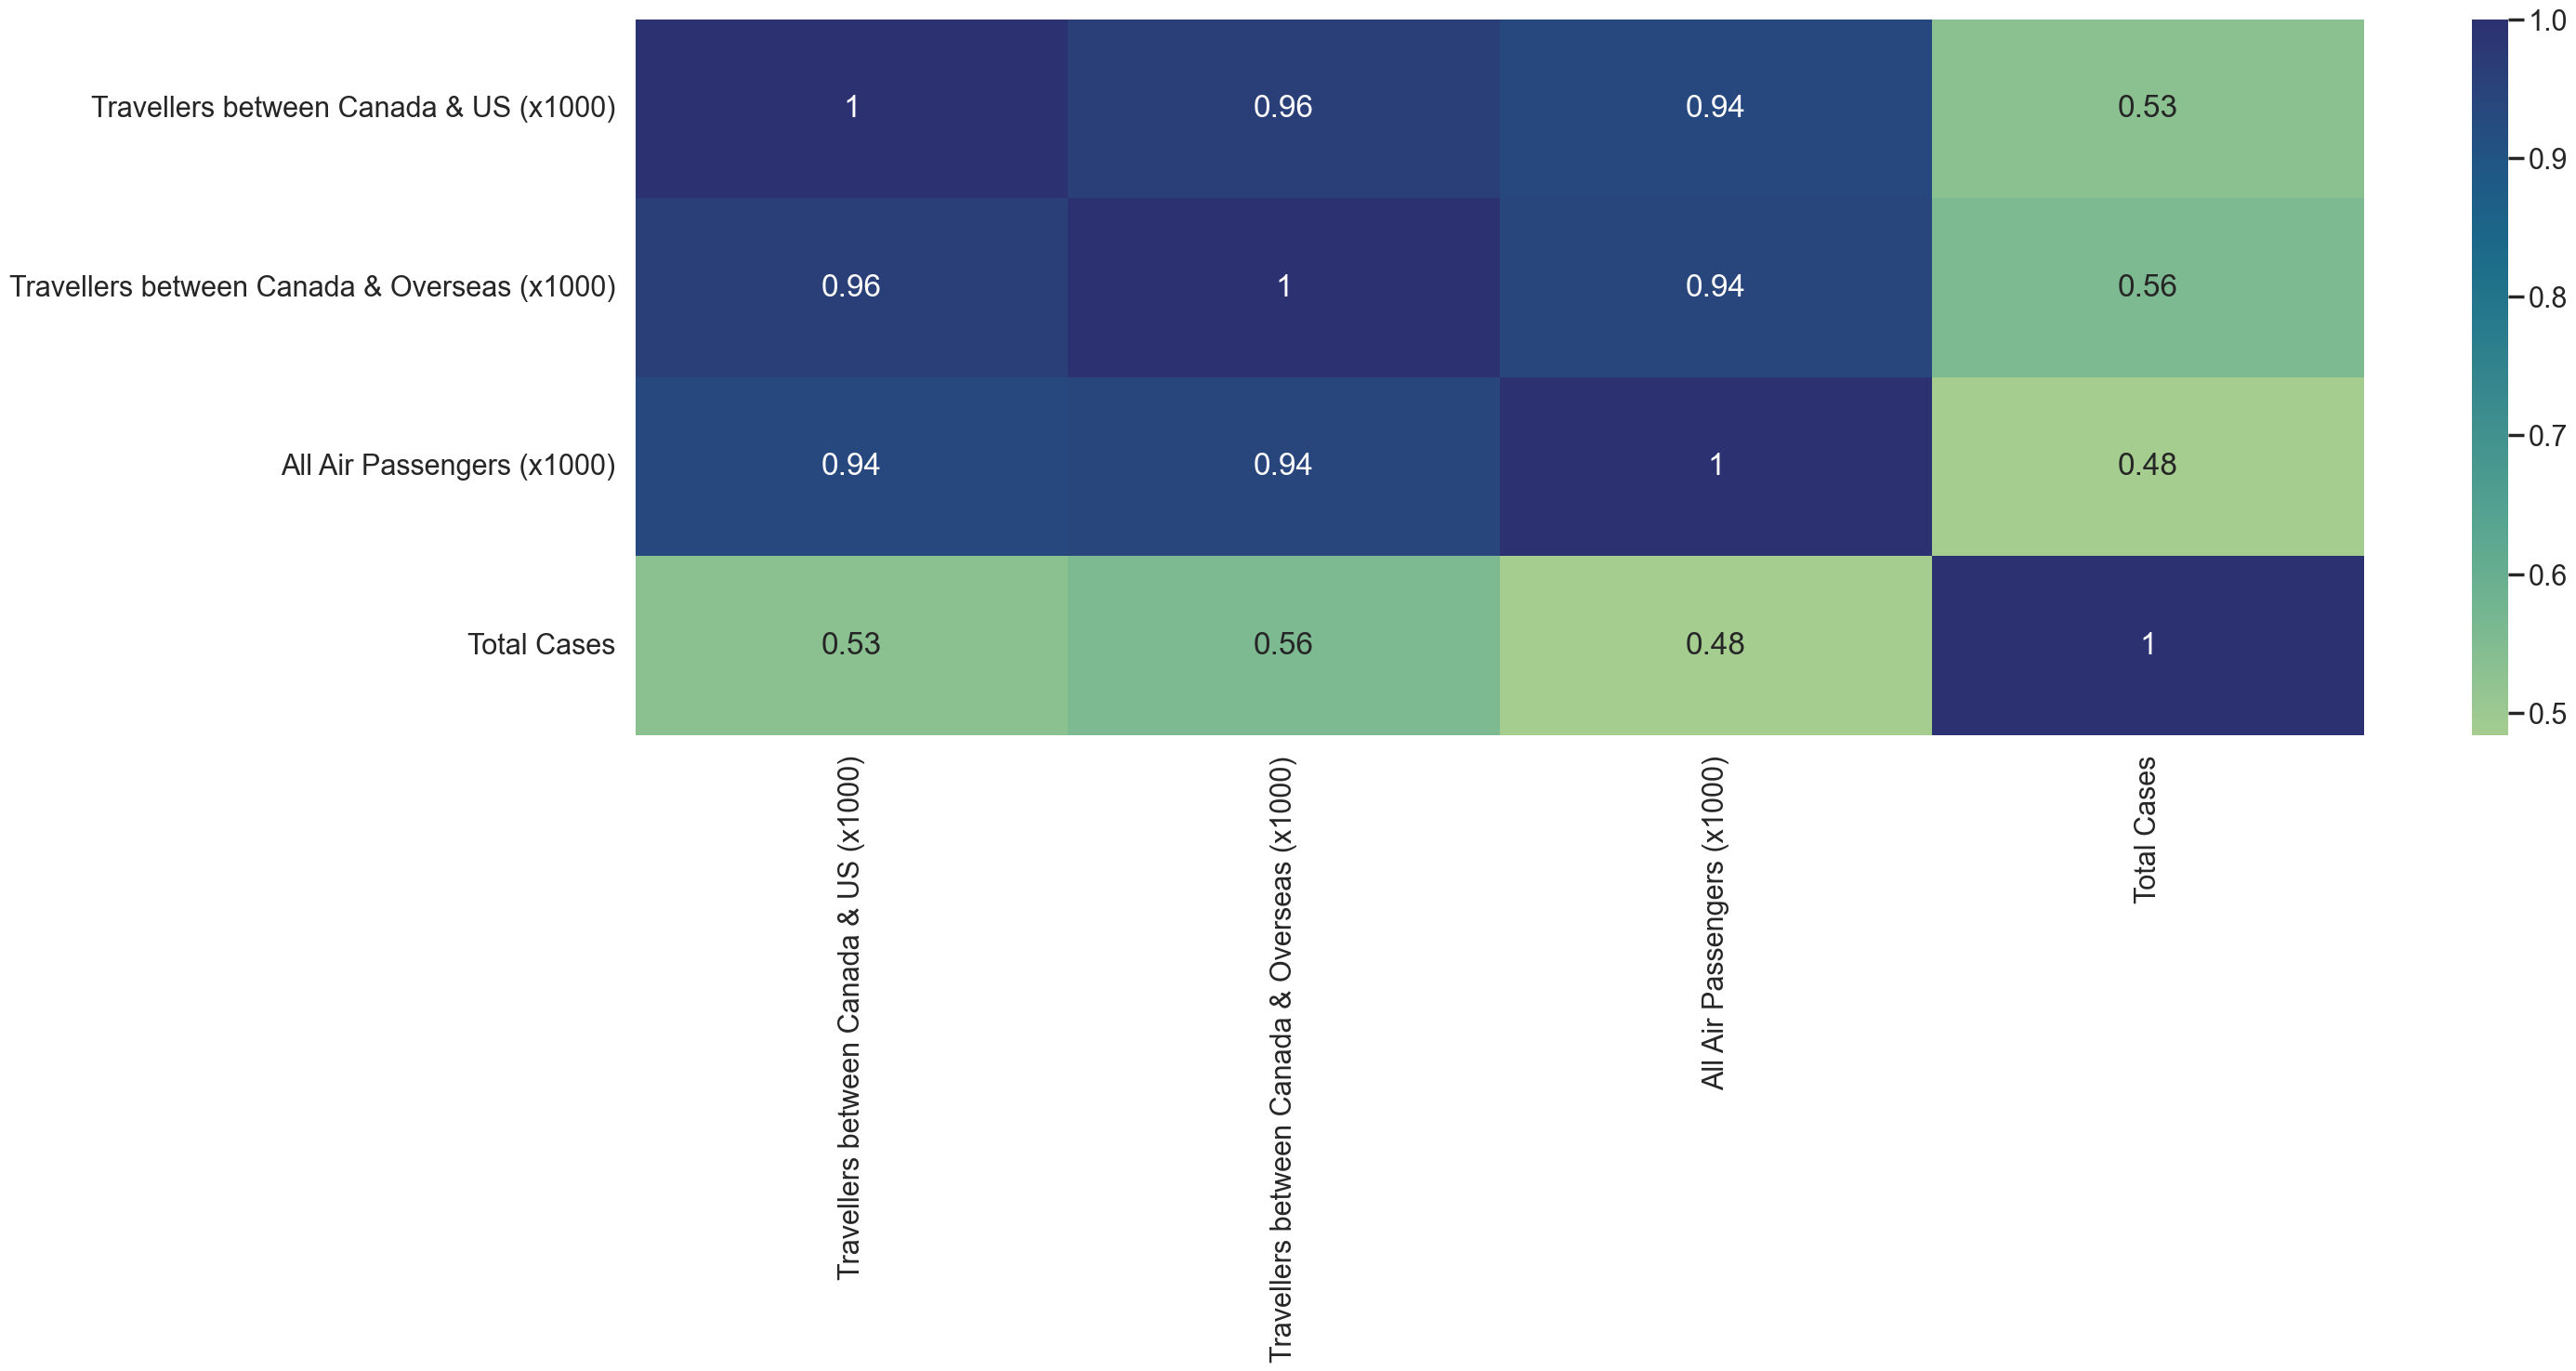

In [47]:
travel_list = df_air_travel.columns[2:].to_list()
travel_list.extend(['y1','Week Ending'])
df = df_features_COVID[travel_list].dropna()
df.set_index('Week Ending')
df.rename(columns={'y1':'Total Cases'}, inplace=True)

cmap = sns.color_palette("crest", as_cmap=True)

# examine relationship between travel and total flu cases -  SINCE COVID
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap=cmap)
plt.show()

In [48]:
for col in df.columns[0:3]:
    pearson_coef, p_value = pearsonr(df['Total Cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for Travellers between Canada & US (x1000)  is 0.5315379285317026  with a P-value of P = 7.676840462384176e-11
The Pearson Correlation Coefficient for Travellers between Canada & Overseas (x1000)  is 0.5575909843817806  with a P-value of P = 5.543794878749634e-12
The Pearson Correlation Coefficient for All Air Passengers (x1000)  is 0.4837776480497114  with a P-value of P = 5.516630921770647e-09


C:\Users\User\AppData\Local\Temp\ipykernel_35776\1797212498.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


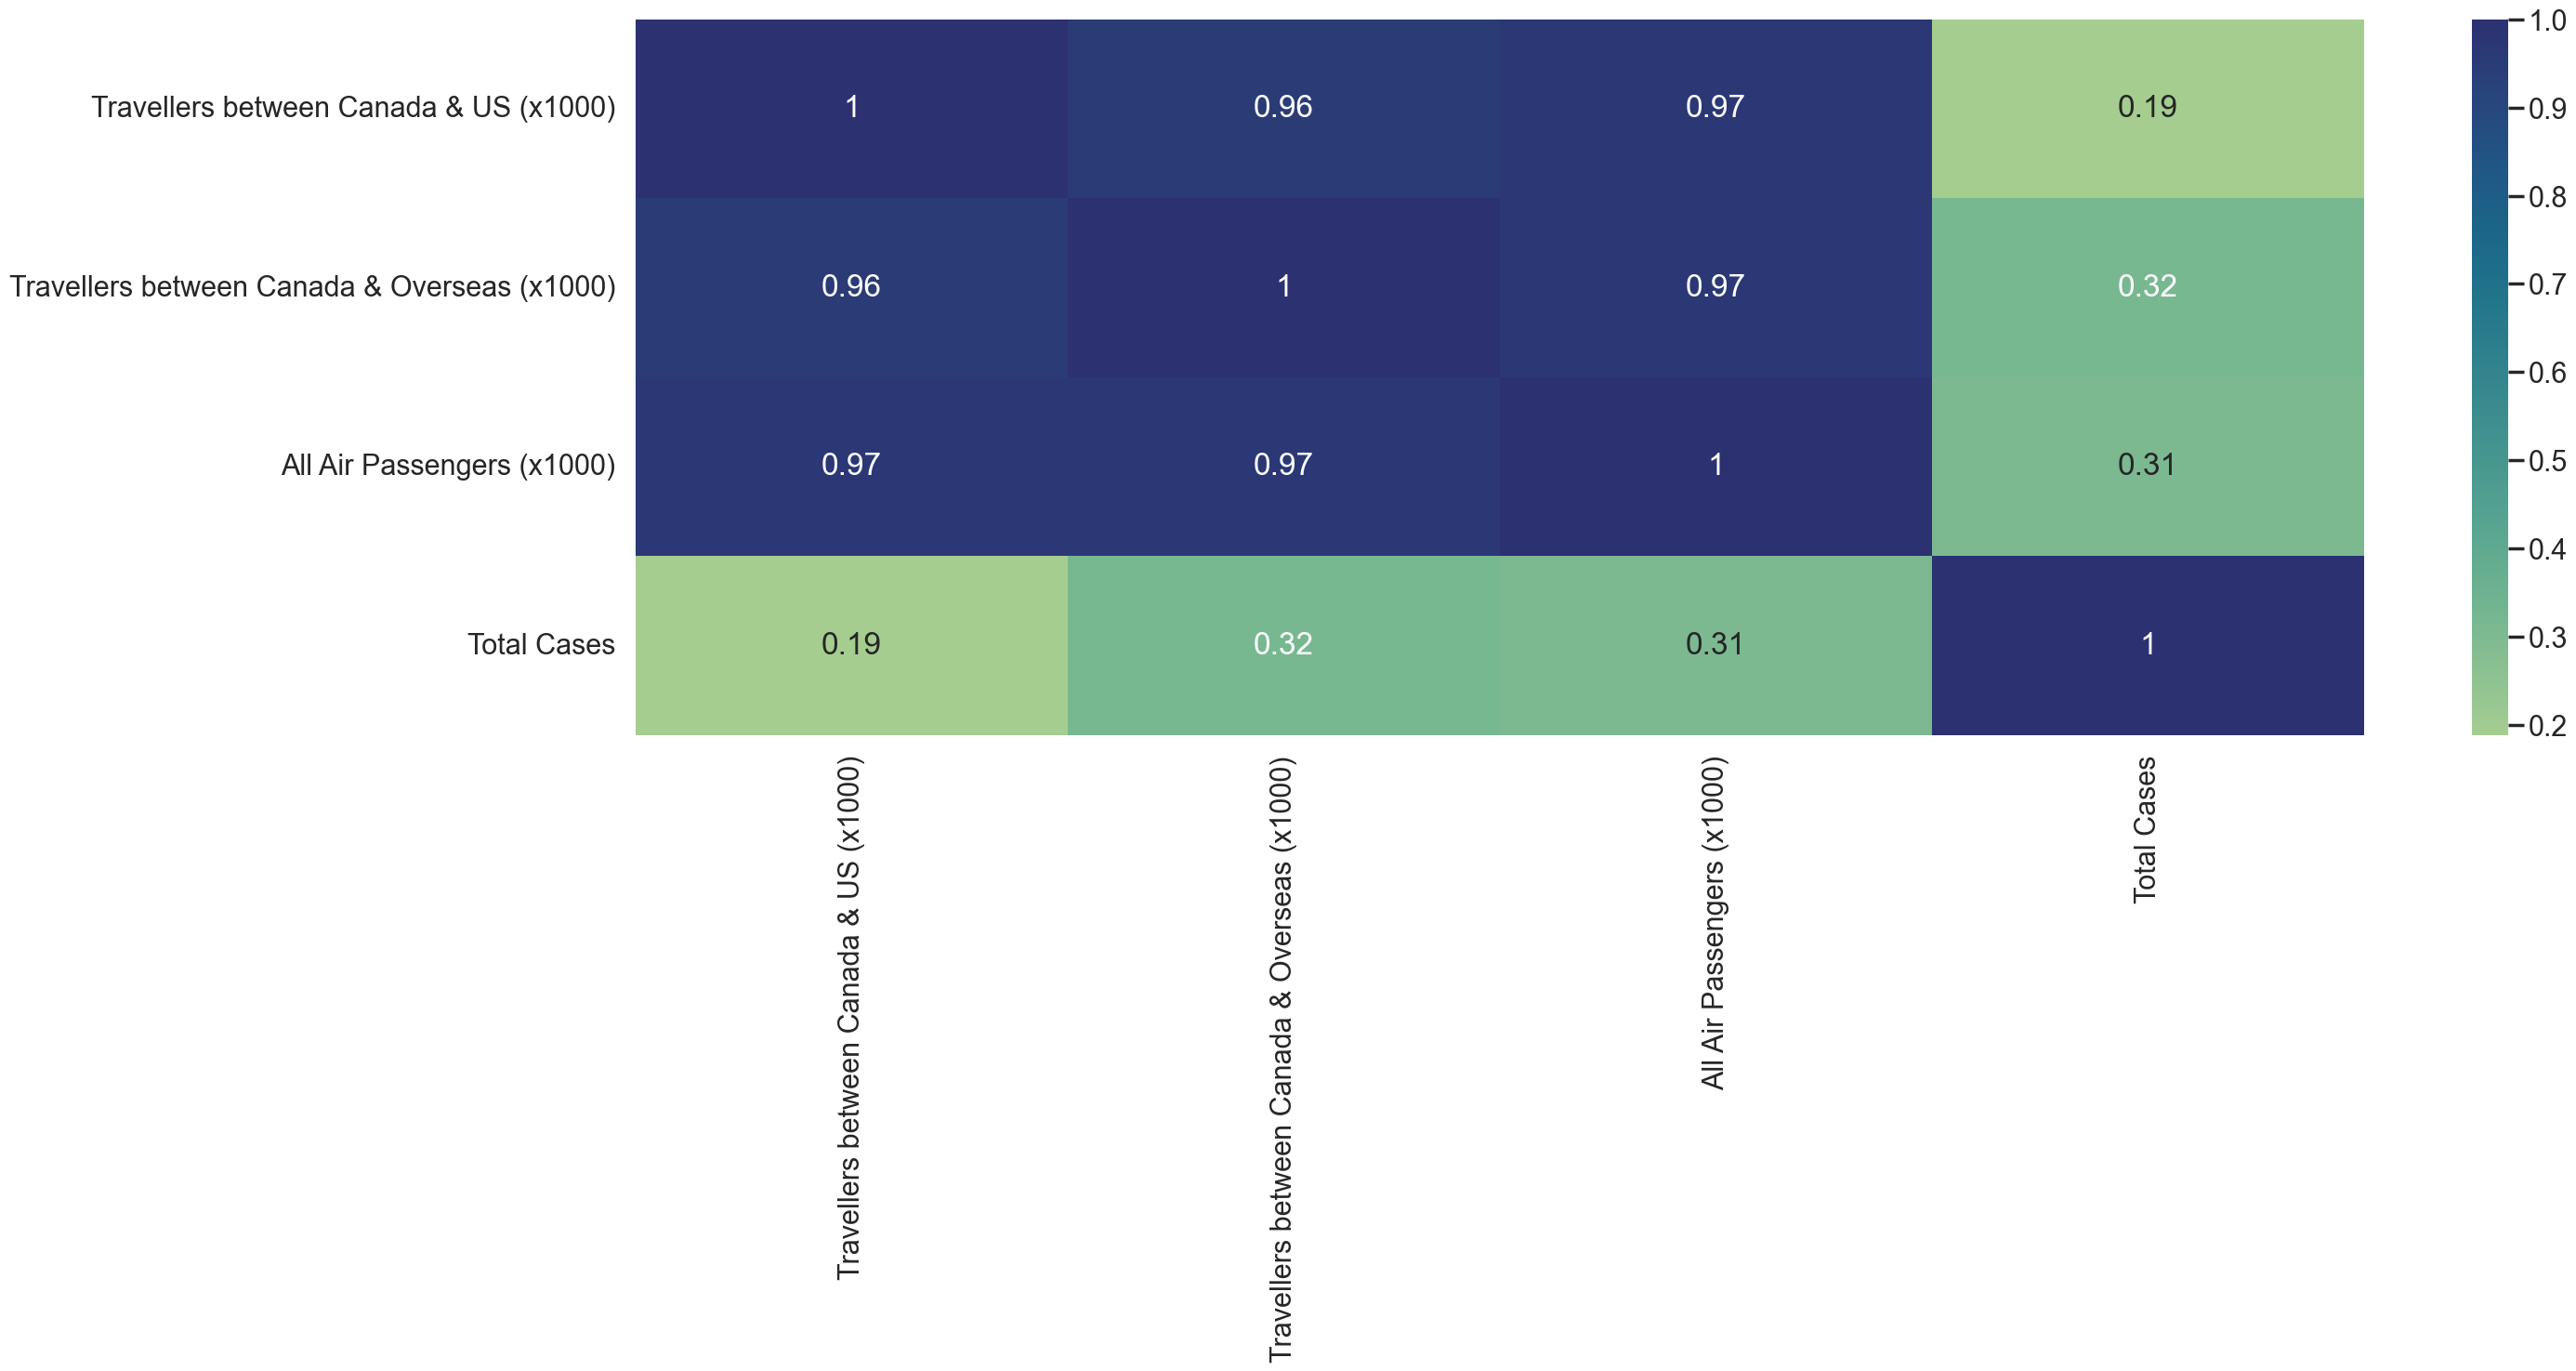

In [49]:
travel_list = df_air_travel.columns[2:].to_list()
travel_list.extend(['y1','Week Ending'])
df = df_features[travel_list].dropna()
df.set_index('Week Ending')
df.rename(columns={'y1':'Total Cases'}, inplace=True)

cmap = sns.color_palette("crest", as_cmap=True)

# examine relationship between travel and total flu cases -  across full dataset
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap=cmap)
plt.show()

In [50]:
for col in df.columns[0:3]:
    pearson_coef, p_value = pearsonr(df['Total Cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for Travellers between Canada & US (x1000)  is 0.18795268759396863  with a P-value of P = 0.0012766035049641023
The Pearson Correlation Coefficient for Travellers between Canada & Overseas (x1000)  is 0.31647596418226265  with a P-value of P = 3.4304957379925403e-08
The Pearson Correlation Coefficient for All Air Passengers (x1000)  is 0.3053387668964739  with a P-value of P = 1.0741787852393461e-07


# Urban Transit (Monthly, 2017-2022)

In [6]:
sns.set_theme(style="white", context='poster')
plt.rcParams['figure.figsize'] = [30,10]

In [7]:
transit_list = df_urban_transit.columns[2:].to_list()
transit_list.extend(['y1','Week Ending'])
df = df_features[transit_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace=True)
df['Passenger Trips x 10,000'] = df['Passenger Trips x 1,000,000'].apply(lambda x: x*100)

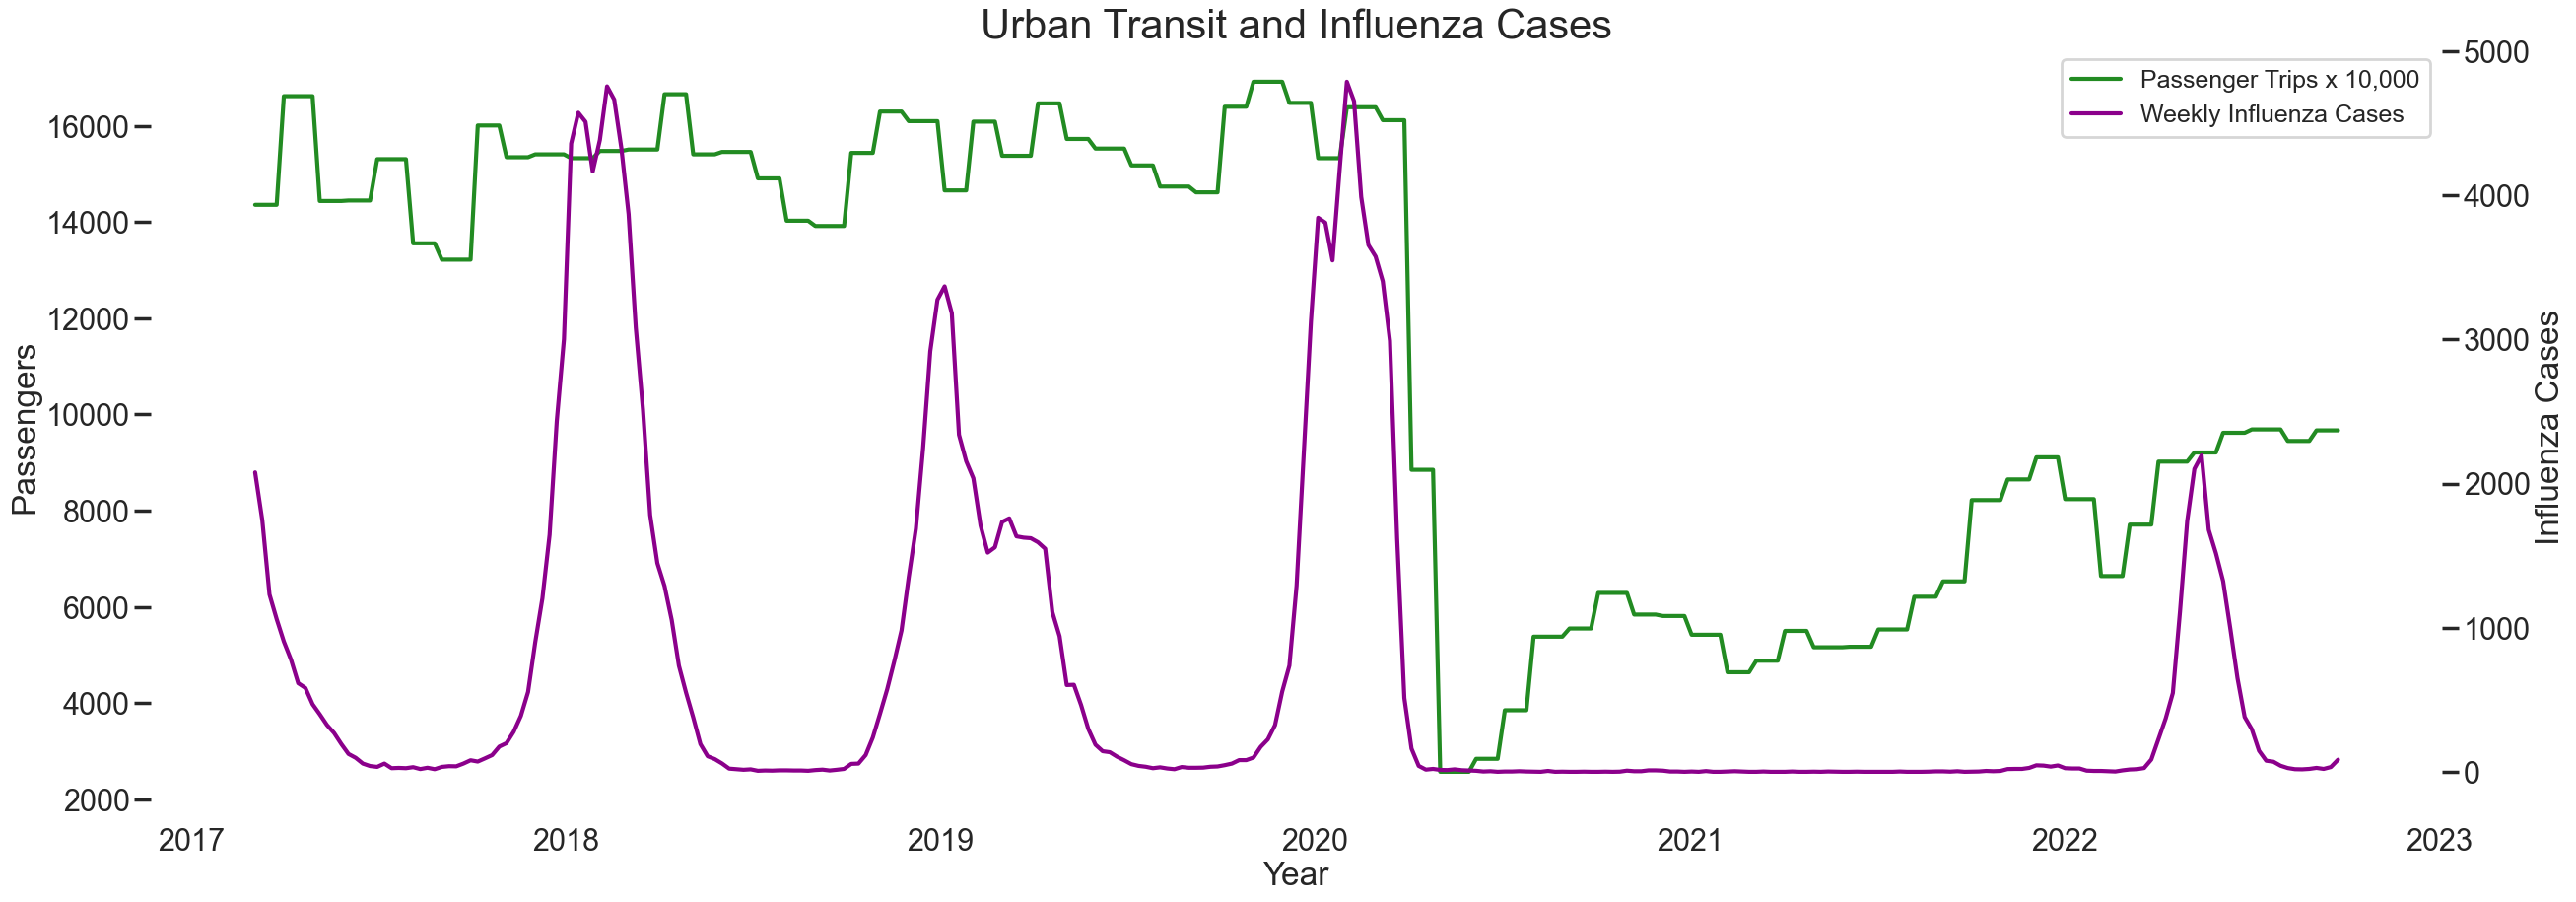

In [8]:
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

fig, ax = plt.subplots()

lns1 = ax.plot(df['Week Ending'], df['Passenger Trips x 10,000'], label='Passenger Trips x 10,000', color='forestgreen')
ax2 = ax.twinx()
lns2 = ax2.plot(df['Week Ending'], df['Total Cases'], label='Weekly Influenza Cases', color='darkmagenta')

# added these four lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper right', prop={'size': 18})

ax.set_xlabel("Year")
ax.set_ylabel("Passengers")
ax2.set_ylabel("Influenza Cases")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.title('Urban Transit and Influenza Cases', fontsize= 30)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_35776\4105159528.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


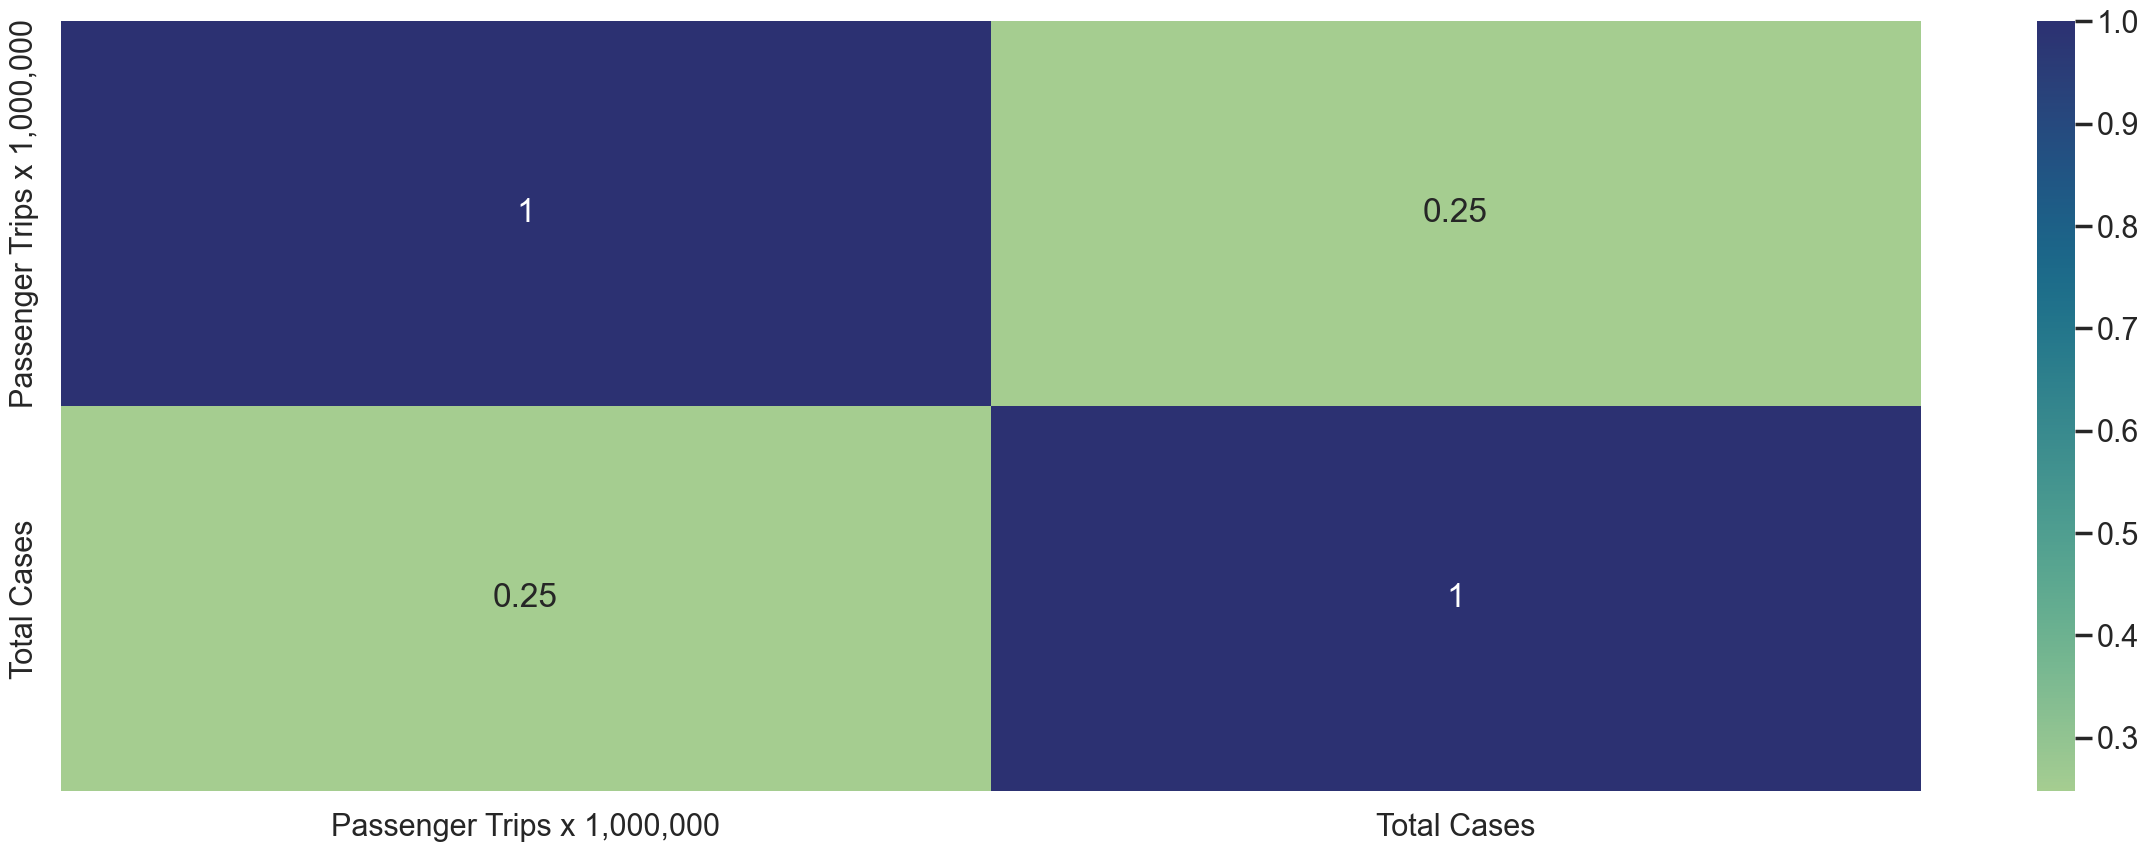

In [54]:
transit_list = df_urban_transit.columns[2:].to_list()
transit_list.extend(['y1','Week Ending'])
df = df_features_pre_COVID[transit_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace=True)

cmap = sns.color_palette("crest", as_cmap=True)

# examine relationship between travel and total flu cases - PRE-COVID
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap=cmap)
plt.show()

In [55]:
for col in df.columns[0:1]:
    pearson_coef, p_value = pearsonr(df['Total Cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for Passenger Trips x 1,000,000  is 0.24748053553117005  with a P-value of P = 0.001778655869512142


C:\Users\User\AppData\Local\Temp\ipykernel_35776\932855034.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


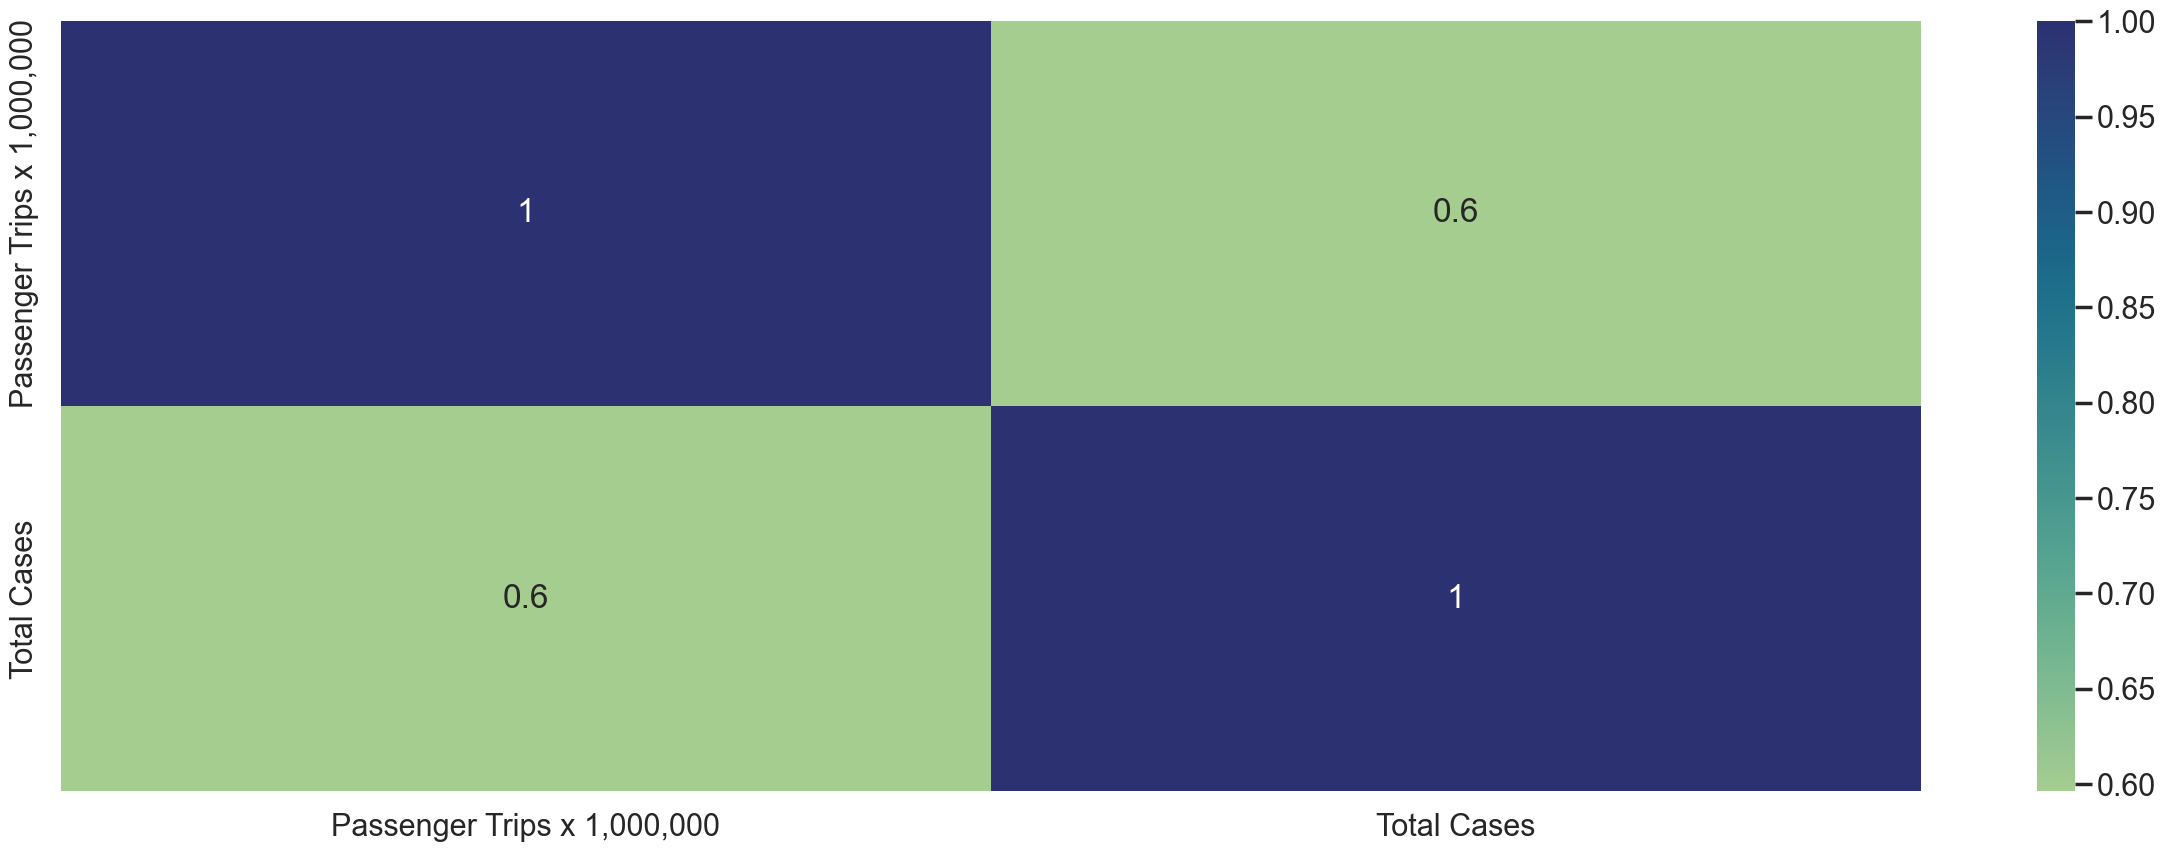

In [56]:
transit_list = df_urban_transit.columns[2:].to_list()
transit_list.extend(['y1','Week Ending'])
df = df_features_COVID[transit_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace=True)

cmap = sns.color_palette("crest", as_cmap=True)

# examine relationship between travel and total flu cases - SINCE COVID
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap=cmap)
plt.show()

In [57]:
for col in df.columns[0:1]:
    pearson_coef, p_value = pearsonr(df['Total Cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for Passenger Trips x 1,000,000  is 0.5961487743597051  with a P-value of P = 2.9732837354660153e-14


C:\Users\User\AppData\Local\Temp\ipykernel_35776\733634734.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


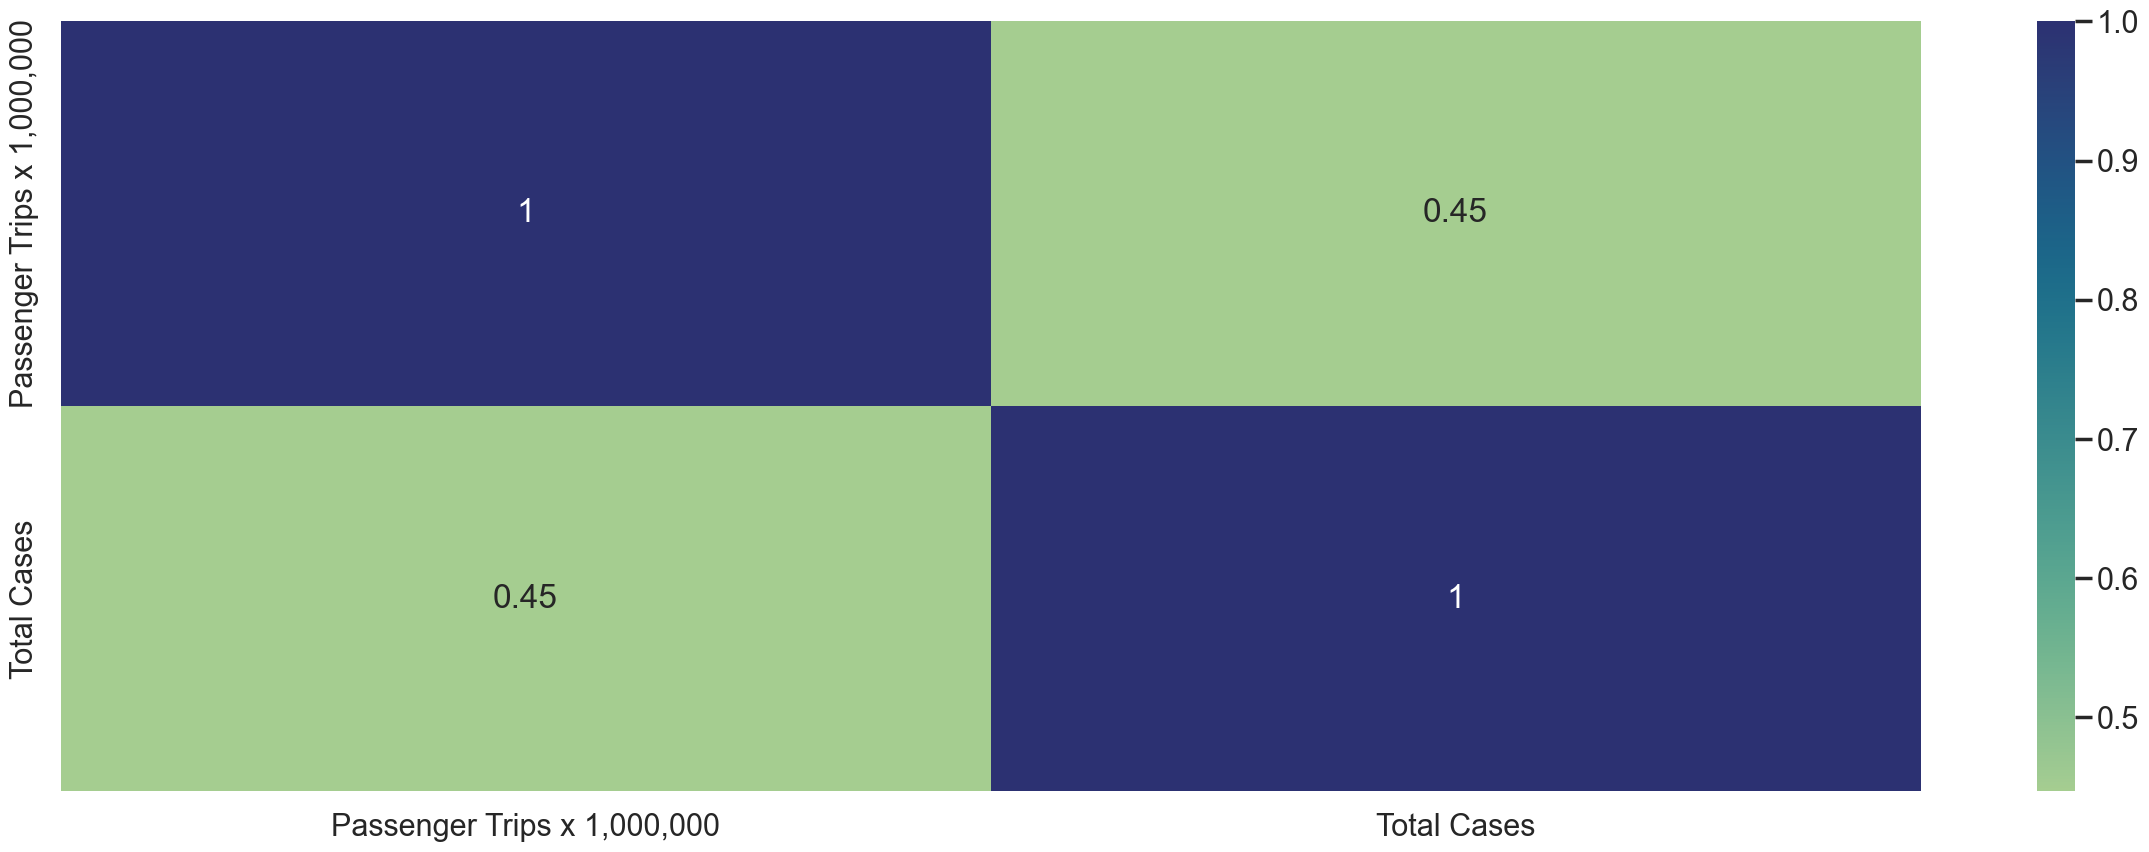

In [58]:
transit_list = df_urban_transit.columns[2:].to_list()
transit_list.extend(['y1','Week Ending'])
df = df_features[transit_list].dropna()
df.rename(columns={'y1':'Total Cases'}, inplace=True)

cmap = sns.color_palette("crest", as_cmap=True)

# examine relationship between travel and total flu cases - full time series
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap=cmap)
plt.show()

In [59]:
for col in df.columns[0:1]:
    pearson_coef, p_value = pearsonr(df['Total Cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for Passenger Trips x 1,000,000  is 0.4467524445308621  with a P-value of P = 1.1068510668690904e-15


# Google Trends - Flu Symptom Search Terms (Monthly, 2015-Present)

In [94]:
sns.set_context(context='talk')
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = [30,15]

In [95]:
# full feature set - full time series, pre-COVID, post-COVID
df_features = pickle.load(open(r"..\data\df_flu_all_features.pkl", "rb" ))
df_features_pre_COVID = pickle.load(open(r"..\data\df_flu_pre_COVID_all_features.pkl", "rb" ))
df_features_COVID = pickle.load(open(r"..\data\df_flu_COVID_all_features.pkl", "rb" ))

[Text(0.5, 0, 'flu cases'),
 Text(1.5, 0, 'body aches'),
 Text(2.5, 0, 'chills'),
 Text(3.5, 0, 'cough'),
 Text(4.5, 0, 'diarrhea'),
 Text(5.5, 0, 'fatigue'),
 Text(6.5, 0, 'fever'),
 Text(7.5, 0, 'flu'),
 Text(8.5, 0, 'headache'),
 Text(9.5, 0, 'runny nose'),
 Text(10.5, 0, 'sore thoat'),
 Text(11.5, 0, 'vomiting')]

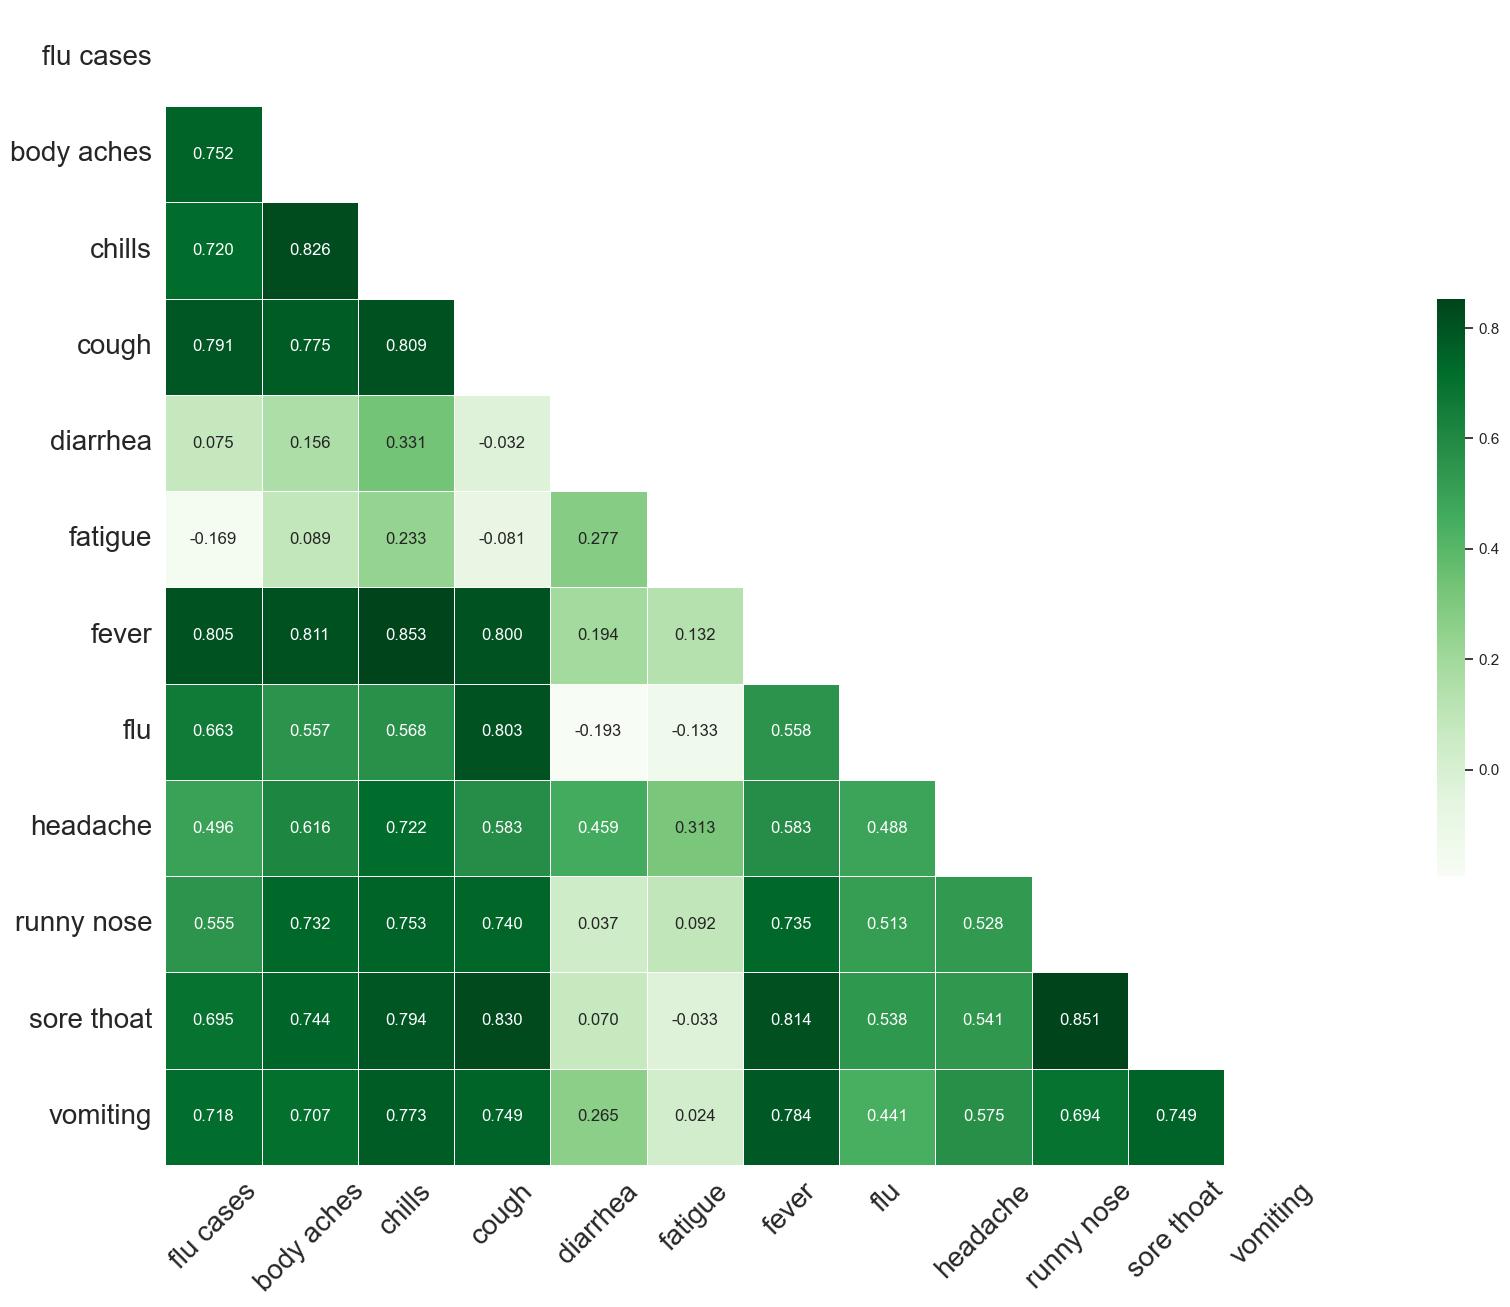

In [96]:
# examine relationship between flu symptom searches and total flu cases PRE-COVID

indicator_list = df_flu_symptoms.columns[2:].to_list()
indicator_list.insert(0,'y1')
df = df_features_pre_COVID[indicator_list].dropna()
df.rename(columns={'y1':'flu cases','body_aches':'body aches','runny_nose':'runny nose','sore_thoat':'sore thoat'}, inplace = True)

corr = df.corr()

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,15))

# Generate a custom diverging colormap
cmap = sns.color_palette("Greens", as_cmap=True)

# vmax=.3, 
# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, cbar_kws={"shrink": .5}, linewidths=.5, annot=True, fmt=".3f")

g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 20)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 20)

In [97]:
df.columns

Index(['flu cases', 'body aches', 'chills', 'cough', 'diarrhea', 'fatigue',
       'fever', 'flu', 'headache', 'runny nose', 'sore thoat', 'vomiting'],
      dtype='object')

In [98]:
for col in df.columns[1:]:
    pearson_coef, p_value = pearsonr(df['flu cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for body aches  is 0.752010161159232  with a P-value of P = 4.610286828006924e-44
The Pearson Correlation Coefficient for chills  is 0.7197733206485472  with a P-value of P = 8.436220374779808e-39
The Pearson Correlation Coefficient for cough  is 0.7909966639531247  with a P-value of P = 1.2644863368759302e-51
The Pearson Correlation Coefficient for diarrhea  is 0.07475622370254752  with a P-value of P = 0.25367085572095344
The Pearson Correlation Coefficient for fatigue  is -0.16856590503846344  with a P-value of P = 0.009630007658572984
The Pearson Correlation Coefficient for fever  is 0.8052769073556431  with a P-value of P = 8.228950654480394e-55
The Pearson Correlation Coefficient for flu  is 0.6626090482677923  with a P-value of P = 4.403566791056769e-31
The Pearson Correlation Coefficient for headache  is 0.4959882266498562  with a P-value of P = 5.37408536354675e-16
The Pearson Correlation Coefficient for runny nose  is 0.5548947762190511  wi

[Text(0.5, 0, 'flu cases'),
 Text(1.5, 0, 'body aches'),
 Text(2.5, 0, 'chills'),
 Text(3.5, 0, 'cough'),
 Text(4.5, 0, 'diarrhea'),
 Text(5.5, 0, 'fatigue'),
 Text(6.5, 0, 'fever'),
 Text(7.5, 0, 'flu'),
 Text(8.5, 0, 'headache'),
 Text(9.5, 0, 'runny nose'),
 Text(10.5, 0, 'sore thoat'),
 Text(11.5, 0, 'vomiting')]

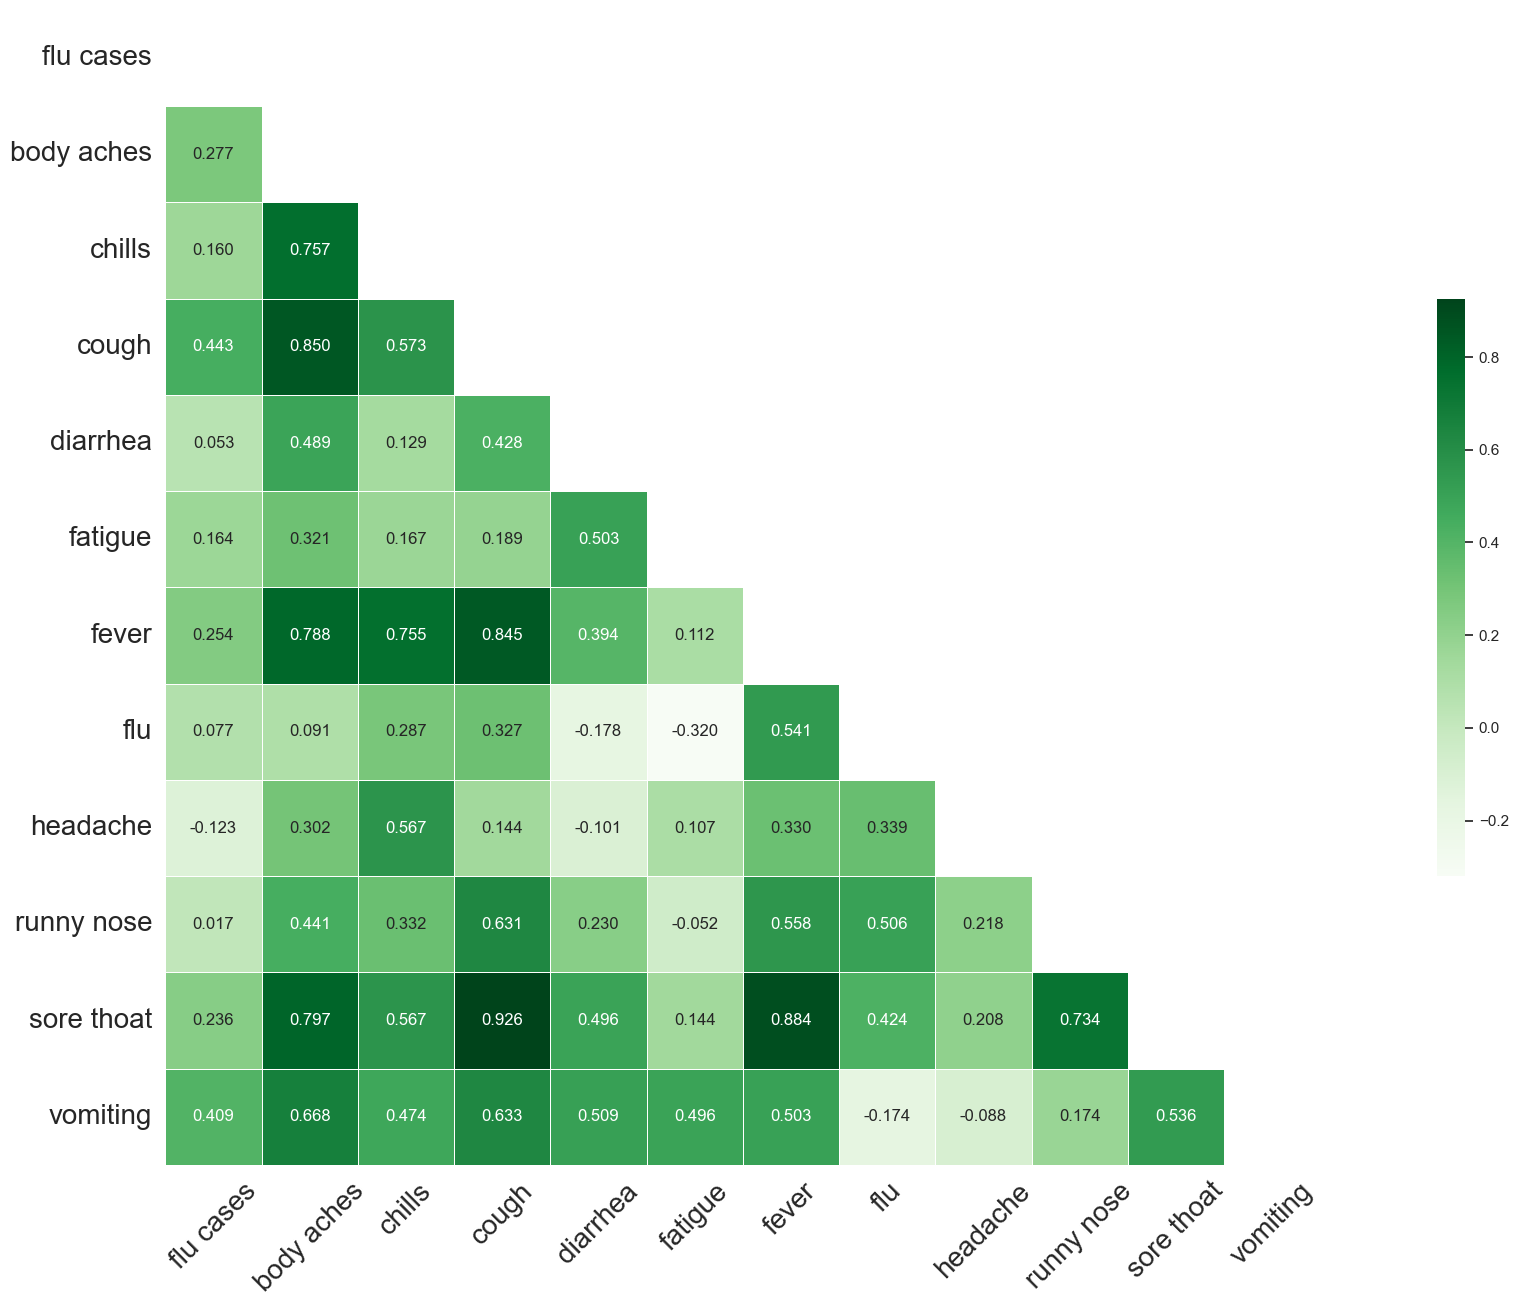

In [99]:
# examine relationship between flu symptom searches and total flu cases SINCE COVID

indicator_list = df_flu_symptoms.columns[2:].to_list()
indicator_list.insert(0,'y1')
df = df_features_COVID[indicator_list].dropna()
df.rename(columns={'y1':'flu cases','body_aches':'body aches','runny_nose':'runny nose','sore_thoat':'sore thoat'}, inplace = True)

corr = df.corr()

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,15))

# Generate a custom diverging colormap
cmap = sns.color_palette("Greens", as_cmap=True)

# vmax=.3, 
# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, cbar_kws={"shrink": .5}, linewidths=.5, annot=True, fmt=".3f")

g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 20)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 20)

In [100]:
for col in df.columns[1:]:
    pearson_coef, p_value = pearsonr(df['flu cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for body aches  is 0.27746704463351957  with a P-value of P = 0.000793568477175515
The Pearson Correlation Coefficient for chills  is 0.16011929973995823  with a P-value of P = 0.05609621137866375
The Pearson Correlation Coefficient for cough  is 0.4433328893239659  with a P-value of P = 2.9377409269160373e-08
The Pearson Correlation Coefficient for diarrhea  is 0.05296790180565505  with a P-value of P = 0.5298165292196507
The Pearson Correlation Coefficient for fatigue  is 0.16350286758839372  with a P-value of P = 0.05103312720409658
The Pearson Correlation Coefficient for fever  is 0.25361855448803616  with a P-value of P = 0.0022404849100324774
The Pearson Correlation Coefficient for flu  is 0.07702968149480531  with a P-value of P = 0.36049826035003363
The Pearson Correlation Coefficient for headache  is -0.12284659726723024  with a P-value of P = 0.1438286840662628
The Pearson Correlation Coefficient for runny nose  is 0.017303528227204497  wit

[Text(0.5, 0, 'flu cases'),
 Text(1.5, 0, 'body aches'),
 Text(2.5, 0, 'chills'),
 Text(3.5, 0, 'cough'),
 Text(4.5, 0, 'diarrhea'),
 Text(5.5, 0, 'fatigue'),
 Text(6.5, 0, 'fever'),
 Text(7.5, 0, 'flu'),
 Text(8.5, 0, 'headache'),
 Text(9.5, 0, 'runny nose'),
 Text(10.5, 0, 'sore thoat'),
 Text(11.5, 0, 'vomiting')]

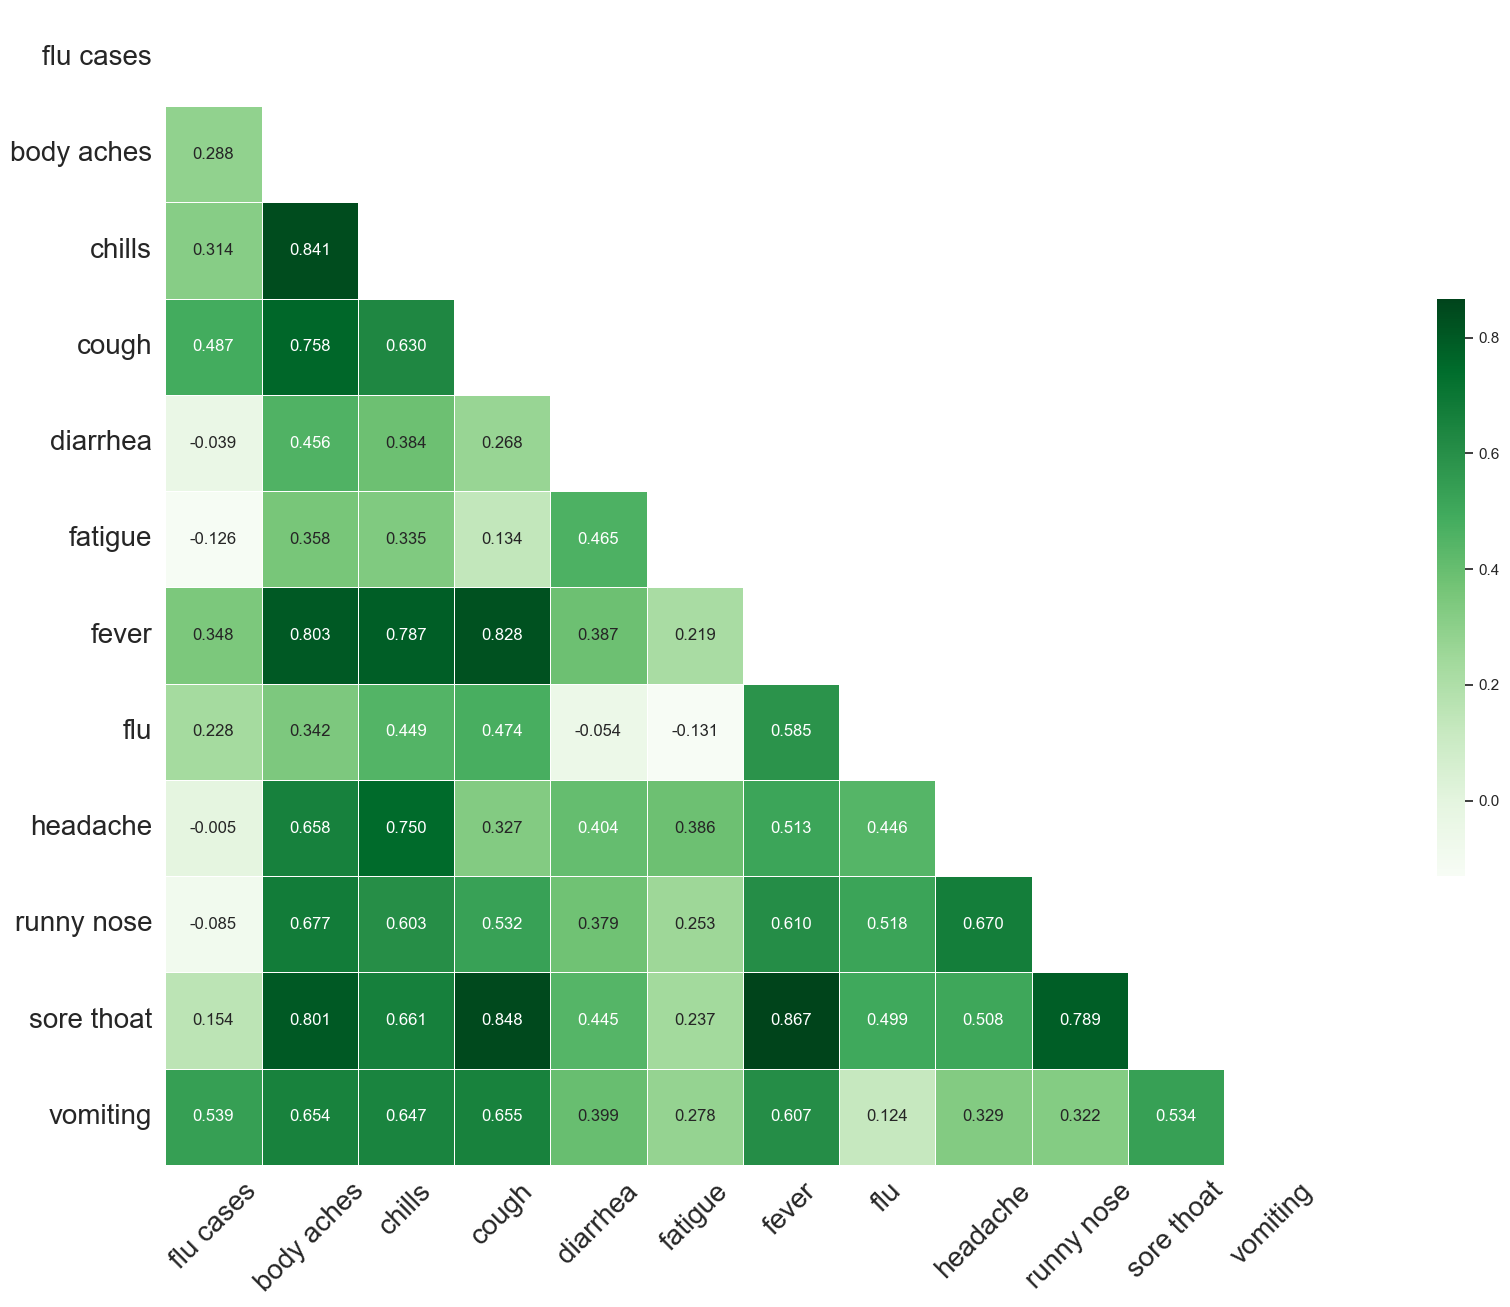

In [101]:
# examine relationship between flu symptom searches and total flu over the whole time series

indicator_list = df_flu_symptoms.columns[2:].to_list()
indicator_list.insert(0,'y1')
df = df_features[indicator_list].dropna()
df.rename(columns={'y1':'flu cases','body_aches':'body aches','runny_nose':'runny nose','sore_thoat':'sore thoat'}, inplace = True)

corr = df.corr()

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,15))

# Generate a custom diverging colormap
cmap = sns.color_palette("Greens", as_cmap=True)

# vmax=.3, 
# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, cbar_kws={"shrink": .5}, linewidths=.5, annot=True, fmt=".3f")

g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 20)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 20)

In [102]:
for col in df.columns[1:]:
    pearson_coef, p_value = pearsonr(df['flu cases'], df[col])
    print("The Pearson Correlation Coefficient for", col, " is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient for body aches  is 0.28816653632806327  with a P-value of P = 1.1598871112381963e-08
The Pearson Correlation Coefficient for chills  is 0.31444827259781927  with a P-value of P = 4.035917677361593e-10
The Pearson Correlation Coefficient for cough  is 0.48730941497372643  with a P-value of P = 6.121980681580594e-24
The Pearson Correlation Coefficient for diarrhea  is -0.038670068125246794  with a P-value of P = 0.45348211402639305
The Pearson Correlation Coefficient for fatigue  is -0.12618480061173157  with a P-value of P = 0.014088136664124219
The Pearson Correlation Coefficient for fever  is 0.3484605264413523  with a P-value of P = 3.121761884687802e-12
The Pearson Correlation Coefficient for flu  is 0.228109207658152  with a P-value of P = 7.483371336195483e-06
The Pearson Correlation Coefficient for headache  is -0.004822416681744781  with a P-value of P = 0.9255472467510683
The Pearson Correlation Coefficient for runny nose  is -0.0849980670645

# Google Trends - Covid Search Terms (Monthly, 2015-Present)

In [ ]:
df_COVID_terms.describe()

Total Cases       month         year        week  coronavirus  \
count   378.000000  379.000000   379.000000  379.000000   378.000000   
mean    752.111111    6.649077  2018.788918   27.171504     4.207672   
std    1280.766037    3.461935     2.116397   15.129936    13.253842   
min       0.000000    1.000000  2015.000000    1.000000     0.000000   
25%      10.000000    4.000000  2017.000000   14.000000     0.500000   
50%      57.000000    7.000000  2019.000000   28.000000     0.500000   
75%     971.000000   10.000000  2021.000000   40.000000     3.000000   
max    7773.000000   12.000000  2022.000000   53.000000   100.000000   

            COVID    lockdown        mask  quarantine  social_distancing  \
count  378.000000  378.000000  378.000000  378.000000         378.000000   
mean    19.017196    8.822751   26.238095    9.537037           4.423280   
std     29.426510   19.247593   17.933015   15.930051          16.150796   
min      0.000000    1.000000   12.000000    1.000000           0.000000   
25%      0.000000    1.000000   16.000000    1.000000           0.000000   
50%      0.500000    1.000000   18.000000    1.000000           0.000000   
75%     41.000000    6.000000   32.000000   12.000000           1.000000   
max    100.000000  100.000000  100.000000  100.000000         100.000000   

          vaccine  
count  378.000000  
mean    10.880952  
std     21.791004  
min      1.000000  
25%      1.000000  
50%      1.000000  
75%      8.000000  
max    100.000000

In [ ]:
df_COVID_terms = df_COVID_terms.drop(columns=['month','year','week'])

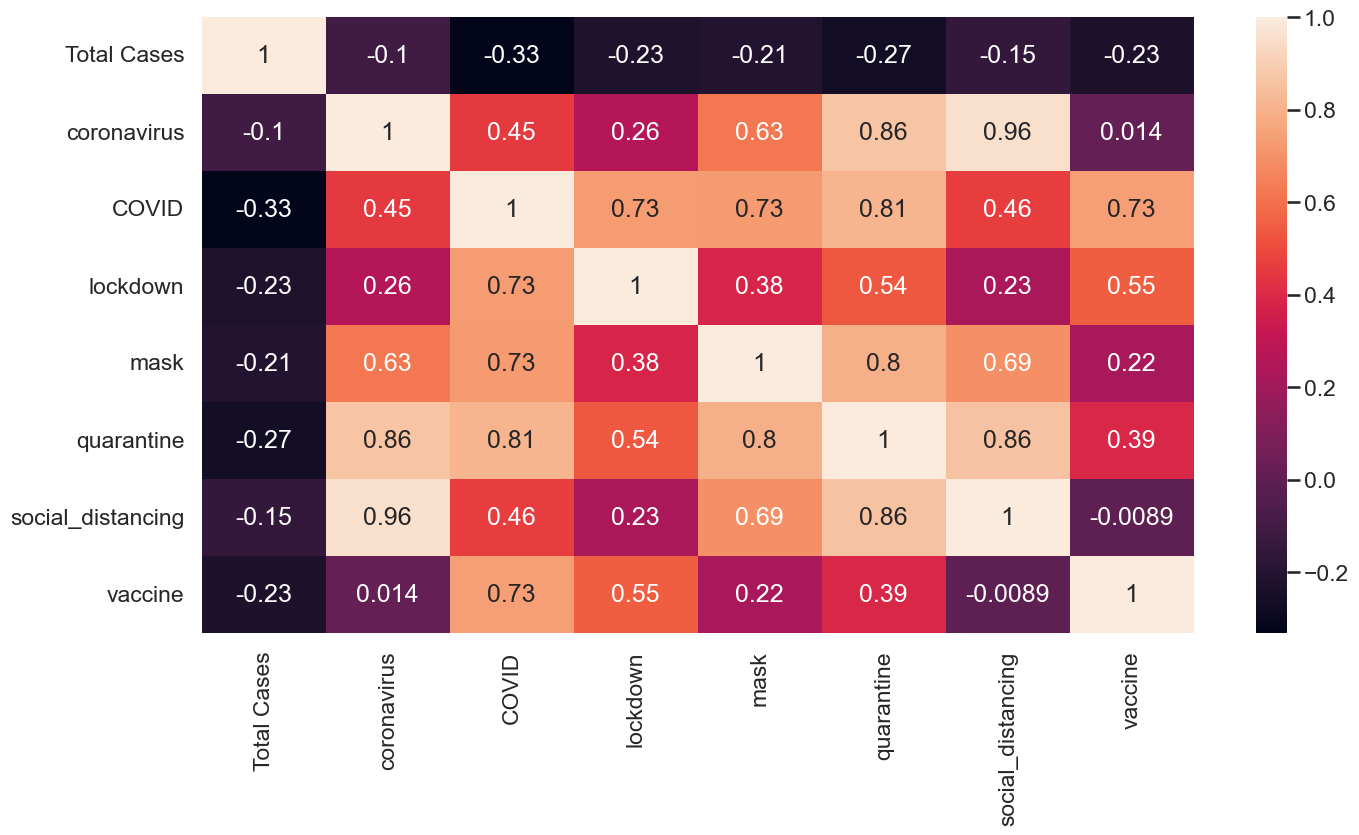

In [ ]:
corr_matrix = df_COVID_terms.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
df_COVID_terms_pre_COVID = df_COVID_terms_pre_COVID.drop(columns=['month','year','week'])

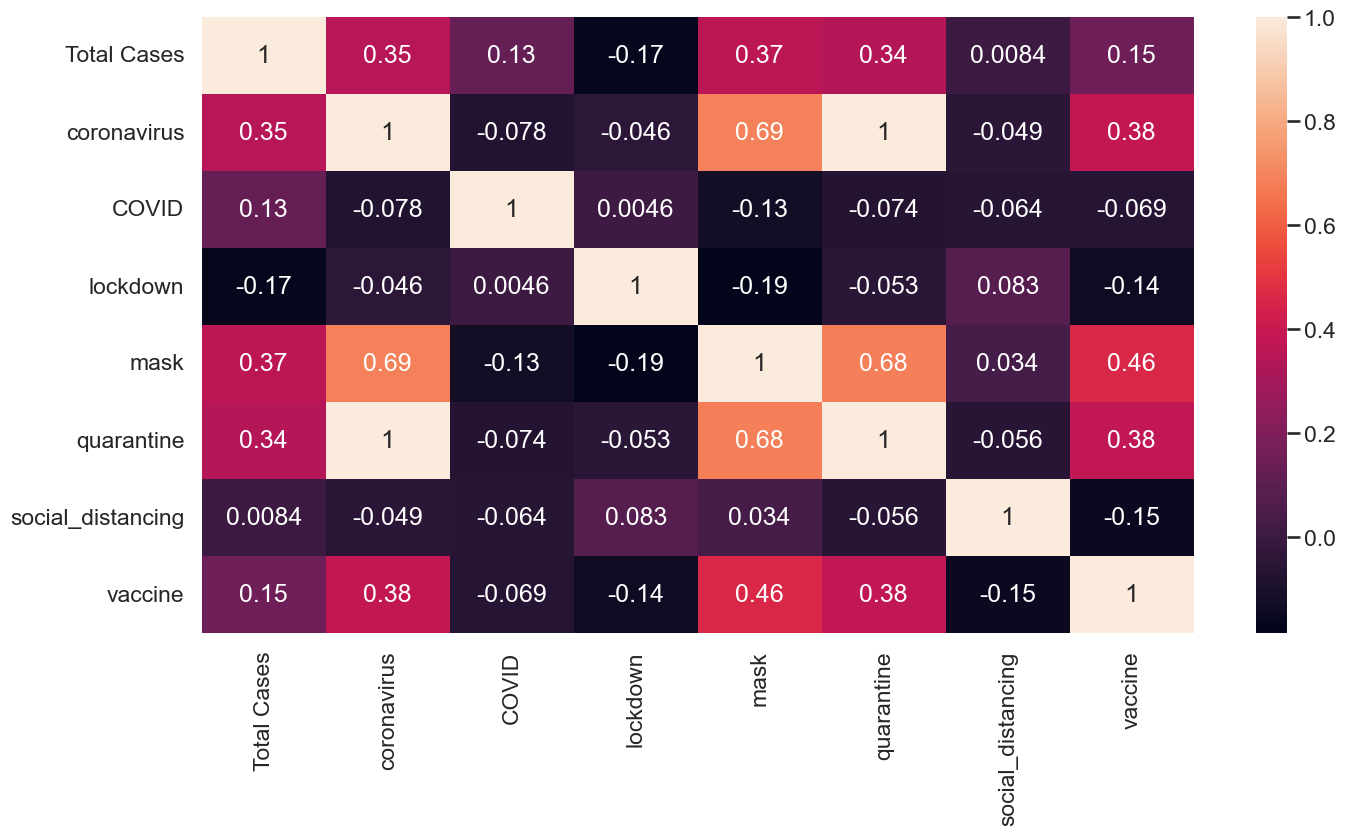

In [ ]:
corr_matrix = df_COVID_terms_pre_COVID.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
df_COVID_terms_COVID = df_COVID_terms_COVID.drop(columns=['month','year','week'])

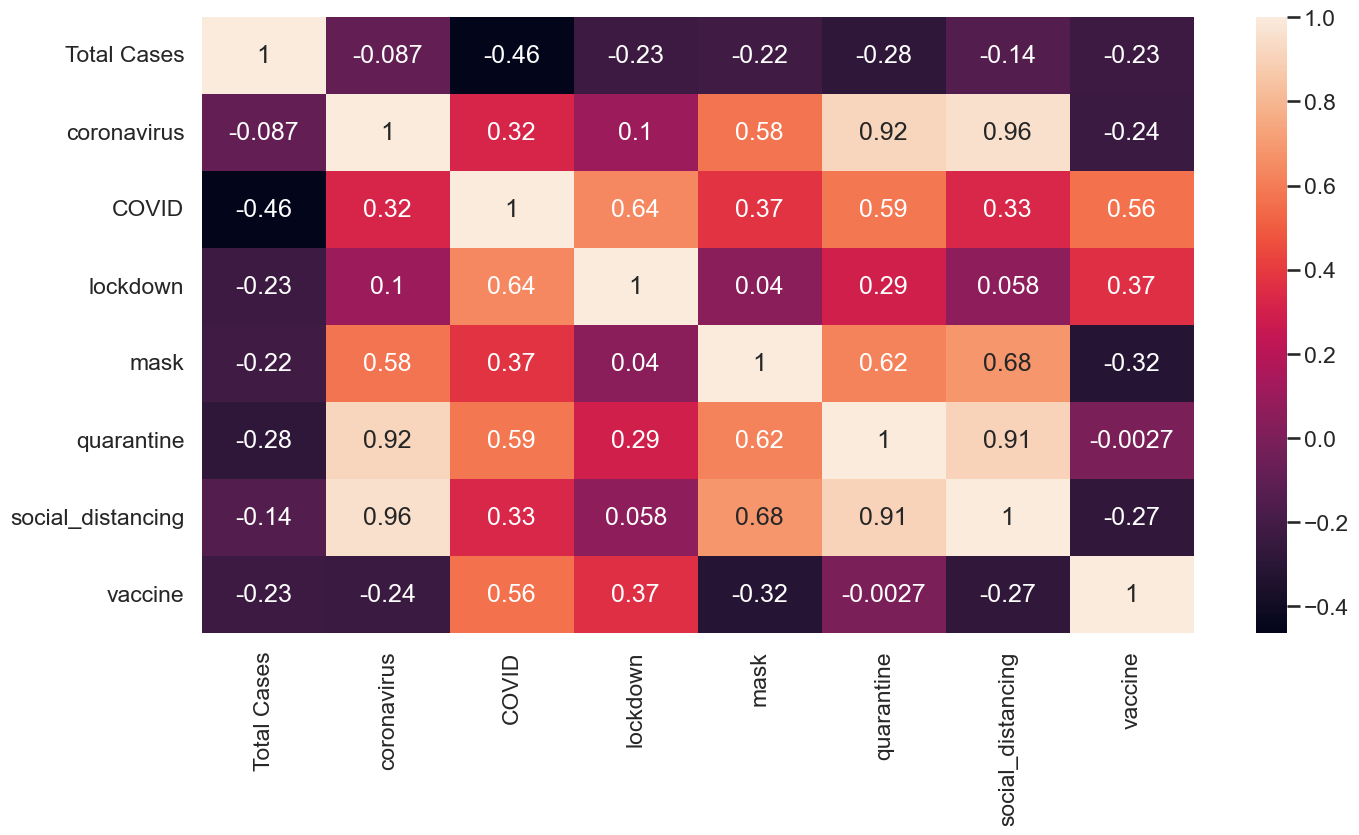

In [ ]:
corr_matrix = df_COVID_terms_COVID.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()